# Lenstronomy experiments simulations

In this notebook I am trying out lenstronomy and experimenting with the parameters.

## Using the starting guide

This is in a separate notebook.

## Using the simulation tutorial

I will use the simulation tutorial from the lenstronomy website to play with creating lenses. I will first focuss on the r-band.

### Installing the required modules

In [1]:
# Load modules/libraries
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
from astropy.io import fits

/Users/silke/anaconda3/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


### Define camera and observations

In [2]:
# Instrument setting from pre-defined configurations

from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
kwargs_r_band = LSST_r.kwargs_single_band()

# lenstronomy provides these setting to be imported with the SimulationAPI.observation_constructor routines.


In [3]:
#Tailored individual settings (as an example):


LSST_camera = {'read_noise': 10,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.263,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.5  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

LSST_r_band_obs = {'exposure_time': 15.,
                   'sky_brightness': 21.2,
                   'magnitude_zero_point': 28.13,
                   'num_exposures': 460,
                   'seeing': 0.73,
                   'psf_type': 'GAUSSIAN'}


### Define model settings

In [4]:
kwargs_model = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
                'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
    }

### Generate SimAPI instance for the different observations

In [5]:
numpix = 64  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module. 
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {'point_source_supersampling_factor': 1}

sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

# return the ImSim instance. With this class instance, you can compute all the
# modelling accessible of the core modules. See class documentation and other notebooks.
imSim_r = sim_r.image_model_class(kwargs_numerics)

### Brightness definitions in magnitude space

We can also change these parameters but to keep it simple we will leave these for now.

In [6]:

# r-band

# lens light
kwargs_lens_light_mag_g = [{'magnitude': 14, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 19, 'R_sersic': 0.3, 'n_sersic': 1, 'e1': -0.3, 'e2': -0.2, 'center_x': 0, 'center_y': 0}]
# point source
kwargs_ps_mag_g = [{'magnitude': 21, 'ra_source': 0.03, 'dec_source': 0}]

g_r_source = 1  # color mag_g - mag_r for source
g_r_lens = -1  # color mag_g - mag_r for lens light
g_r_ps = 0
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source

kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps

# turn magnitude kwargs into lenstronomy kwargs
kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)


## Setting lens model parameters

Default lensing units are in observed deflection angle (arcsec) mapping the image to the source plane (reduced angles). In a single lens and single source plane model, this is all we need to specify and no further cosmology is required. 

These are the parameters we are going to vary.

In [7]:
kwargs_lens = [
    {'theta_E': 2., 'e1': 0.4, 'e2': -0.1, 'center_x': 0, 'center_y': 0},  # SIE model
    {'gamma1': 0.03, 'gamma2': 0.01, 'ra_0': 0, 'dec_0': 0}  # SHEAR model
]

### Simulate lens image

This is our endproduct, since this is what will be 'fed' into the CNN. We assume center_x, center_y stay the same.

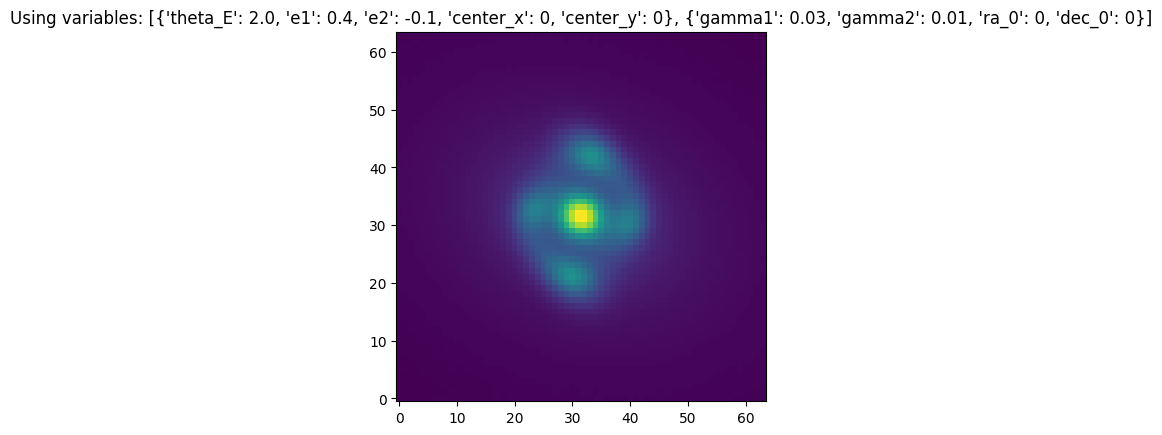

In [10]:
kwargs_lens = [
    {'theta_E': 2., 'e1': 0.4, 'e2': -0.1, 'center_x': 0, 'center_y': 0},  # SIE model
    {'gamma1': 0.03, 'gamma2': 0.01, 'ra_0': 0, 'dec_0': 0}  # SHEAR model
]
image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)

# add noise
image_r += sim_r.noise_for_model(model=image_r)

# and plot it
#for now we just use the r image
img = np.zeros((image_r.shape[0], image_r.shape[1]), dtype=float)
img[:,:] = plot_util.sqrt(image_r, scale_min=0, scale_max=10000)

plt.clf()
plt.imshow(img, aspect='equal', origin='lower')
plt.title('Using variables: {}'.format(kwargs_lens) )
plt.show()


### Random parameters

We take the following boundaries:

theta_E: [1,5]
e1: [-0.95,0.95]
e2:[-0.95,0.95]
center_x : not going to change
center_y:  not going to change
gamma1:[-0.95,0.95]
gamma2:[-0.95,0.95]
ra_0: [-90,90]
dec_0: [-90,90]

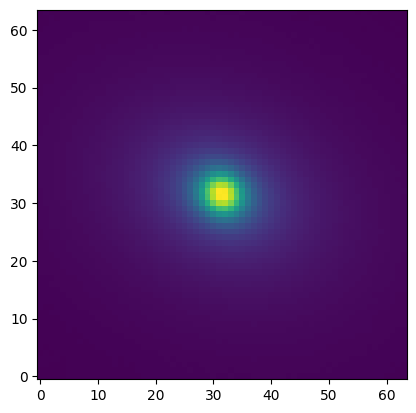

In [11]:
#define parameters
#I made them slightly less complicated
theta_E = round(np.random.uniform(1,5),1) #2
e1 = round(np.random.uniform(-0.5,0.5),1) #0.4
e2 = round(np.random.uniform(-0.5,0.5),1) #-0.1
center_x = 0
center_y = 0
gamma1 = round(np.random.uniform(-0.5,0.5),1)
gamma2 = round(np.random.uniform(-0.5,0.5),1)
ra_0=round(np.random.uniform(-50,50),1)
dec_0=round(np.random.uniform(-50,50),1)

def simulate_SL(theta_E=2, e1=0.4, e2=-0.1, center_x=0, center_y=0, gamma1=0.03, gamma2=0.01, ra_0=0, dec_0 = 0):
    kwargs_lens = [
    {'theta_E': theta_E, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y},  # SIE model
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': ra_0, 'dec_0': 0}  # SHEAR model
    ]
    
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)

    # add noise
    image_r += sim_r.noise_for_model(model=image_r)

    # and plot it
    #for now we just use the r image
    img = np.zeros((image_r.shape[0], image_r.shape[1]), dtype=float)
    img[:,:] = plot_util.sqrt(image_r, scale_min=0, scale_max=10000)

    return(img)

theta_E = 0

img = simulate_SL(theta_E=theta_E, e1=e1, e2=e2, gamma1 = gamma1, gamma2 = gamma2)
plt.clf()
plt.imshow(img, aspect='equal', origin='lower')
#plt.title('Using variables: standard' )
plt.show()




Now we are going to randomize the parameters. We have 7 parameters to play with. We will first change each parameter separately.

#### Theta_E

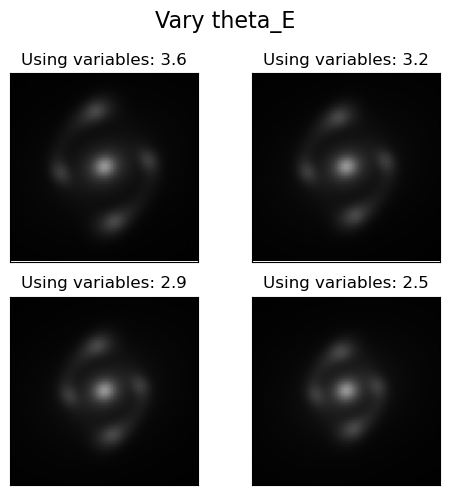

In [65]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

# Plot images in each subplot
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        theta_E = round(np.random.uniform(1,5),1) 
        img = simulate_SL(theta_E =theta_E)
        im = ax.imshow(img)

        # Customize subplot
        ax.set_title('Using variables: {}'.format(theta_E) )
        ax.set_xticks([])
        ax.set_yticks([])

# Add a main title to the entire subplot
fig.suptitle('Vary theta_E', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

theta_E=2.


#### e1 and e2

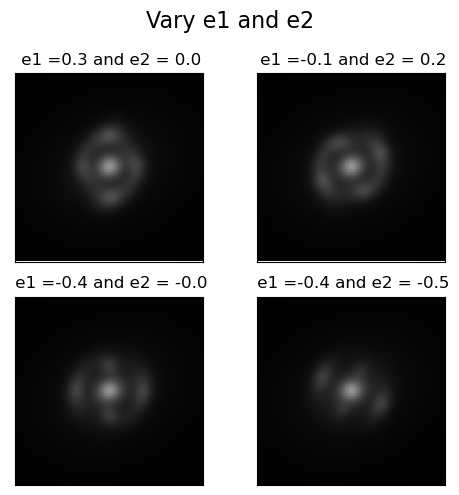

In [66]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

# Plot images in each subplot
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        e1 = round(np.random.uniform(-0.5,0.5),1) #0.4
        e2 = round(np.random.uniform(-0.5,0.5),1) #-0.1
        img = simulate_SL(e1 = e1, e2=e2)
        im = ax.imshow(img)

        # Customize subplot
        ax.set_title(' e1 ={} and e2 = {}'.format(e1, e2) )
        ax.set_xticks([])
        ax.set_yticks([])

# Add a main title to the entire subplot
fig.suptitle('Vary e1 and e2', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

e1 = 0.4
e2 = -0.1

#### gamma1 and gamma2

NameError: name 'simulate_SL' is not defined

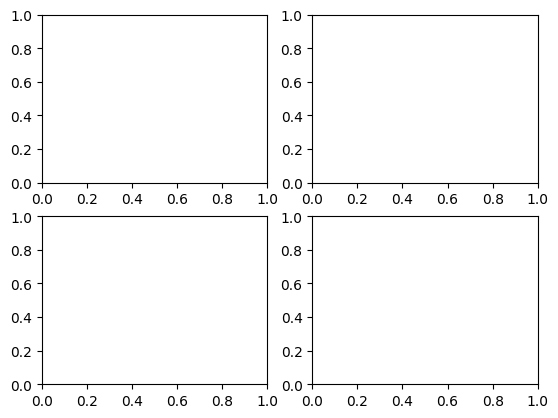

In [9]:

fig, axes = plt.subplots(nrows=2, ncols=2)

# Plot images in each subplot
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        gamma1 = round(np.random.uniform(-0.5,0.5),1) 
        gamma2 = round(np.random.uniform(-0.5,0.5),1) 
        img = simulate_SL(gamma1 = gamma1, gamma2 = gamma2)
        im = ax.imshow(img)

        # Customize subplot
        ax.set_title(' gam1={} and gam2={}'.format(gamma1, gamma2) )
        ax.set_xticks([])
        ax.set_yticks([])

# Add a main title to the entire subplot
fig.suptitle('Vary gamma1 and gamma2', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

gamma1=0.03
gamma2=0.01

#### Ra_0 and Dec_0

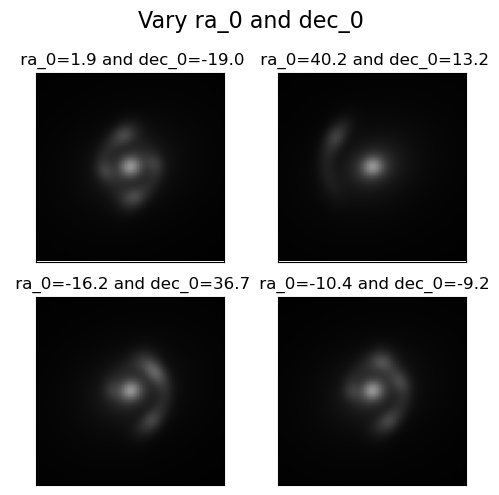

In [68]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

# Plot images in each subplot
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ra_0=round(np.random.uniform(-50,50),1)
        dec_0=round(np.random.uniform(-50,50),1)
        img = simulate_SL(ra_0=ra_0, dec_0 = dec_0)
        im = ax.imshow(img)

        # Customize subplot
        ax.set_title(' ra_0={} and dec_0={}'.format(ra_0, dec_0) )
        ax.set_xticks([])
        ax.set_yticks([])

# Add a main title to the entire subplot
fig.suptitle('Vary ra_0 and dec_0', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

ra_0=0
dec_0=0

## Conclusion experiments

From my experiments I have concluded I will only vary theta_E, e1, e2, gamma1, gamma2, ra_0 and dec_0 withing the boundaries mentioned in this notebook overview. 

## Saving simulations

I will safe 100 images of each type of simulation, so 400 images in total.

In [95]:
from astropy.io import fits
from PIL import Image
import os


### Saving the simulations per parameter

In [98]:

'''
for i in range(100):
    #generate parameter
    theta_E_val = round(np.random.uniform(1,5),1) 

    #simulate image
    im = simulate_SL(theta_E =theta_E_val)

    #plot and save
    plt.figure(figsize=(1,1))
    plt.clf()
    plt.imshow(im, aspect='equal', origin='lower', label = 'plot')
    filename = f'simgal_SL{i}_theta_E.png'
    save_path = f'SL_sim_gal/{filename}'
    print(save_path)
    plt.savefig(save_path)
    plt.show()
    png_image = Image.open(save_path)
    # Convert the PNG image to a NumPy array
    data = np.array(png_image)

# Create a FITS header
    header = fits.Header()
    header['COMMENT'] = 'Converted from PNG to FITS'

# Create a FITS HDU (Header/Data Unit)
    hdu = fits.PrimaryHDU(data, header=header)

# Specify the path for saving the FITS file
    filename = f'simgal_SL{i}_theta_E.fits'
    fits_path = f'SL_sim_gal/{filename}'

# Write the FITS file
    hdu.writeto(fits_path, overwrite=True)

    if os.path.exists(save_path):
        # Delete the file
        os.remove(save_path)

    
theta_E = 2.



'''

"\nfor i in range(100):\n    #generate parameter\n    theta_E_val = round(np.random.uniform(1,5),1) \n\n    #simulate image\n    im = simulate_SL(theta_E =theta_E_val)\n\n    #plot and save\n    plt.figure(figsize=(1,1))\n    plt.clf()\n    plt.imshow(im, aspect='equal', origin='lower', label = 'plot')\n    filename = f'simgal_SL{i}_theta_E.png'\n    save_path = f'SL_sim_gal/{filename}'\n    print(save_path)\n    plt.savefig(save_path)\n    plt.show()\n    png_image = Image.open(save_path)\n    # Convert the PNG image to a NumPy array\n    data = np.array(png_image)\n\n# Create a FITS header\n    header = fits.Header()\n    header['COMMENT'] = 'Converted from PNG to FITS'\n\n# Create a FITS HDU (Header/Data Unit)\n    hdu = fits.PrimaryHDU(data, header=header)\n\n# Specify the path for saving the FITS file\n    filename = f'simgal_SL{i}_theta_E.fits'\n    fits_path = f'SL_sim_gal/{filename}'\n\n# Write the FITS file\n    hdu.writeto(fits_path, overwrite=True)\n\n    if os.path.exists(s

In [97]:
'''
for i in range(100):
    #generate parameter
    e1 = round(np.random.uniform(-0.5,0.5),1) 
    e2 = round(np.random.uniform(-0.5,0.5),1) 

    #simulate image
    im = simulate_SL(e1=e1, e2=e2)

    #plot and save
    plt.figure(figsize=(1,1))
    plt.clf()
    plt.imshow(im, aspect='equal', origin='lower', label = 'plot')
    filename = f'simgal_SL{i}_e1_e2.png'
    save_path = f'SL_sim_gal/{filename}'
    print(save_path)
    plt.savefig(save_path)
    plt.show()
    png_image = Image.open(save_path)
    # Convert the PNG image to a NumPy array
    data = np.array(png_image)

# Create a FITS header
    header = fits.Header()
    header['COMMENT'] = 'Converted from PNG to FITS'

# Create a FITS HDU (Header/Data Unit)
    hdu = fits.PrimaryHDU(data, header=header)

# Specify the path for saving the FITS file
    filename = f'simgal_SL{i}_e1_e2.fits'
    fits_path = f'SL_sim_gal/{filename}'

# Write the FITS file
    hdu.writeto(fits_path, overwrite=True)

    if os.path.exists(save_path):
        # Delete the file
        os.remove(save_path)


e1 = 0.4
e2 = -0.1
'''

"\nfor i in range(100):\n    #generate parameter\n    e1 = round(np.random.uniform(-0.5,0.5),1) \n    e2 = round(np.random.uniform(-0.5,0.5),1) \n\n    #simulate image\n    im = simulate_SL(e1=e1, e2=e2)\n\n    #plot and save\n    plt.figure(figsize=(1,1))\n    plt.clf()\n    plt.imshow(im, aspect='equal', origin='lower', label = 'plot')\n    filename = f'simgal_SL{i}_e1_e2.png'\n    save_path = f'SL_sim_gal/{filename}'\n    print(save_path)\n    plt.savefig(save_path)\n    plt.show()\n    png_image = Image.open(save_path)\n    # Convert the PNG image to a NumPy array\n    data = np.array(png_image)\n\n# Create a FITS header\n    header = fits.Header()\n    header['COMMENT'] = 'Converted from PNG to FITS'\n\n# Create a FITS HDU (Header/Data Unit)\n    hdu = fits.PrimaryHDU(data, header=header)\n\n# Specify the path for saving the FITS file\n    filename = f'simgal_SL{i}_e1_e2.fits'\n    fits_path = f'SL_sim_gal/{filename}'\n\n# Write the FITS file\n    hdu.writeto(fits_path, overwrite=

SL_sim_gal/simgal_SL0_gamma1_gamma2.png


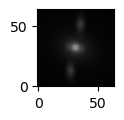

SL_sim_gal/simgal_SL1_gamma1_gamma2.png


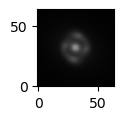

SL_sim_gal/simgal_SL2_gamma1_gamma2.png


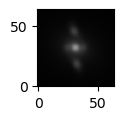

SL_sim_gal/simgal_SL3_gamma1_gamma2.png


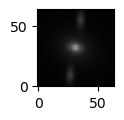

SL_sim_gal/simgal_SL4_gamma1_gamma2.png


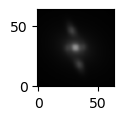

SL_sim_gal/simgal_SL5_gamma1_gamma2.png


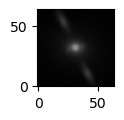

SL_sim_gal/simgal_SL6_gamma1_gamma2.png


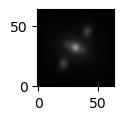

SL_sim_gal/simgal_SL7_gamma1_gamma2.png


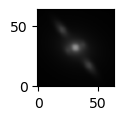

SL_sim_gal/simgal_SL8_gamma1_gamma2.png


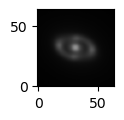

SL_sim_gal/simgal_SL9_gamma1_gamma2.png


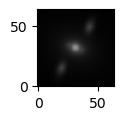

SL_sim_gal/simgal_SL10_gamma1_gamma2.png


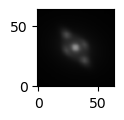

SL_sim_gal/simgal_SL11_gamma1_gamma2.png


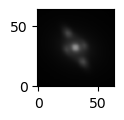

SL_sim_gal/simgal_SL12_gamma1_gamma2.png


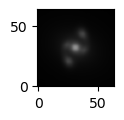

SL_sim_gal/simgal_SL13_gamma1_gamma2.png


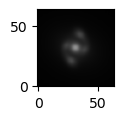

SL_sim_gal/simgal_SL14_gamma1_gamma2.png


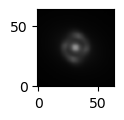

SL_sim_gal/simgal_SL15_gamma1_gamma2.png


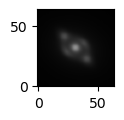

SL_sim_gal/simgal_SL16_gamma1_gamma2.png


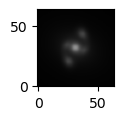

SL_sim_gal/simgal_SL17_gamma1_gamma2.png


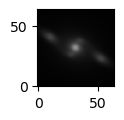

SL_sim_gal/simgal_SL18_gamma1_gamma2.png


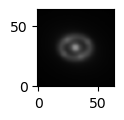

SL_sim_gal/simgal_SL19_gamma1_gamma2.png


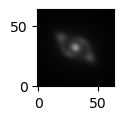

SL_sim_gal/simgal_SL20_gamma1_gamma2.png


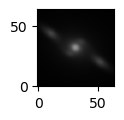

SL_sim_gal/simgal_SL21_gamma1_gamma2.png


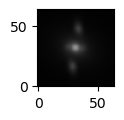

SL_sim_gal/simgal_SL22_gamma1_gamma2.png


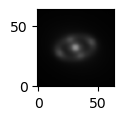

SL_sim_gal/simgal_SL23_gamma1_gamma2.png


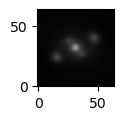

SL_sim_gal/simgal_SL24_gamma1_gamma2.png


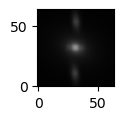

SL_sim_gal/simgal_SL25_gamma1_gamma2.png


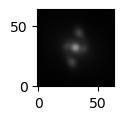

SL_sim_gal/simgal_SL26_gamma1_gamma2.png


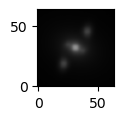

SL_sim_gal/simgal_SL27_gamma1_gamma2.png


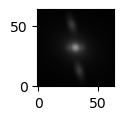

SL_sim_gal/simgal_SL28_gamma1_gamma2.png


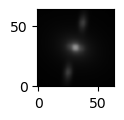

SL_sim_gal/simgal_SL29_gamma1_gamma2.png


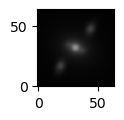

SL_sim_gal/simgal_SL30_gamma1_gamma2.png


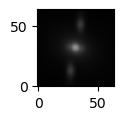

SL_sim_gal/simgal_SL31_gamma1_gamma2.png


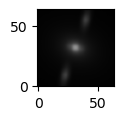

SL_sim_gal/simgal_SL32_gamma1_gamma2.png


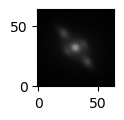

SL_sim_gal/simgal_SL33_gamma1_gamma2.png


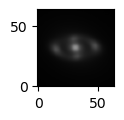

SL_sim_gal/simgal_SL34_gamma1_gamma2.png


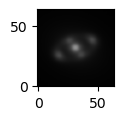

SL_sim_gal/simgal_SL35_gamma1_gamma2.png


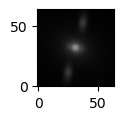

SL_sim_gal/simgal_SL36_gamma1_gamma2.png


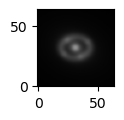

SL_sim_gal/simgal_SL37_gamma1_gamma2.png


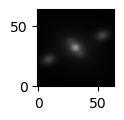

SL_sim_gal/simgal_SL38_gamma1_gamma2.png


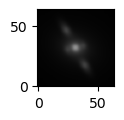

SL_sim_gal/simgal_SL39_gamma1_gamma2.png


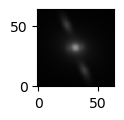

SL_sim_gal/simgal_SL40_gamma1_gamma2.png


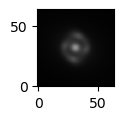

SL_sim_gal/simgal_SL41_gamma1_gamma2.png


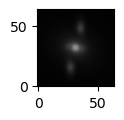

SL_sim_gal/simgal_SL42_gamma1_gamma2.png


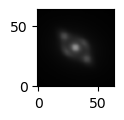

SL_sim_gal/simgal_SL43_gamma1_gamma2.png


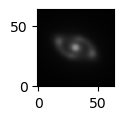

SL_sim_gal/simgal_SL44_gamma1_gamma2.png


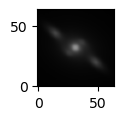

SL_sim_gal/simgal_SL45_gamma1_gamma2.png


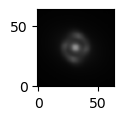

SL_sim_gal/simgal_SL46_gamma1_gamma2.png


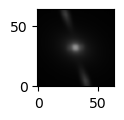

SL_sim_gal/simgal_SL47_gamma1_gamma2.png


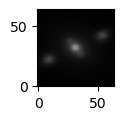

SL_sim_gal/simgal_SL48_gamma1_gamma2.png


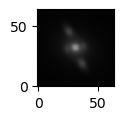

SL_sim_gal/simgal_SL49_gamma1_gamma2.png


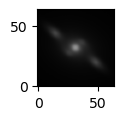

SL_sim_gal/simgal_SL50_gamma1_gamma2.png


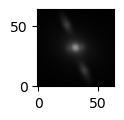

SL_sim_gal/simgal_SL51_gamma1_gamma2.png


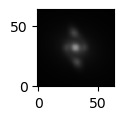

SL_sim_gal/simgal_SL52_gamma1_gamma2.png


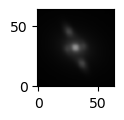

SL_sim_gal/simgal_SL53_gamma1_gamma2.png


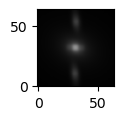

SL_sim_gal/simgal_SL54_gamma1_gamma2.png


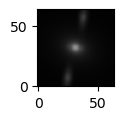

SL_sim_gal/simgal_SL55_gamma1_gamma2.png


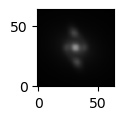

SL_sim_gal/simgal_SL56_gamma1_gamma2.png


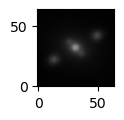

SL_sim_gal/simgal_SL57_gamma1_gamma2.png


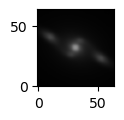

SL_sim_gal/simgal_SL58_gamma1_gamma2.png


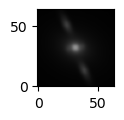

SL_sim_gal/simgal_SL59_gamma1_gamma2.png


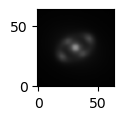

SL_sim_gal/simgal_SL60_gamma1_gamma2.png


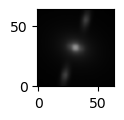

SL_sim_gal/simgal_SL61_gamma1_gamma2.png


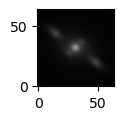

SL_sim_gal/simgal_SL62_gamma1_gamma2.png


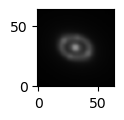

SL_sim_gal/simgal_SL63_gamma1_gamma2.png


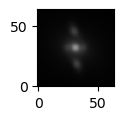

SL_sim_gal/simgal_SL64_gamma1_gamma2.png


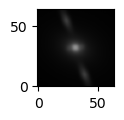

SL_sim_gal/simgal_SL65_gamma1_gamma2.png


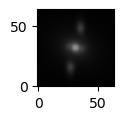

SL_sim_gal/simgal_SL66_gamma1_gamma2.png


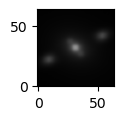

SL_sim_gal/simgal_SL67_gamma1_gamma2.png


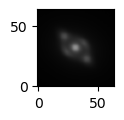

SL_sim_gal/simgal_SL68_gamma1_gamma2.png


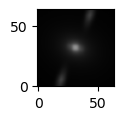

SL_sim_gal/simgal_SL69_gamma1_gamma2.png


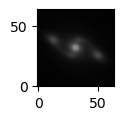

SL_sim_gal/simgal_SL70_gamma1_gamma2.png


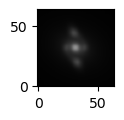

SL_sim_gal/simgal_SL71_gamma1_gamma2.png


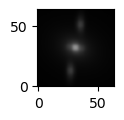

SL_sim_gal/simgal_SL72_gamma1_gamma2.png


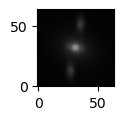

SL_sim_gal/simgal_SL73_gamma1_gamma2.png


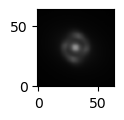

SL_sim_gal/simgal_SL74_gamma1_gamma2.png


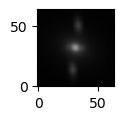

SL_sim_gal/simgal_SL75_gamma1_gamma2.png


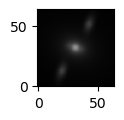

SL_sim_gal/simgal_SL76_gamma1_gamma2.png


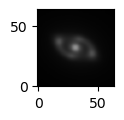

SL_sim_gal/simgal_SL77_gamma1_gamma2.png


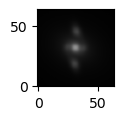

SL_sim_gal/simgal_SL78_gamma1_gamma2.png


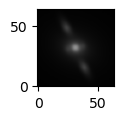

SL_sim_gal/simgal_SL79_gamma1_gamma2.png


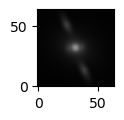

SL_sim_gal/simgal_SL80_gamma1_gamma2.png


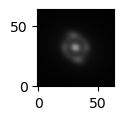

SL_sim_gal/simgal_SL81_gamma1_gamma2.png


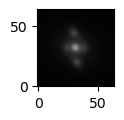

SL_sim_gal/simgal_SL82_gamma1_gamma2.png


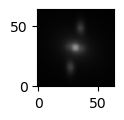

SL_sim_gal/simgal_SL83_gamma1_gamma2.png


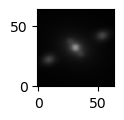

SL_sim_gal/simgal_SL84_gamma1_gamma2.png


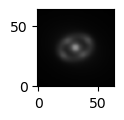

SL_sim_gal/simgal_SL85_gamma1_gamma2.png


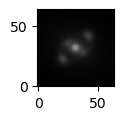

SL_sim_gal/simgal_SL86_gamma1_gamma2.png


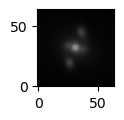

SL_sim_gal/simgal_SL87_gamma1_gamma2.png


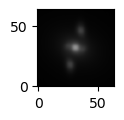

SL_sim_gal/simgal_SL88_gamma1_gamma2.png


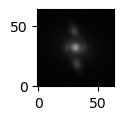

SL_sim_gal/simgal_SL89_gamma1_gamma2.png


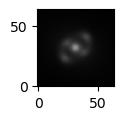

SL_sim_gal/simgal_SL90_gamma1_gamma2.png


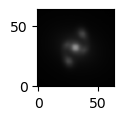

SL_sim_gal/simgal_SL91_gamma1_gamma2.png


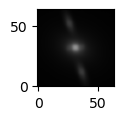

SL_sim_gal/simgal_SL92_gamma1_gamma2.png


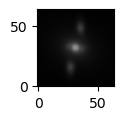

SL_sim_gal/simgal_SL93_gamma1_gamma2.png


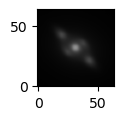

SL_sim_gal/simgal_SL94_gamma1_gamma2.png


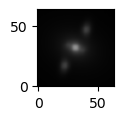

SL_sim_gal/simgal_SL95_gamma1_gamma2.png


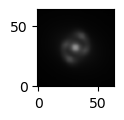

SL_sim_gal/simgal_SL96_gamma1_gamma2.png


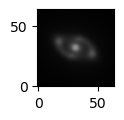

SL_sim_gal/simgal_SL97_gamma1_gamma2.png


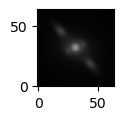

SL_sim_gal/simgal_SL98_gamma1_gamma2.png


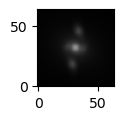

SL_sim_gal/simgal_SL99_gamma1_gamma2.png


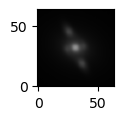

In [99]:
'''
for i in range(100):
    #generate parameter
    gamma1 = round(np.random.uniform(-0.5,0.5),1) 
    gamma2 = round(np.random.uniform(-0.5,0.5),1)  

    #simulate image
    im = simulate_SL(gamma1 = gamma1, gamma2 = gamma2)

    #plot and save
    plt.figure(figsize=(1,1))
    plt.clf()
    plt.imshow(im, aspect='equal', origin='lower', label = 'plot')
    filename = f'simgal_SL{i}_gamma1_gamma2.png'
    save_path = f'SL_sim_gal/{filename}'
    print(save_path)
    plt.savefig(save_path)
    plt.show()
    png_image = Image.open(save_path)
    # Convert the PNG image to a NumPy array
    data = np.array(png_image)

# Create a FITS header
    header = fits.Header()
    header['COMMENT'] = 'Converted from PNG to FITS'

# Create a FITS HDU (Header/Data Unit)
    hdu = fits.PrimaryHDU(data, header=header)

# Specify the path for saving the FITS file
    filename = f'simgal_SL{i}_gamma1_gamma2.fits'
    fits_path = f'SL_sim_gal/{filename}'

# Write the FITS file
    hdu.writeto(fits_path, overwrite=True)

    if os.path.exists(save_path):
        # Delete the file
        os.remove(save_path)


gamma1 = 0.03
gamma2 = 0.01
'''

SL_sim_gal/simgal_SL0_ra_0_dec_0.png


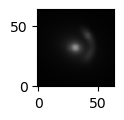

SL_sim_gal/simgal_SL1_ra_0_dec_0.png


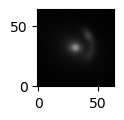

SL_sim_gal/simgal_SL2_ra_0_dec_0.png


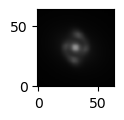

SL_sim_gal/simgal_SL3_ra_0_dec_0.png


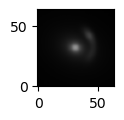

SL_sim_gal/simgal_SL4_ra_0_dec_0.png


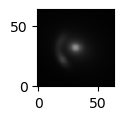

SL_sim_gal/simgal_SL5_ra_0_dec_0.png


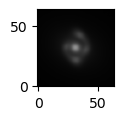

SL_sim_gal/simgal_SL6_ra_0_dec_0.png


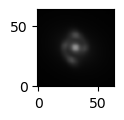

SL_sim_gal/simgal_SL7_ra_0_dec_0.png


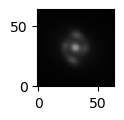

SL_sim_gal/simgal_SL8_ra_0_dec_0.png


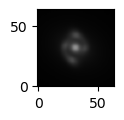

SL_sim_gal/simgal_SL9_ra_0_dec_0.png


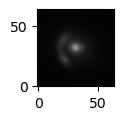

SL_sim_gal/simgal_SL10_ra_0_dec_0.png


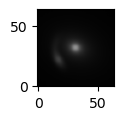

SL_sim_gal/simgal_SL11_ra_0_dec_0.png


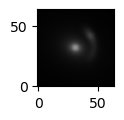

SL_sim_gal/simgal_SL12_ra_0_dec_0.png


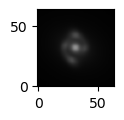

SL_sim_gal/simgal_SL13_ra_0_dec_0.png


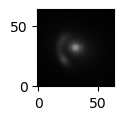

SL_sim_gal/simgal_SL14_ra_0_dec_0.png


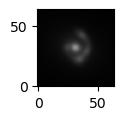

SL_sim_gal/simgal_SL15_ra_0_dec_0.png


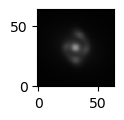

SL_sim_gal/simgal_SL16_ra_0_dec_0.png


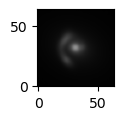

SL_sim_gal/simgal_SL17_ra_0_dec_0.png


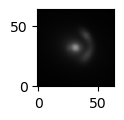

SL_sim_gal/simgal_SL18_ra_0_dec_0.png


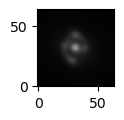

SL_sim_gal/simgal_SL19_ra_0_dec_0.png


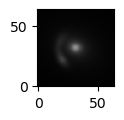

SL_sim_gal/simgal_SL20_ra_0_dec_0.png


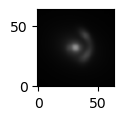

SL_sim_gal/simgal_SL21_ra_0_dec_0.png


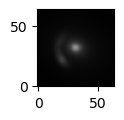

SL_sim_gal/simgal_SL22_ra_0_dec_0.png


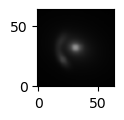

SL_sim_gal/simgal_SL23_ra_0_dec_0.png


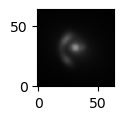

SL_sim_gal/simgal_SL24_ra_0_dec_0.png


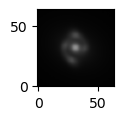

SL_sim_gal/simgal_SL25_ra_0_dec_0.png


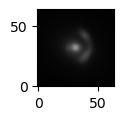

SL_sim_gal/simgal_SL26_ra_0_dec_0.png


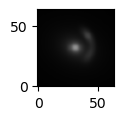

SL_sim_gal/simgal_SL27_ra_0_dec_0.png


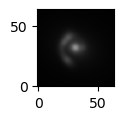

SL_sim_gal/simgal_SL28_ra_0_dec_0.png


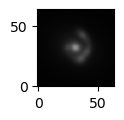

SL_sim_gal/simgal_SL29_ra_0_dec_0.png


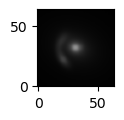

SL_sim_gal/simgal_SL30_ra_0_dec_0.png


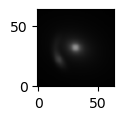

SL_sim_gal/simgal_SL31_ra_0_dec_0.png


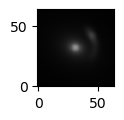

SL_sim_gal/simgal_SL32_ra_0_dec_0.png


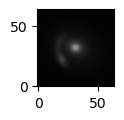

SL_sim_gal/simgal_SL33_ra_0_dec_0.png


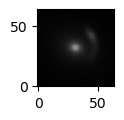

SL_sim_gal/simgal_SL34_ra_0_dec_0.png


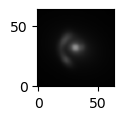

SL_sim_gal/simgal_SL35_ra_0_dec_0.png


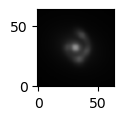

SL_sim_gal/simgal_SL36_ra_0_dec_0.png


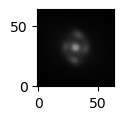

SL_sim_gal/simgal_SL37_ra_0_dec_0.png


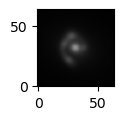

SL_sim_gal/simgal_SL38_ra_0_dec_0.png


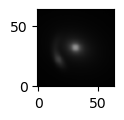

SL_sim_gal/simgal_SL39_ra_0_dec_0.png


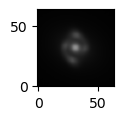

SL_sim_gal/simgal_SL40_ra_0_dec_0.png


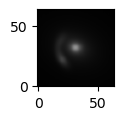

SL_sim_gal/simgal_SL41_ra_0_dec_0.png


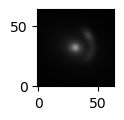

SL_sim_gal/simgal_SL42_ra_0_dec_0.png


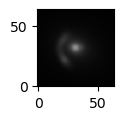

SL_sim_gal/simgal_SL43_ra_0_dec_0.png


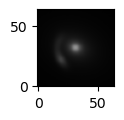

SL_sim_gal/simgal_SL44_ra_0_dec_0.png


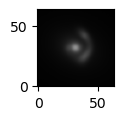

SL_sim_gal/simgal_SL45_ra_0_dec_0.png


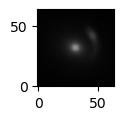

SL_sim_gal/simgal_SL46_ra_0_dec_0.png


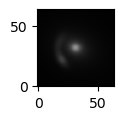

SL_sim_gal/simgal_SL47_ra_0_dec_0.png


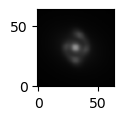

SL_sim_gal/simgal_SL48_ra_0_dec_0.png


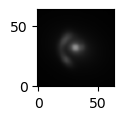

SL_sim_gal/simgal_SL49_ra_0_dec_0.png


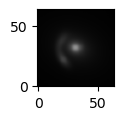

SL_sim_gal/simgal_SL50_ra_0_dec_0.png


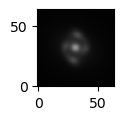

SL_sim_gal/simgal_SL51_ra_0_dec_0.png


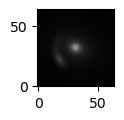

SL_sim_gal/simgal_SL52_ra_0_dec_0.png


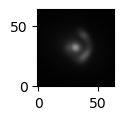

SL_sim_gal/simgal_SL53_ra_0_dec_0.png


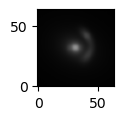

SL_sim_gal/simgal_SL54_ra_0_dec_0.png


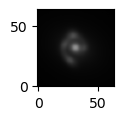

SL_sim_gal/simgal_SL55_ra_0_dec_0.png


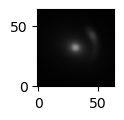

SL_sim_gal/simgal_SL56_ra_0_dec_0.png


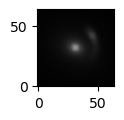

SL_sim_gal/simgal_SL57_ra_0_dec_0.png


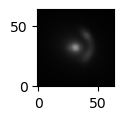

SL_sim_gal/simgal_SL58_ra_0_dec_0.png


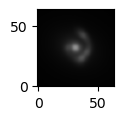

SL_sim_gal/simgal_SL59_ra_0_dec_0.png


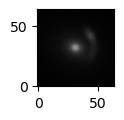

SL_sim_gal/simgal_SL60_ra_0_dec_0.png


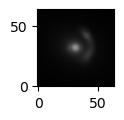

SL_sim_gal/simgal_SL61_ra_0_dec_0.png


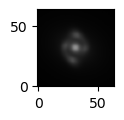

SL_sim_gal/simgal_SL62_ra_0_dec_0.png


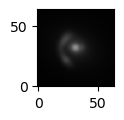

SL_sim_gal/simgal_SL63_ra_0_dec_0.png


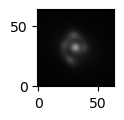

SL_sim_gal/simgal_SL64_ra_0_dec_0.png


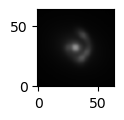

SL_sim_gal/simgal_SL65_ra_0_dec_0.png


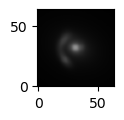

SL_sim_gal/simgal_SL66_ra_0_dec_0.png


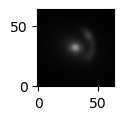

SL_sim_gal/simgal_SL67_ra_0_dec_0.png


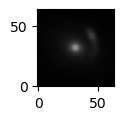

SL_sim_gal/simgal_SL68_ra_0_dec_0.png


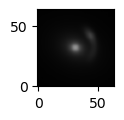

SL_sim_gal/simgal_SL69_ra_0_dec_0.png


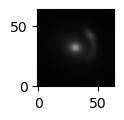

SL_sim_gal/simgal_SL70_ra_0_dec_0.png


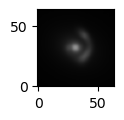

SL_sim_gal/simgal_SL71_ra_0_dec_0.png


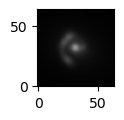

SL_sim_gal/simgal_SL72_ra_0_dec_0.png


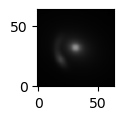

SL_sim_gal/simgal_SL73_ra_0_dec_0.png


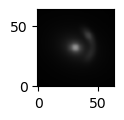

SL_sim_gal/simgal_SL74_ra_0_dec_0.png


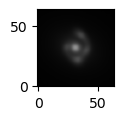

SL_sim_gal/simgal_SL75_ra_0_dec_0.png


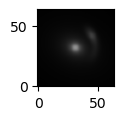

SL_sim_gal/simgal_SL76_ra_0_dec_0.png


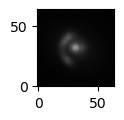

SL_sim_gal/simgal_SL77_ra_0_dec_0.png


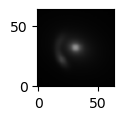

SL_sim_gal/simgal_SL78_ra_0_dec_0.png


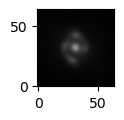

SL_sim_gal/simgal_SL79_ra_0_dec_0.png


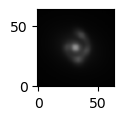

SL_sim_gal/simgal_SL80_ra_0_dec_0.png


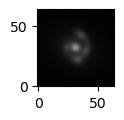

SL_sim_gal/simgal_SL81_ra_0_dec_0.png


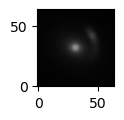

SL_sim_gal/simgal_SL82_ra_0_dec_0.png


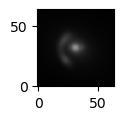

SL_sim_gal/simgal_SL83_ra_0_dec_0.png


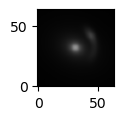

SL_sim_gal/simgal_SL84_ra_0_dec_0.png


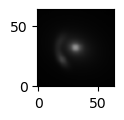

SL_sim_gal/simgal_SL85_ra_0_dec_0.png


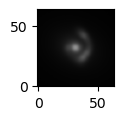

SL_sim_gal/simgal_SL86_ra_0_dec_0.png


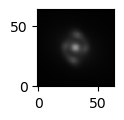

SL_sim_gal/simgal_SL87_ra_0_dec_0.png


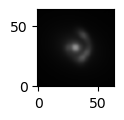

SL_sim_gal/simgal_SL88_ra_0_dec_0.png


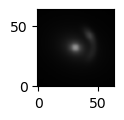

SL_sim_gal/simgal_SL89_ra_0_dec_0.png


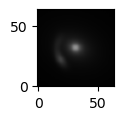

SL_sim_gal/simgal_SL90_ra_0_dec_0.png


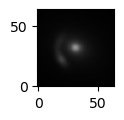

SL_sim_gal/simgal_SL91_ra_0_dec_0.png


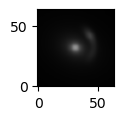

SL_sim_gal/simgal_SL92_ra_0_dec_0.png


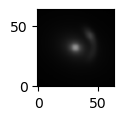

SL_sim_gal/simgal_SL93_ra_0_dec_0.png


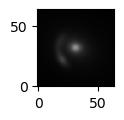

SL_sim_gal/simgal_SL94_ra_0_dec_0.png


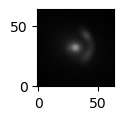

SL_sim_gal/simgal_SL95_ra_0_dec_0.png


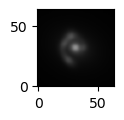

SL_sim_gal/simgal_SL96_ra_0_dec_0.png


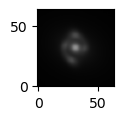

SL_sim_gal/simgal_SL97_ra_0_dec_0.png


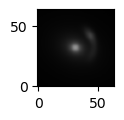

SL_sim_gal/simgal_SL98_ra_0_dec_0.png


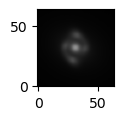

SL_sim_gal/simgal_SL99_ra_0_dec_0.png


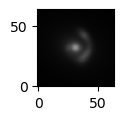

In [100]:

'''

for i in range(100):
    #generate parameter
    ra_0=round(np.random.uniform(-50,50),1)
    dec_0=round(np.random.uniform(-50,50),1) 

    #simulate image
    im = simulate_SL(ra_0 =ra_0, dec_0 = dec_0)

    #plot and save
    plt.figure(figsize=(1,1))
    plt.clf()
    plt.imshow(im, aspect='equal', origin='lower', label = 'plot')
    filename = f'simgal_SL{i}_ra_0_dec_0.png'
    save_path = f'SL_sim_gal/{filename}'
    print(save_path)
    plt.savefig(save_path)
    plt.show()
    png_image = Image.open(save_path)
    # Convert the PNG image to a NumPy array
    data = np.array(png_image)

# Create a FITS header
    header = fits.Header()
    header['COMMENT'] = 'Converted from PNG to FITS'

# Create a FITS HDU (Header/Data Unit)
    hdu = fits.PrimaryHDU(data, header=header)

# Specify the path for saving the FITS file
    filename = f'simgal_SL{i}_ra0_dec0.fits'
    fits_path = f'SL_sim_gal/{filename}'

# Write the FITS file
    hdu.writeto(fits_path, overwrite=True)

    if os.path.exists(save_path):
        # Delete the file
        os.remove(save_path)

        

ra_0 = 0
dec_0 = 0
'''

## Simulating with random parameters

SL_sim_gal2/SL0.png


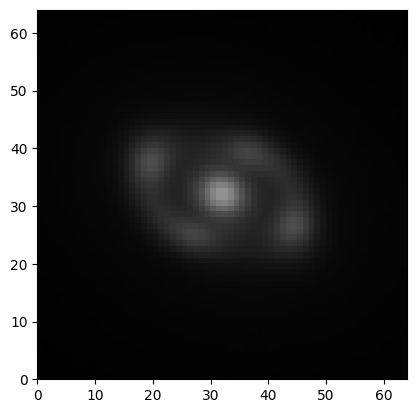

SL_sim_gal2/SL1.png


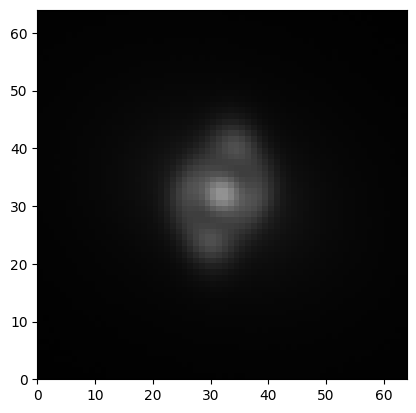

SL_sim_gal2/SL2.png


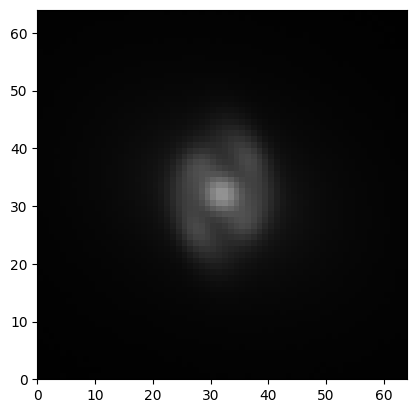

SL_sim_gal2/SL3.png


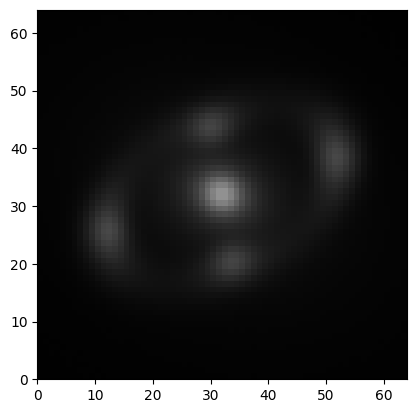

SL_sim_gal2/SL4.png


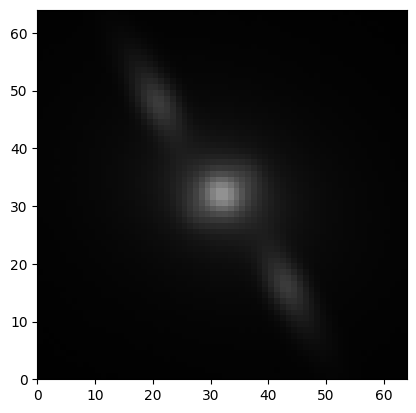

SL_sim_gal2/SL5.png


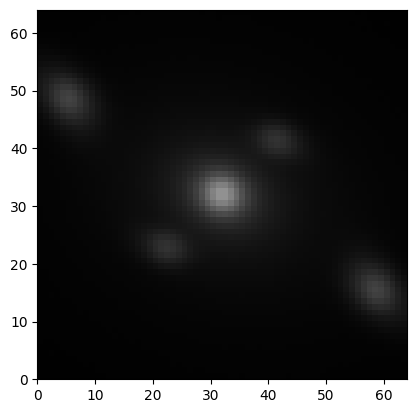

SL_sim_gal2/SL6.png


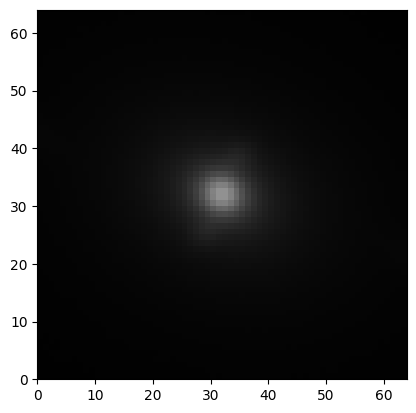

SL_sim_gal2/SL7.png


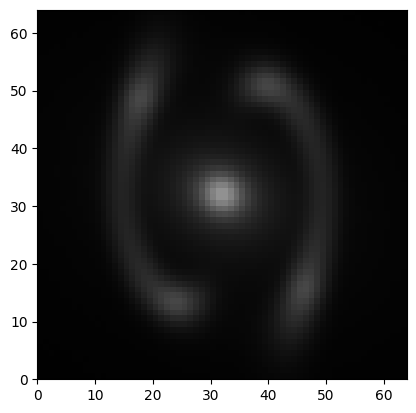

SL_sim_gal2/SL8.png


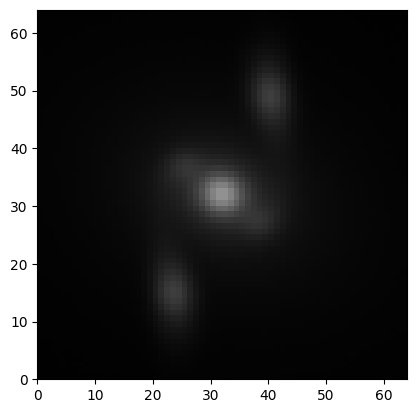

SL_sim_gal2/SL9.png


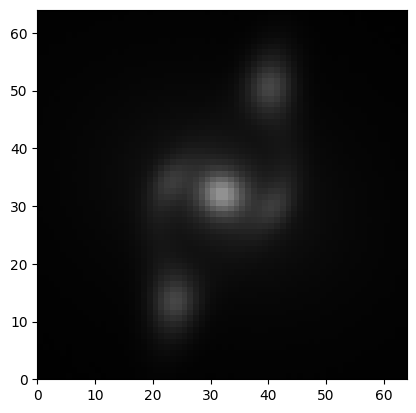

SL_sim_gal2/SL10.png


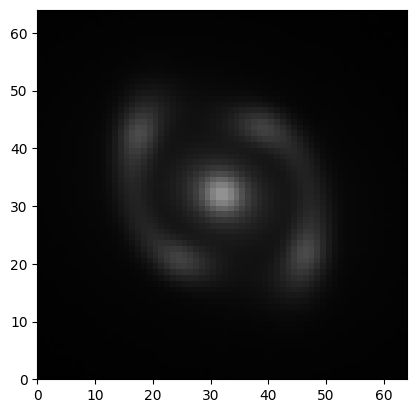

SL_sim_gal2/SL11.png


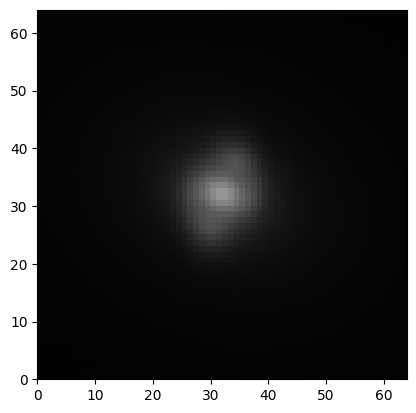

SL_sim_gal2/SL12.png


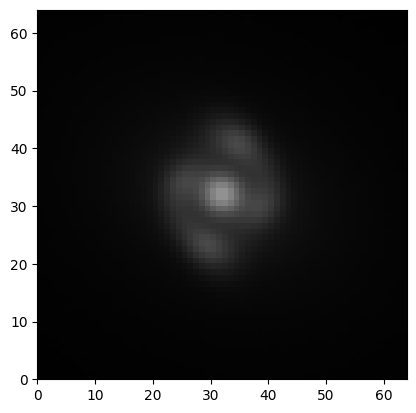

SL_sim_gal2/SL13.png


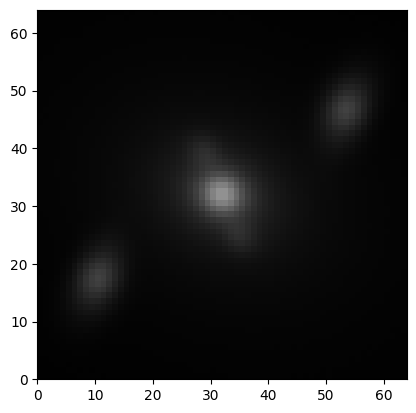

SL_sim_gal2/SL14.png


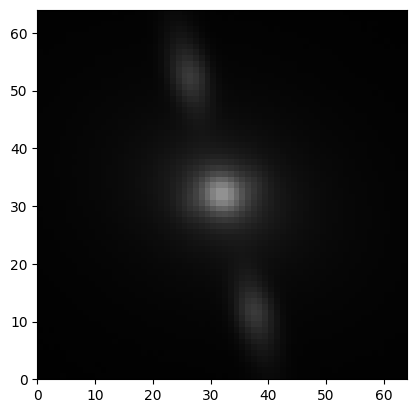

SL_sim_gal2/SL15.png


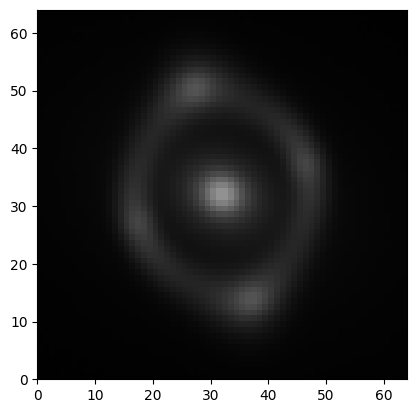

SL_sim_gal2/SL16.png


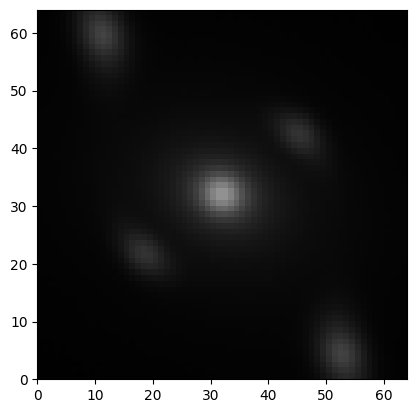

SL_sim_gal2/SL17.png


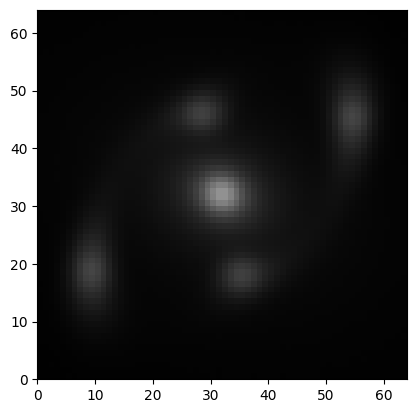

SL_sim_gal2/SL18.png


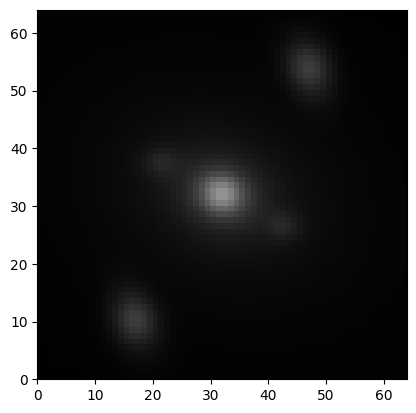

SL_sim_gal2/SL19.png


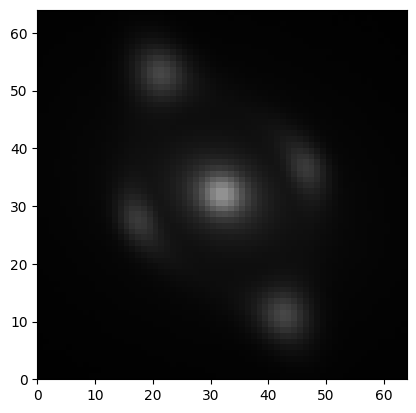

SL_sim_gal2/SL20.png


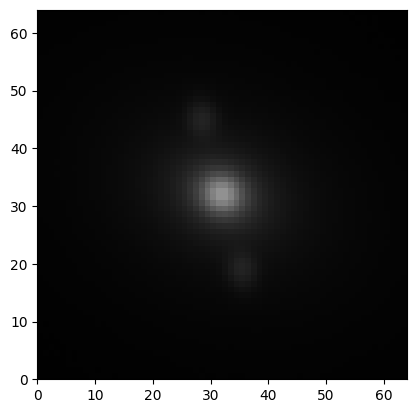

SL_sim_gal2/SL21.png


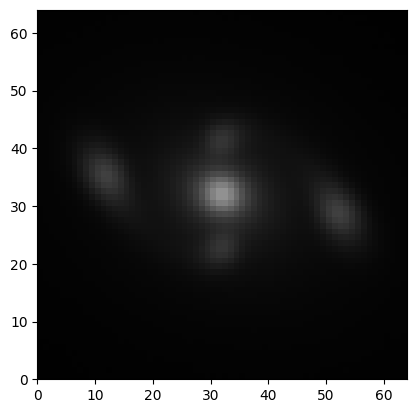

SL_sim_gal2/SL22.png


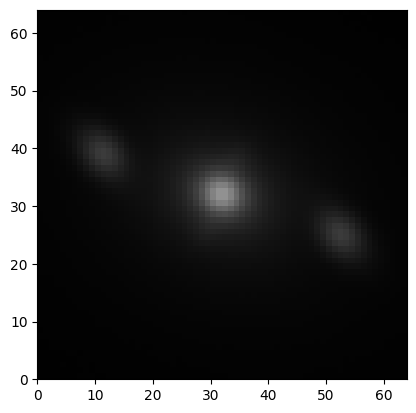

SL_sim_gal2/SL23.png


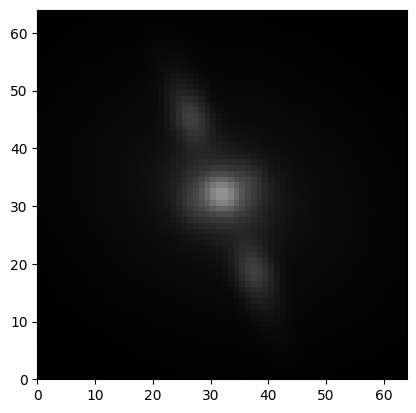

SL_sim_gal2/SL24.png


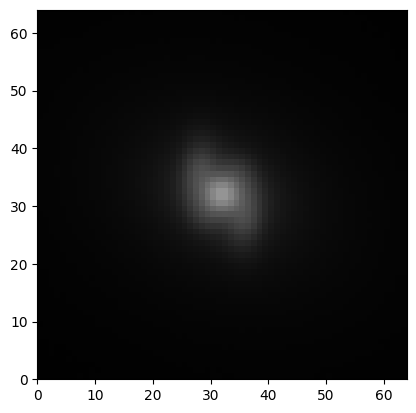

SL_sim_gal2/SL25.png


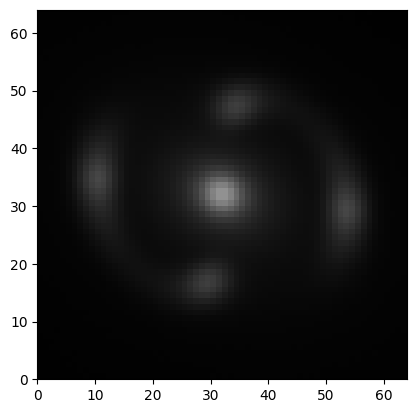

SL_sim_gal2/SL26.png


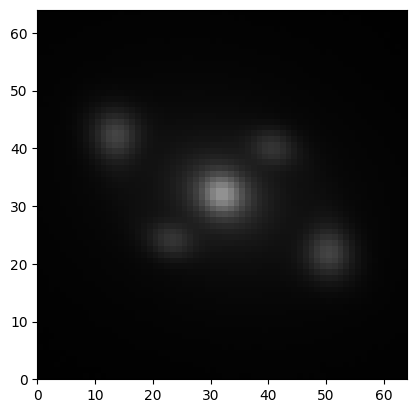

SL_sim_gal2/SL27.png


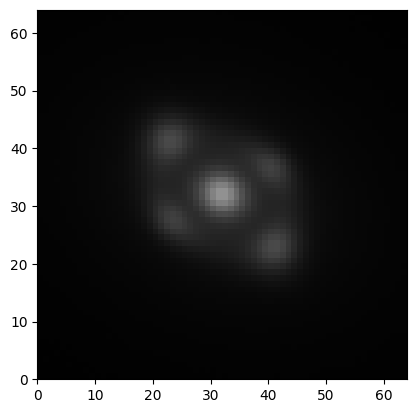

SL_sim_gal2/SL28.png


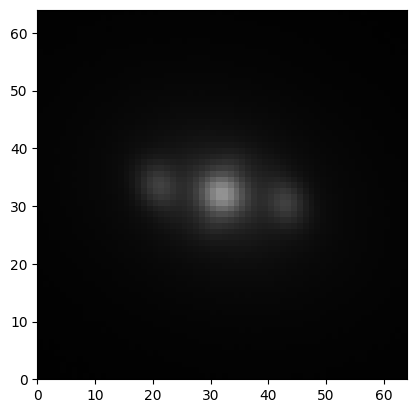

SL_sim_gal2/SL29.png


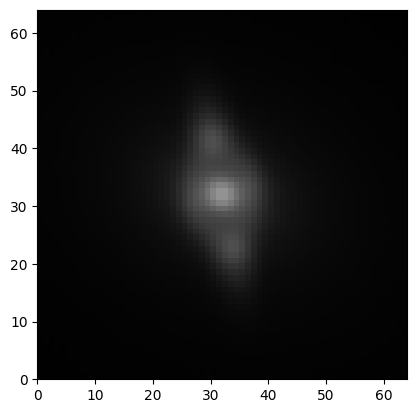

SL_sim_gal2/SL30.png


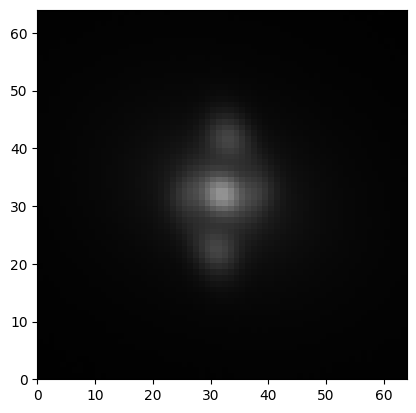

SL_sim_gal2/SL31.png


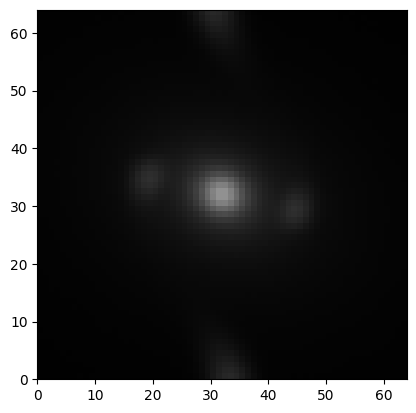

SL_sim_gal2/SL32.png


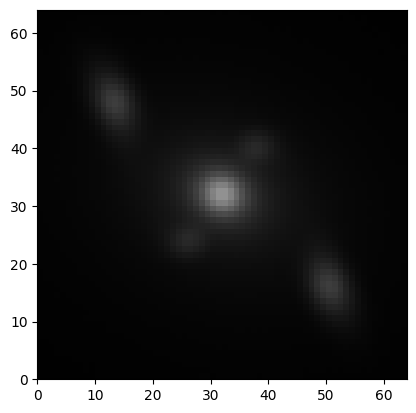

SL_sim_gal2/SL33.png


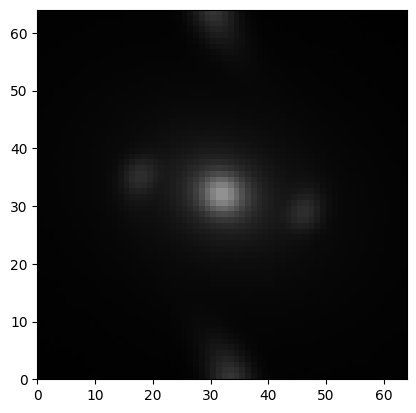

SL_sim_gal2/SL34.png


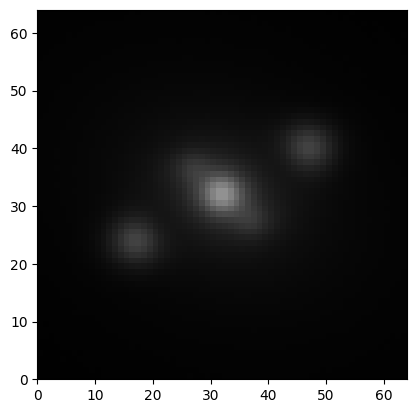

SL_sim_gal2/SL35.png


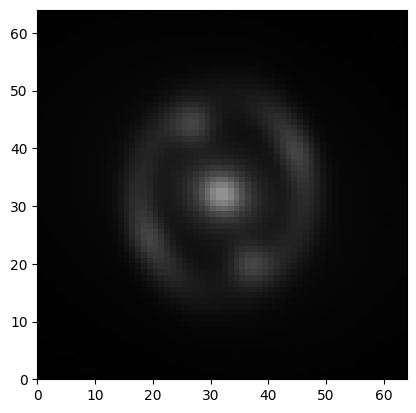

SL_sim_gal2/SL36.png


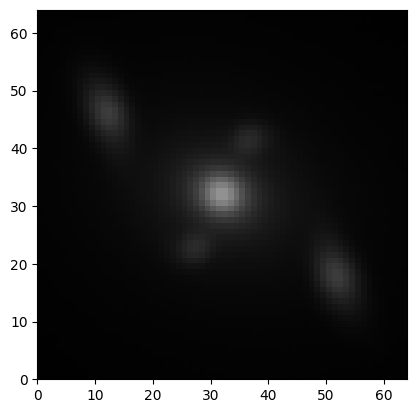

SL_sim_gal2/SL37.png


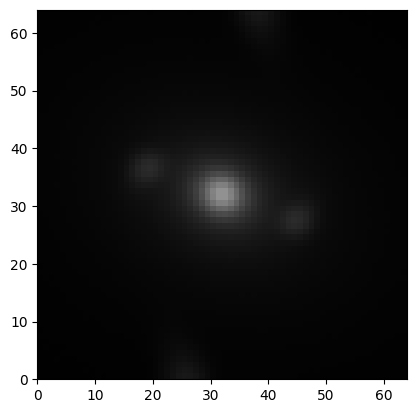

SL_sim_gal2/SL38.png


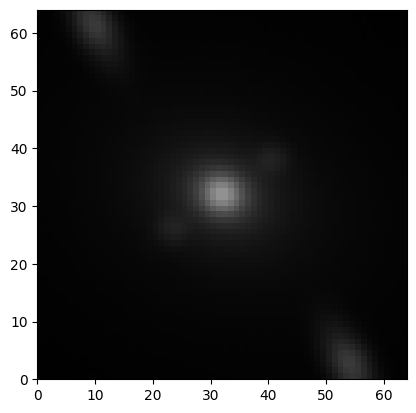

SL_sim_gal2/SL39.png


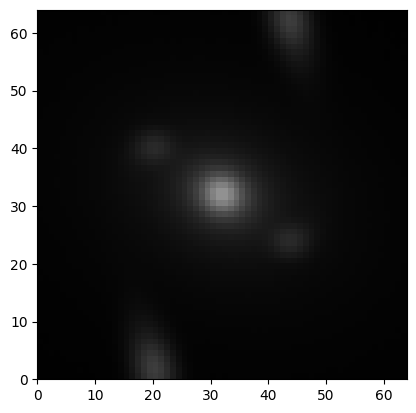

SL_sim_gal2/SL40.png


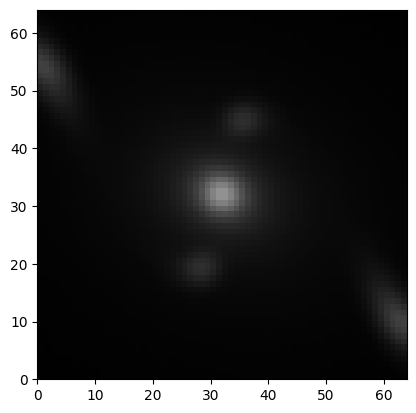

SL_sim_gal2/SL41.png


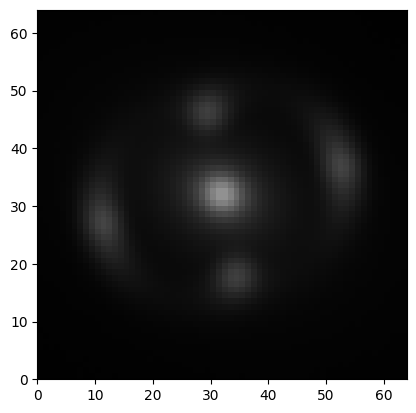

SL_sim_gal2/SL42.png


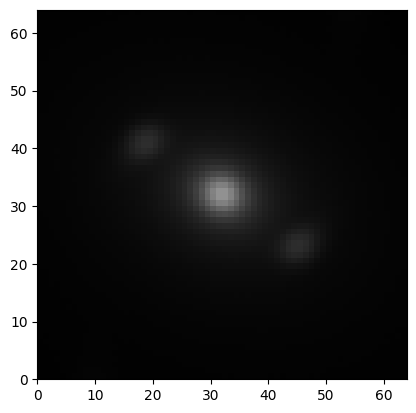

SL_sim_gal2/SL43.png


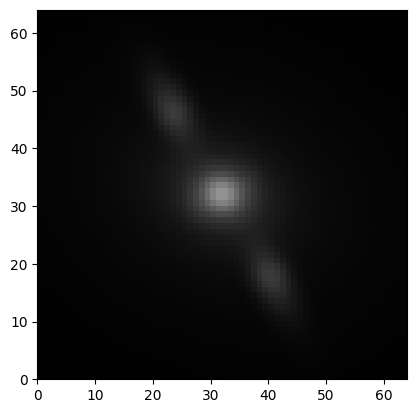

SL_sim_gal2/SL44.png


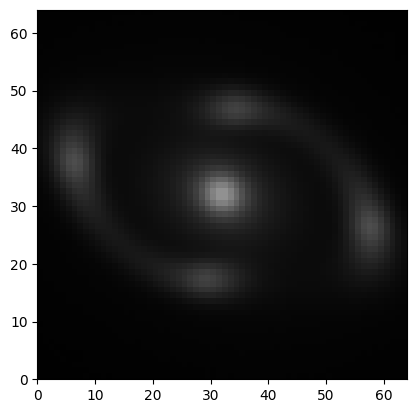

SL_sim_gal2/SL45.png


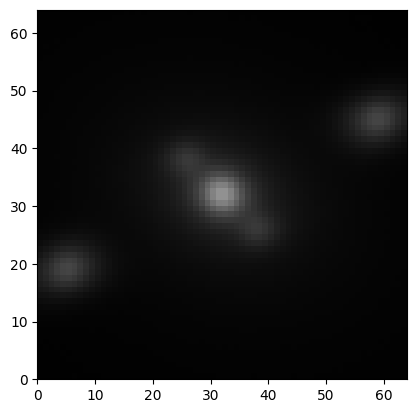

SL_sim_gal2/SL46.png


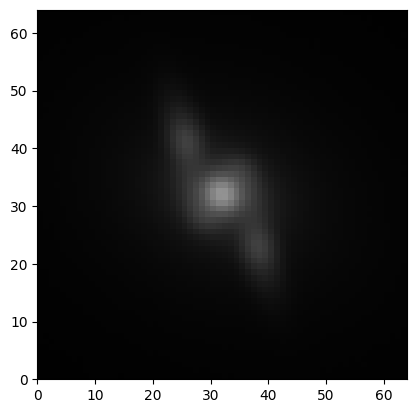

SL_sim_gal2/SL47.png


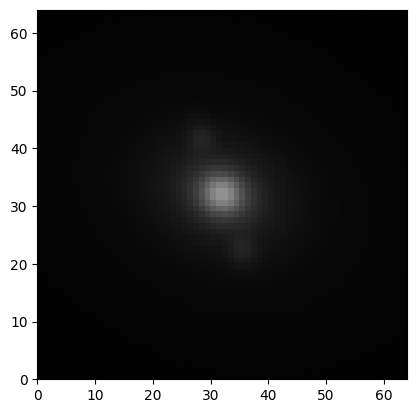

SL_sim_gal2/SL48.png


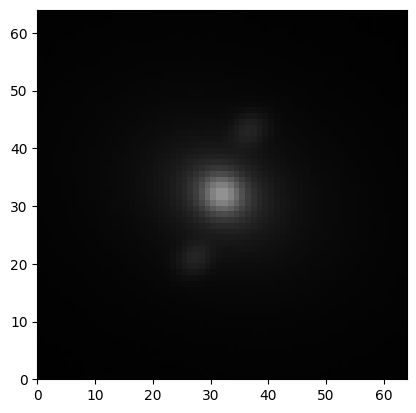

SL_sim_gal2/SL49.png


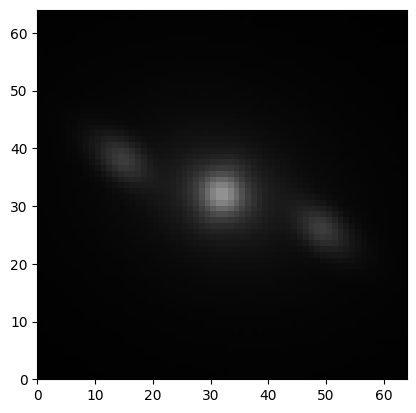

SL_sim_gal2/SL50.png


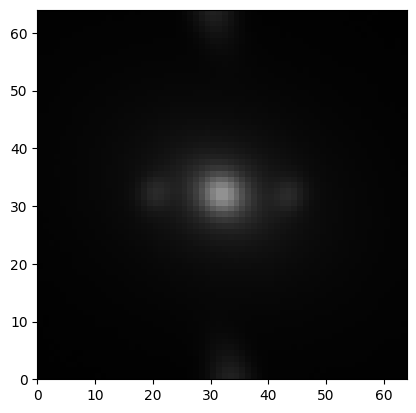

SL_sim_gal2/SL51.png


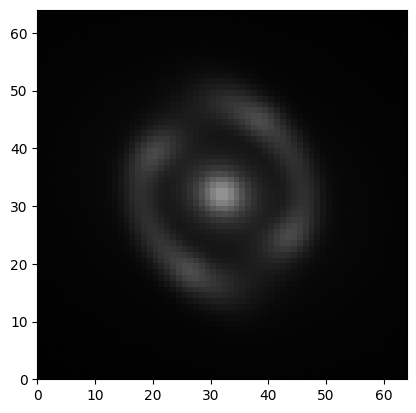

SL_sim_gal2/SL52.png


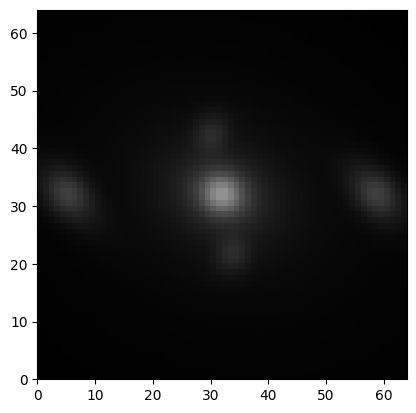

SL_sim_gal2/SL53.png


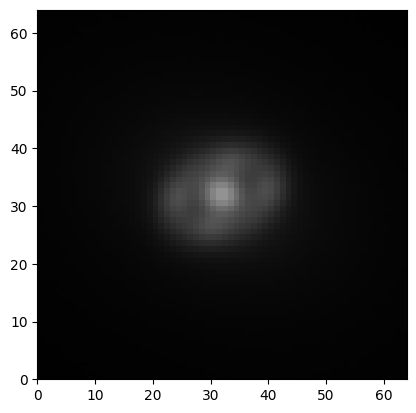

SL_sim_gal2/SL54.png


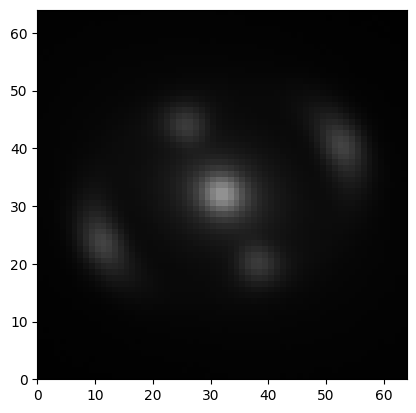

SL_sim_gal2/SL55.png


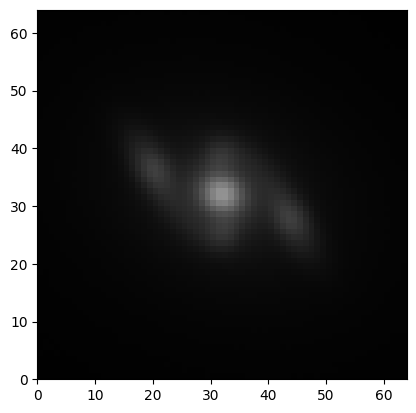

SL_sim_gal2/SL56.png


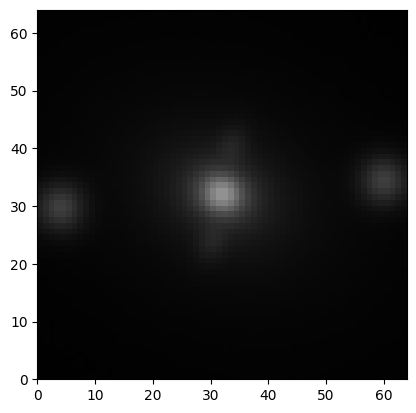

SL_sim_gal2/SL57.png


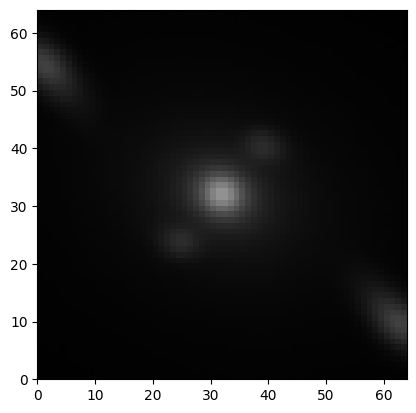

SL_sim_gal2/SL58.png


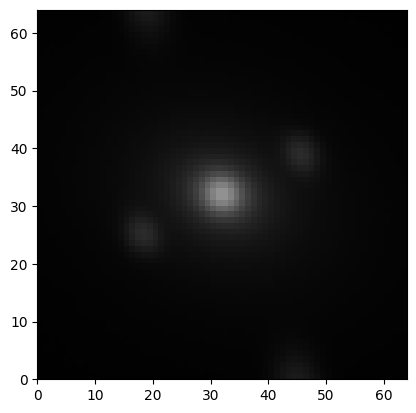

SL_sim_gal2/SL59.png


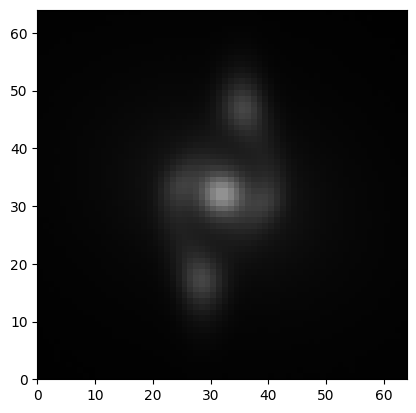

SL_sim_gal2/SL60.png


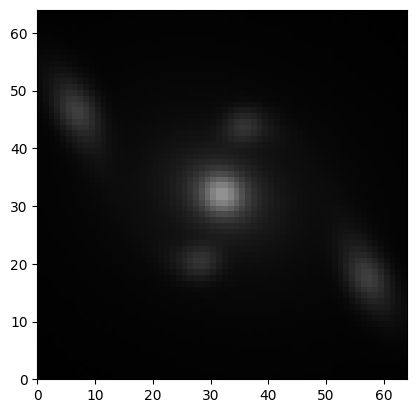

SL_sim_gal2/SL61.png


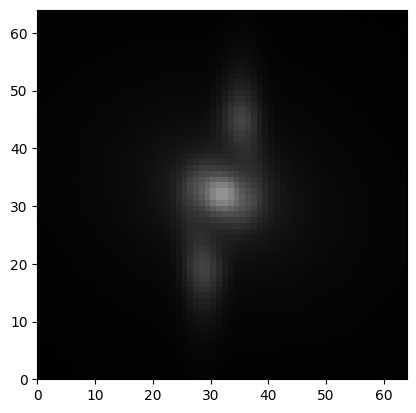

SL_sim_gal2/SL62.png


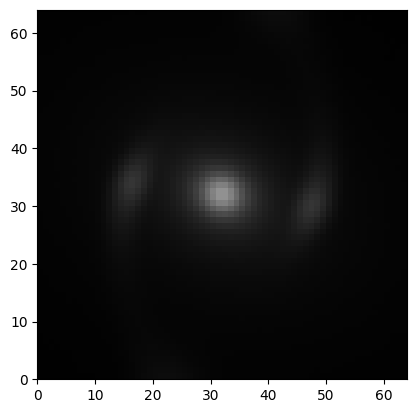

SL_sim_gal2/SL63.png


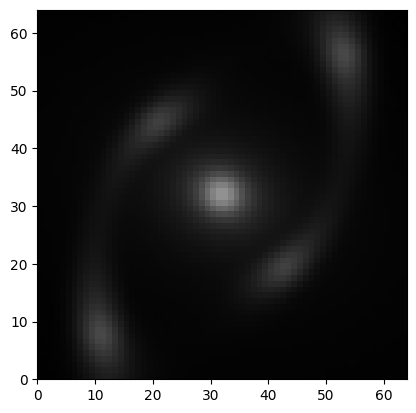

SL_sim_gal2/SL64.png


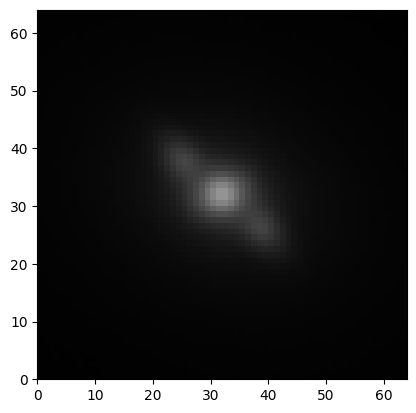

SL_sim_gal2/SL65.png


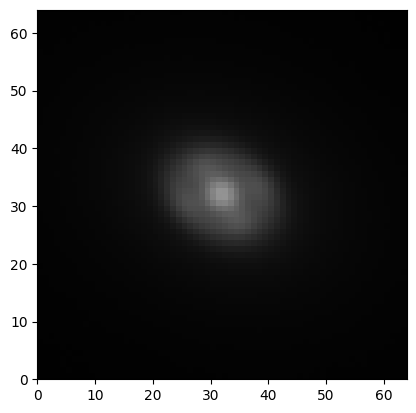

SL_sim_gal2/SL66.png


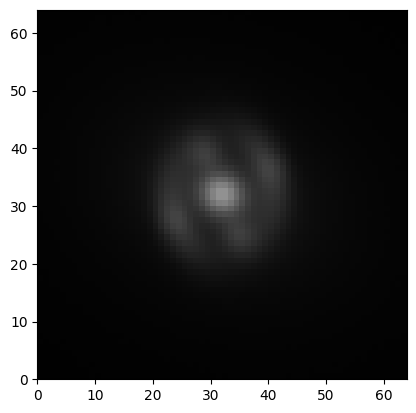

SL_sim_gal2/SL67.png


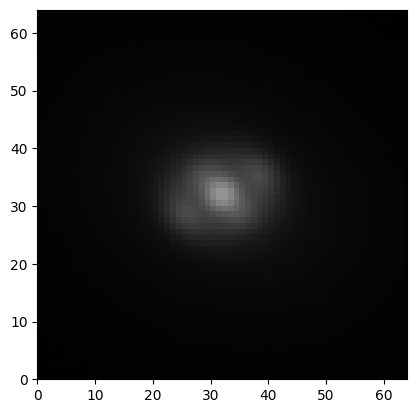

SL_sim_gal2/SL68.png


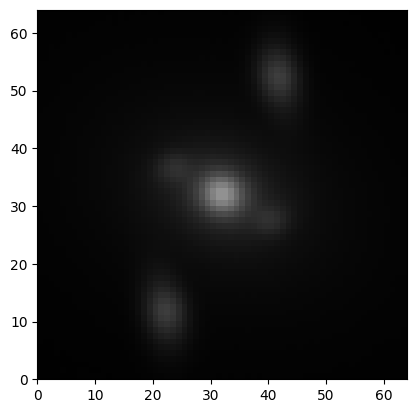

SL_sim_gal2/SL69.png


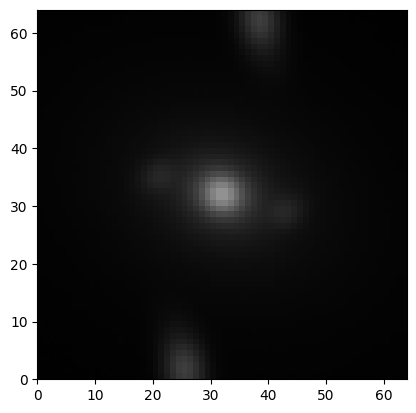

SL_sim_gal2/SL70.png


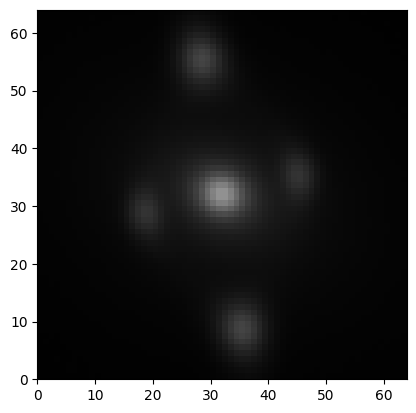

SL_sim_gal2/SL71.png


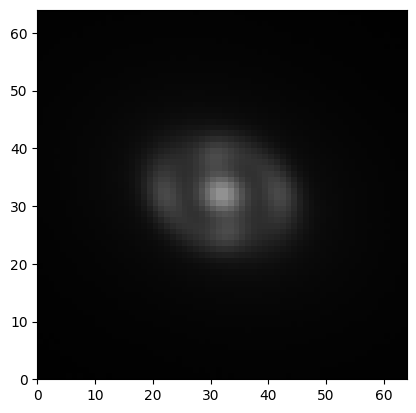

SL_sim_gal2/SL72.png


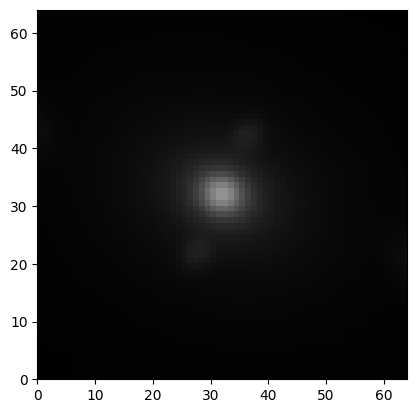

SL_sim_gal2/SL73.png


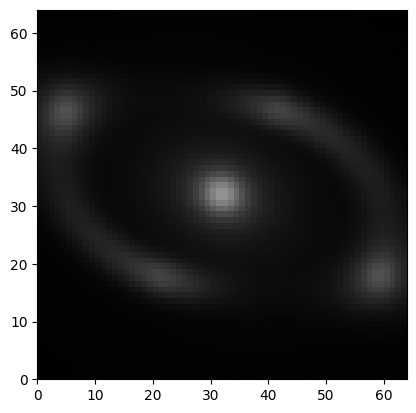

SL_sim_gal2/SL74.png


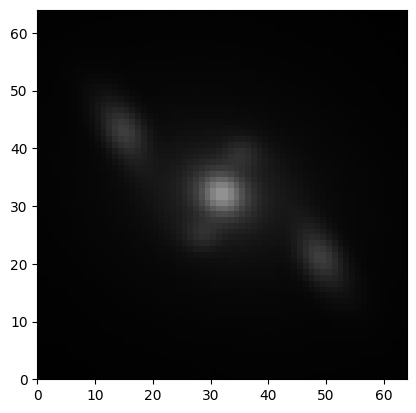

SL_sim_gal2/SL75.png


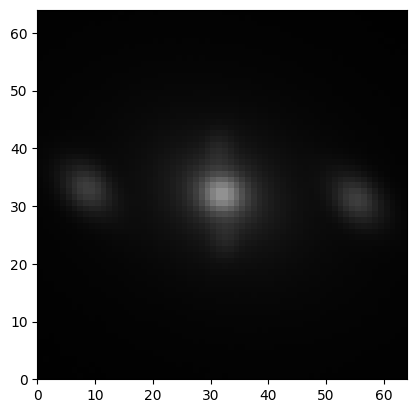

SL_sim_gal2/SL76.png


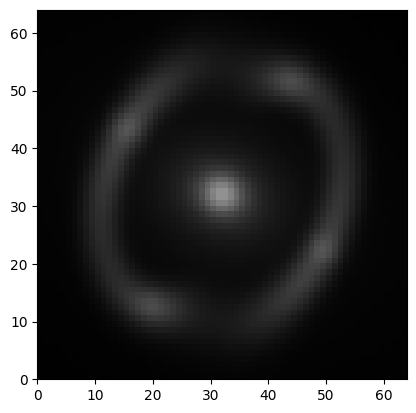

SL_sim_gal2/SL77.png


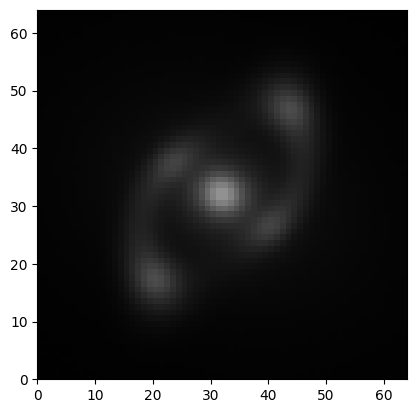

SL_sim_gal2/SL78.png


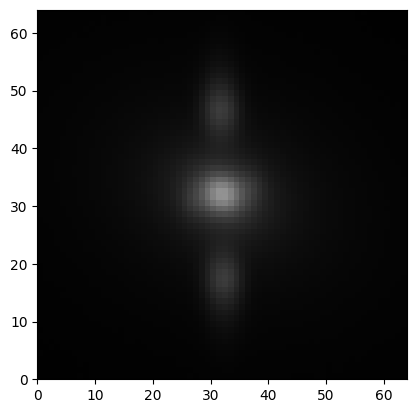

SL_sim_gal2/SL79.png


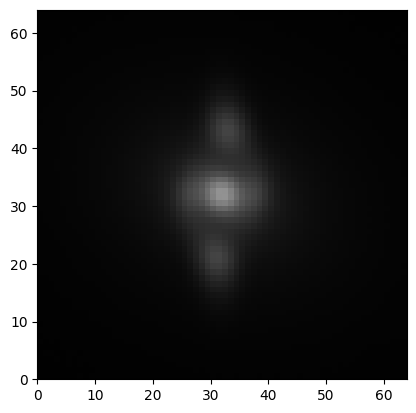

SL_sim_gal2/SL80.png


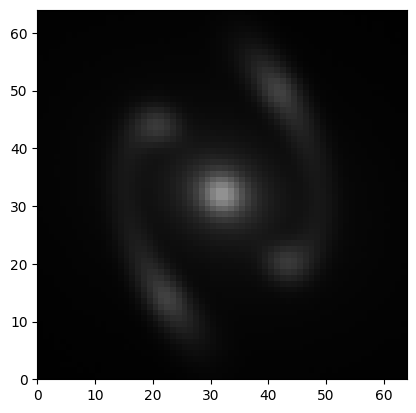

SL_sim_gal2/SL81.png


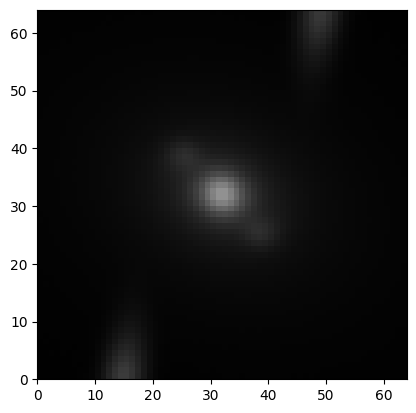

SL_sim_gal2/SL82.png


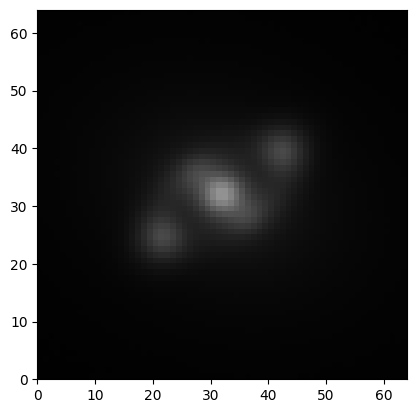

SL_sim_gal2/SL83.png


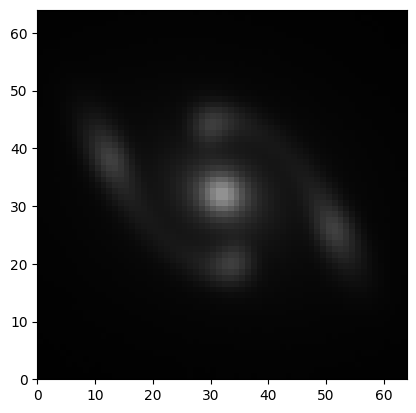

SL_sim_gal2/SL84.png


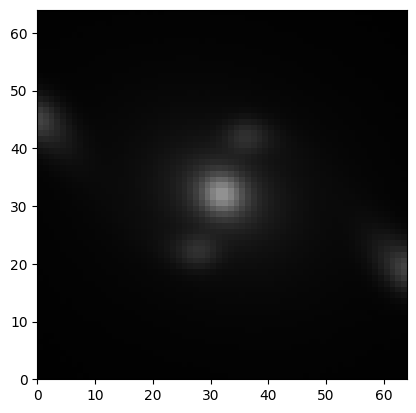

SL_sim_gal2/SL85.png


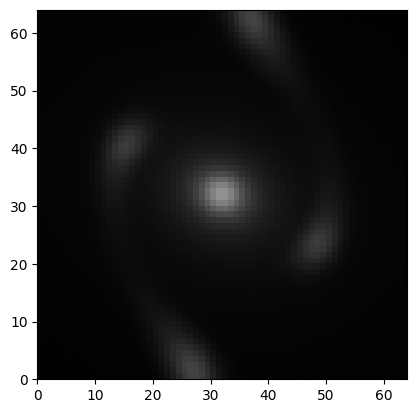

SL_sim_gal2/SL86.png


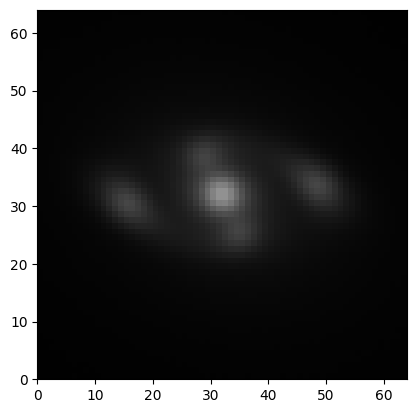

SL_sim_gal2/SL87.png


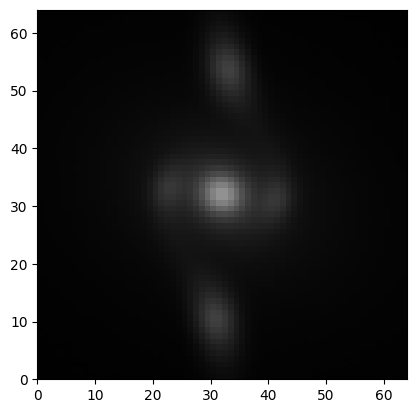

SL_sim_gal2/SL88.png


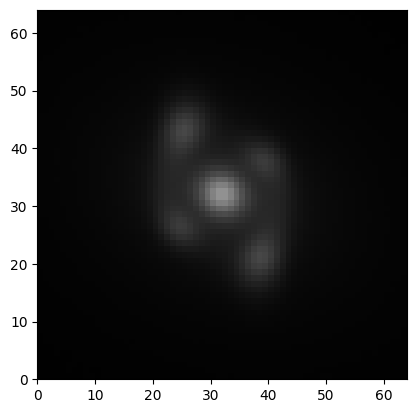

SL_sim_gal2/SL89.png


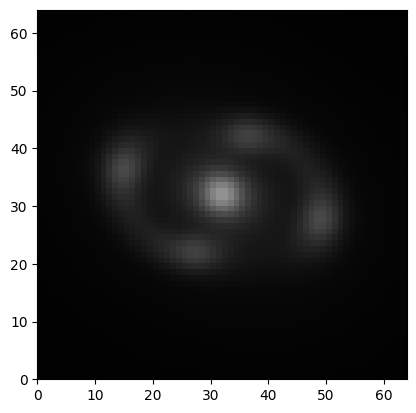

SL_sim_gal2/SL90.png


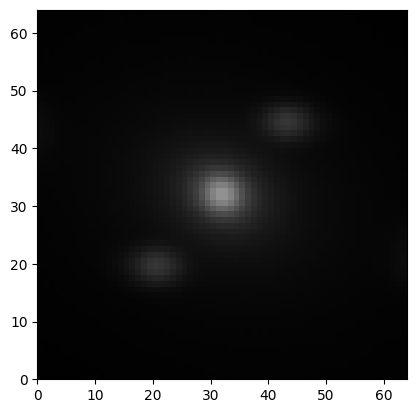

SL_sim_gal2/SL91.png


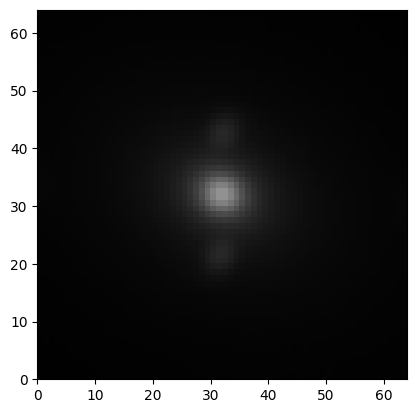

SL_sim_gal2/SL92.png


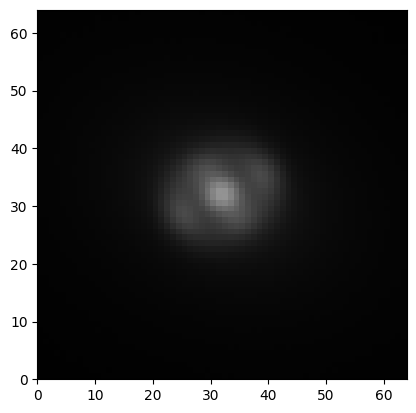

SL_sim_gal2/SL93.png


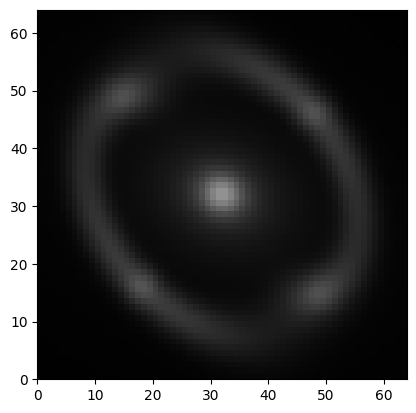

SL_sim_gal2/SL94.png


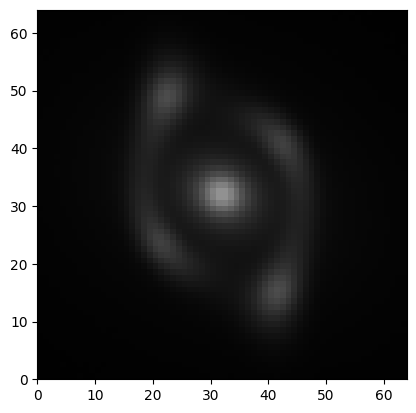

SL_sim_gal2/SL95.png


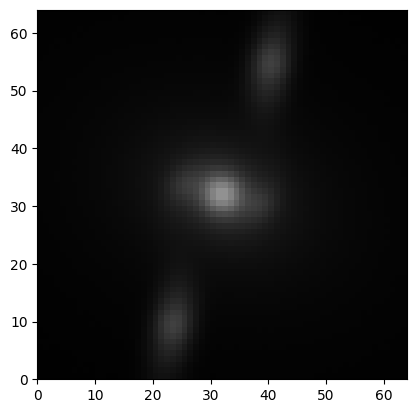

SL_sim_gal2/SL96.png


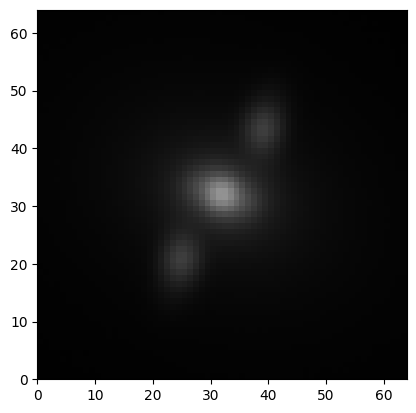

SL_sim_gal2/SL97.png


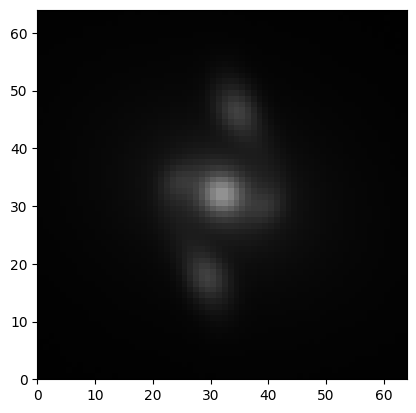

SL_sim_gal2/SL98.png


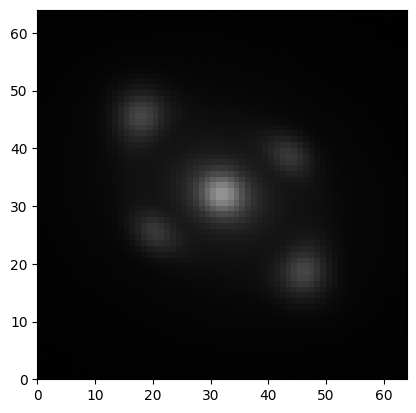

SL_sim_gal2/SL99.png


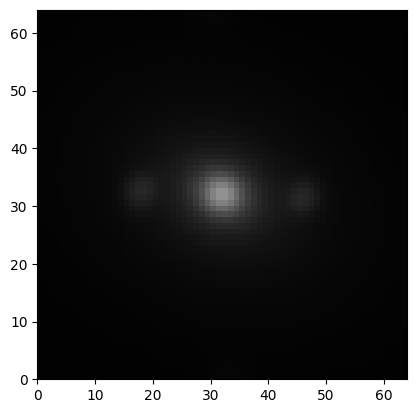

SL_sim_gal2/SL100.png


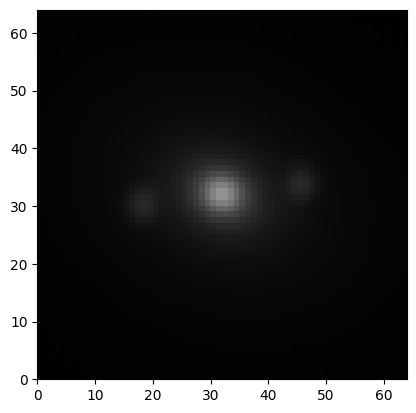

SL_sim_gal2/SL101.png


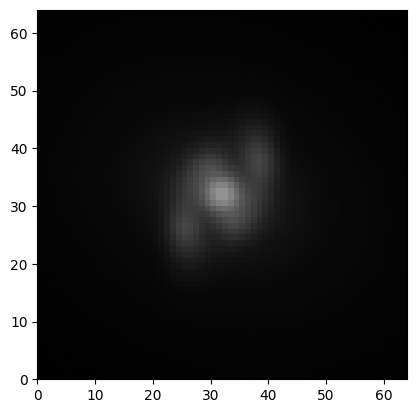

SL_sim_gal2/SL102.png


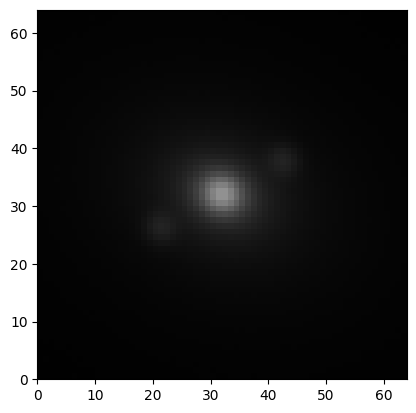

SL_sim_gal2/SL103.png


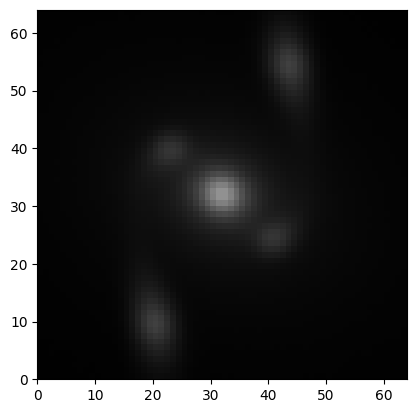

SL_sim_gal2/SL104.png


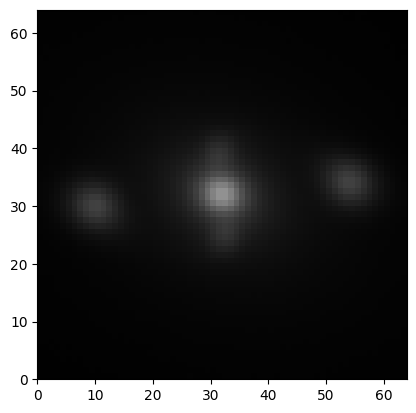

SL_sim_gal2/SL105.png


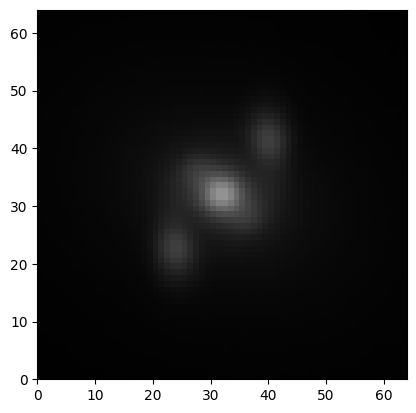

SL_sim_gal2/SL106.png


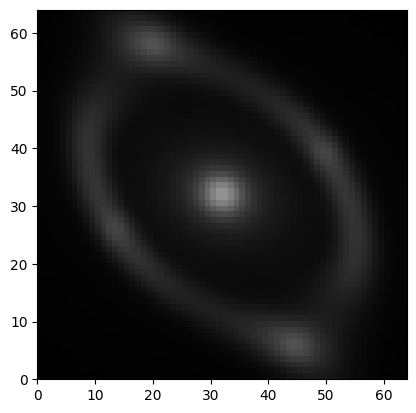

SL_sim_gal2/SL107.png


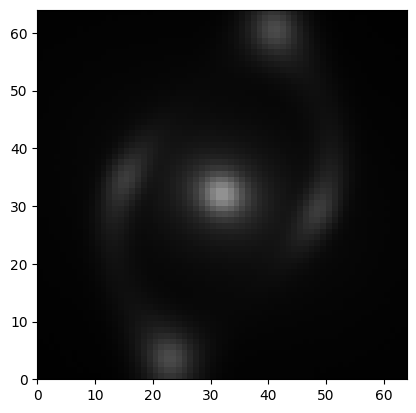

SL_sim_gal2/SL108.png


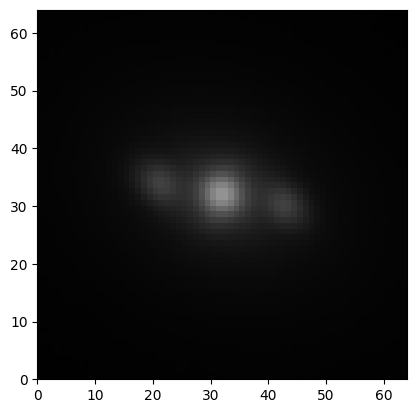

SL_sim_gal2/SL109.png


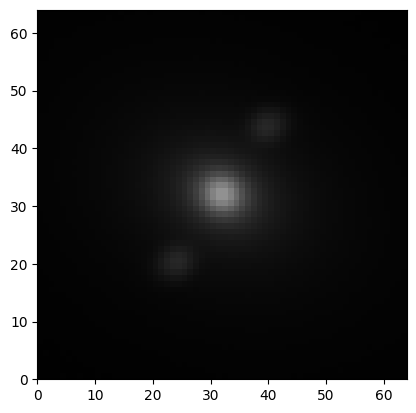

SL_sim_gal2/SL110.png


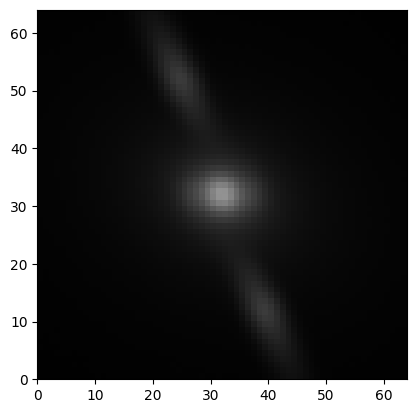

SL_sim_gal2/SL111.png


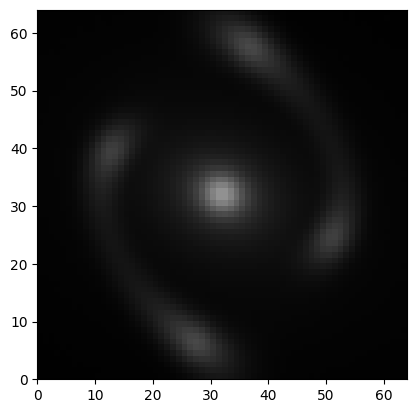

SL_sim_gal2/SL112.png


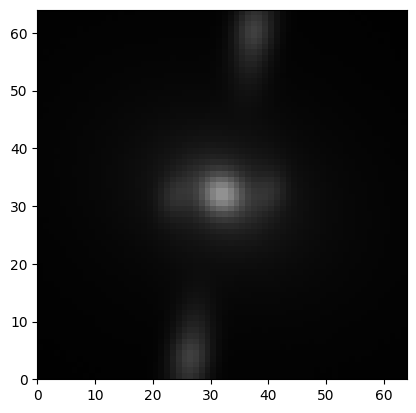

SL_sim_gal2/SL113.png


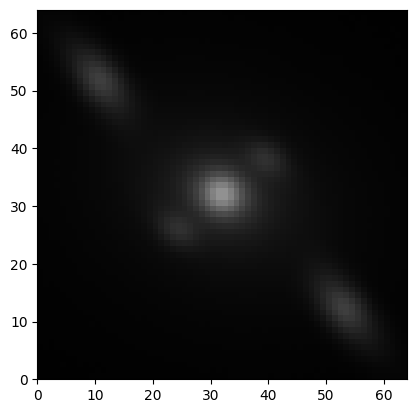

SL_sim_gal2/SL114.png


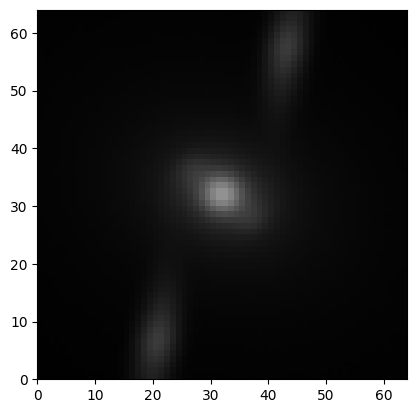

SL_sim_gal2/SL115.png


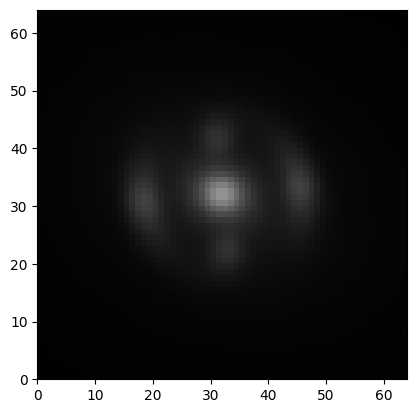

SL_sim_gal2/SL116.png


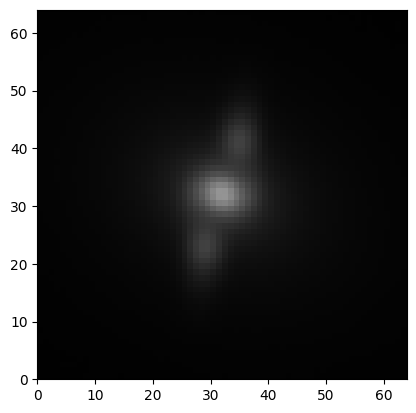

SL_sim_gal2/SL117.png


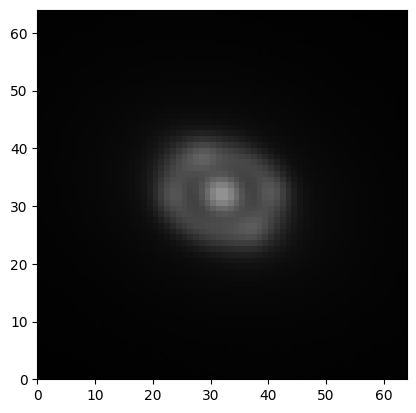

SL_sim_gal2/SL118.png


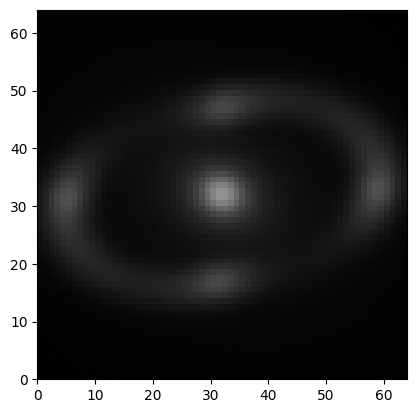

SL_sim_gal2/SL119.png


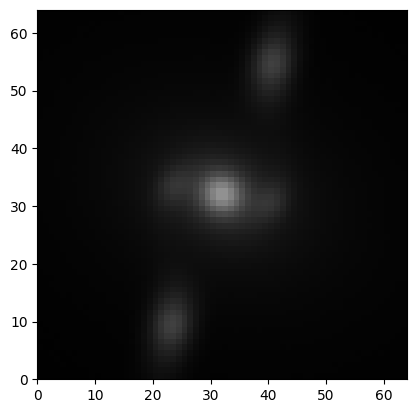

SL_sim_gal2/SL120.png


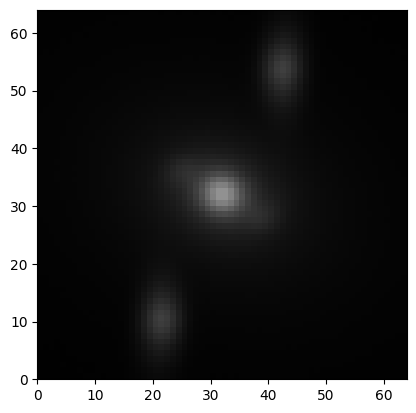

SL_sim_gal2/SL121.png


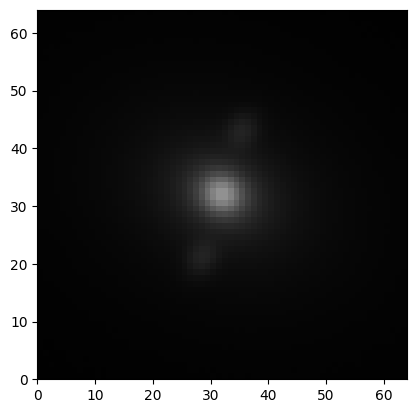

SL_sim_gal2/SL122.png


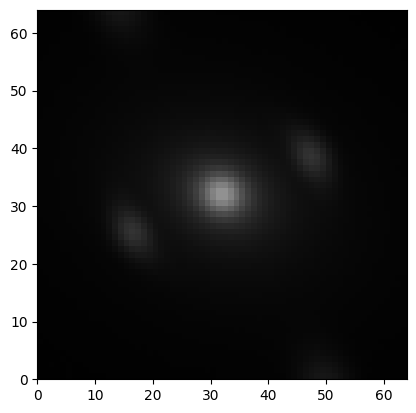

SL_sim_gal2/SL123.png


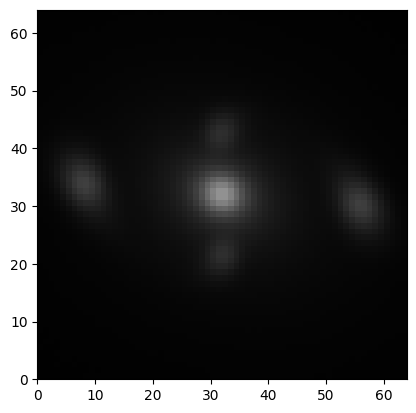

SL_sim_gal2/SL124.png


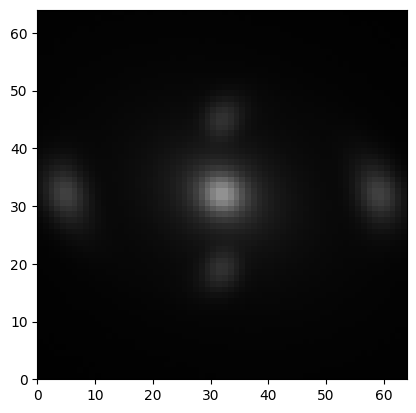

SL_sim_gal2/SL125.png


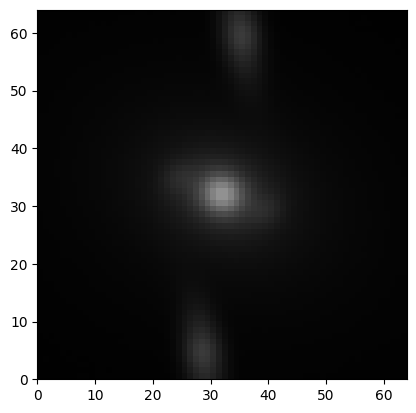

SL_sim_gal2/SL126.png


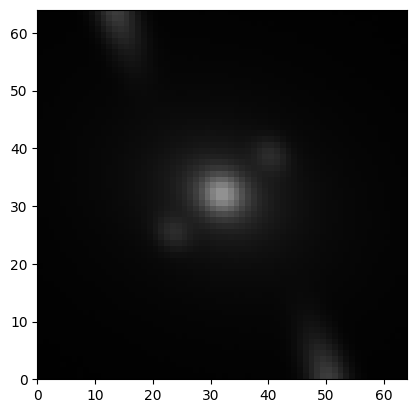

SL_sim_gal2/SL127.png


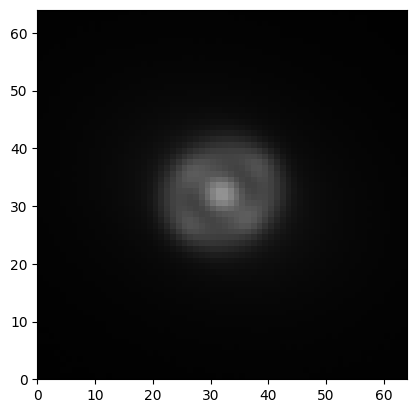

SL_sim_gal2/SL128.png


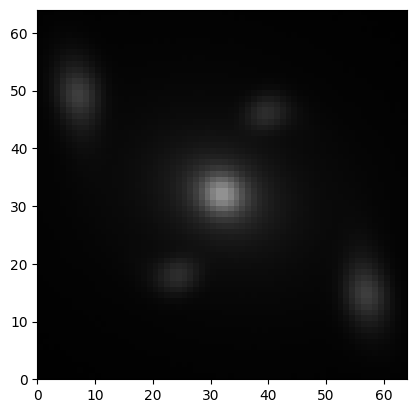

SL_sim_gal2/SL129.png


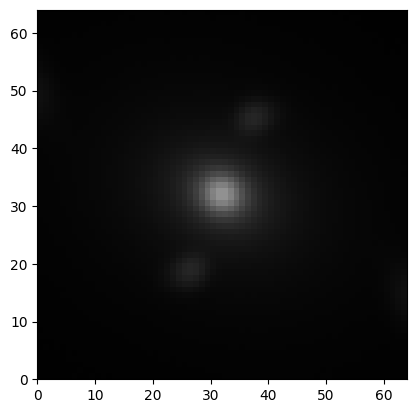

SL_sim_gal2/SL130.png


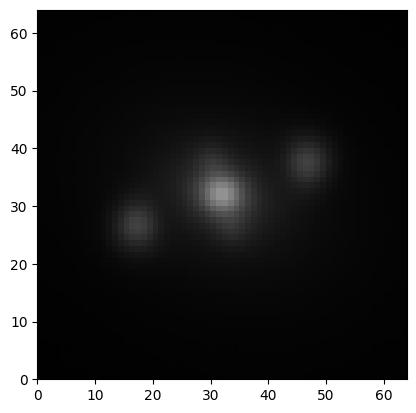

SL_sim_gal2/SL131.png


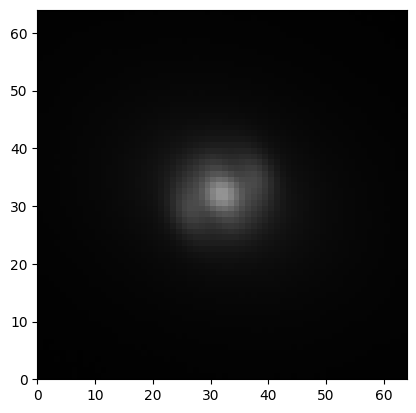

SL_sim_gal2/SL132.png


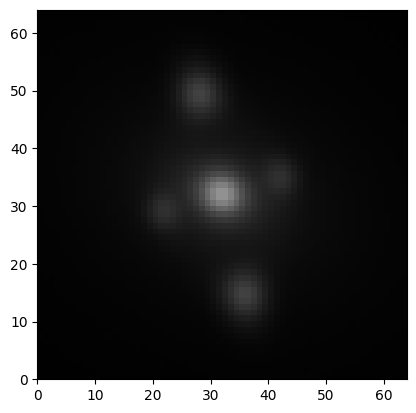

SL_sim_gal2/SL133.png


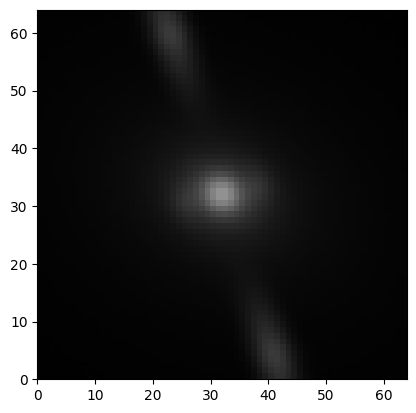

SL_sim_gal2/SL134.png


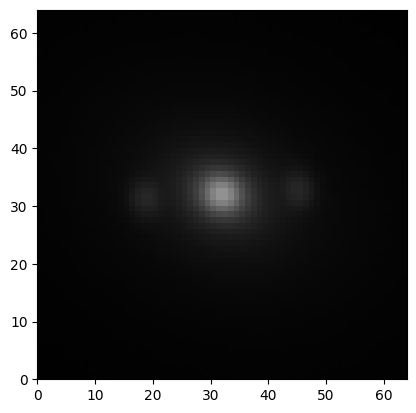

SL_sim_gal2/SL135.png


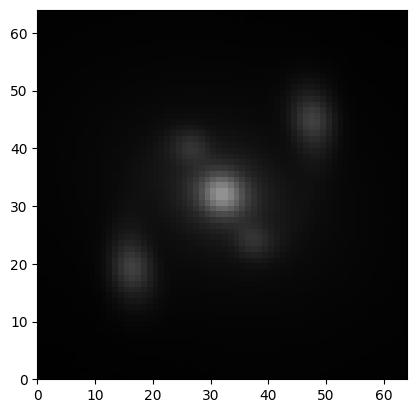

SL_sim_gal2/SL136.png


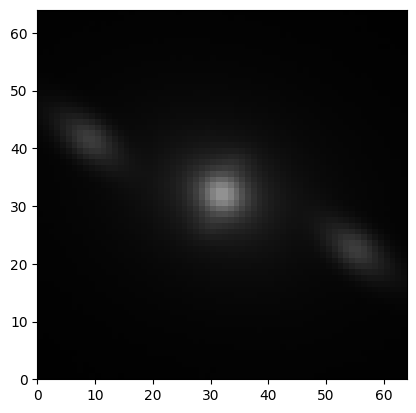

SL_sim_gal2/SL137.png


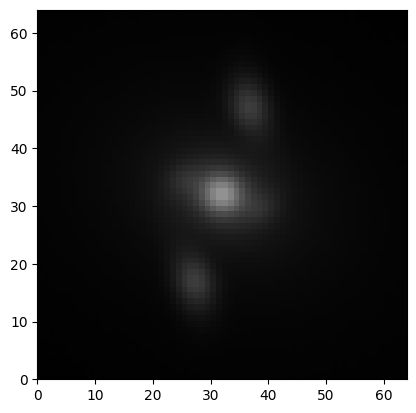

SL_sim_gal2/SL138.png


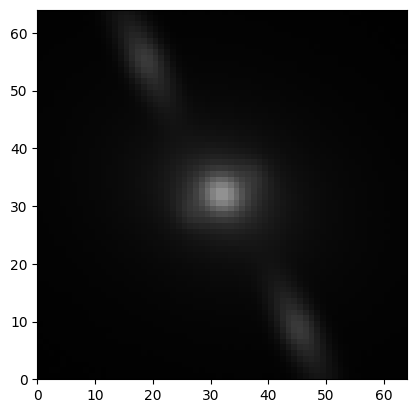

SL_sim_gal2/SL139.png


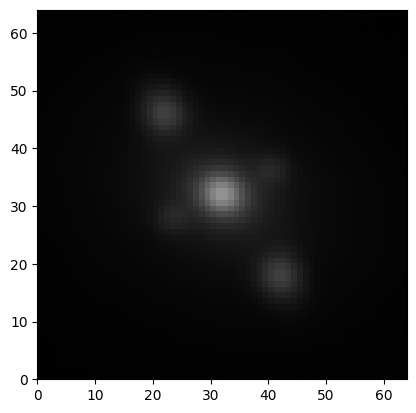

SL_sim_gal2/SL140.png


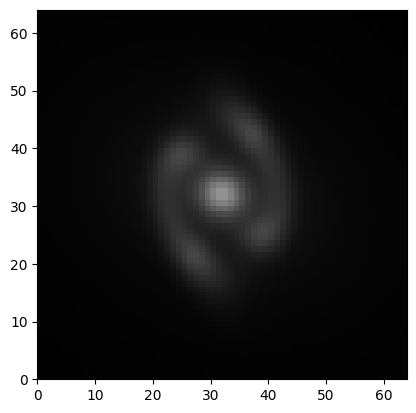

SL_sim_gal2/SL141.png


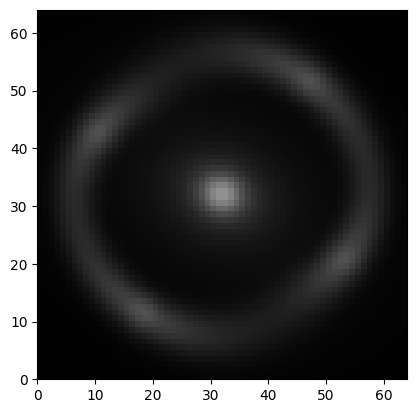

SL_sim_gal2/SL142.png


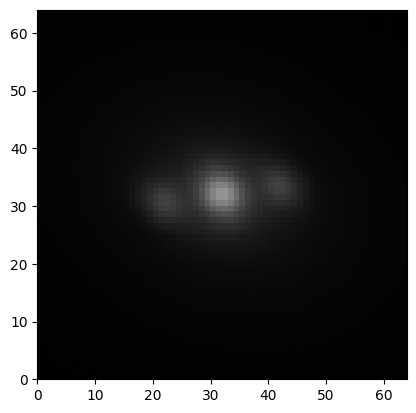

SL_sim_gal2/SL143.png


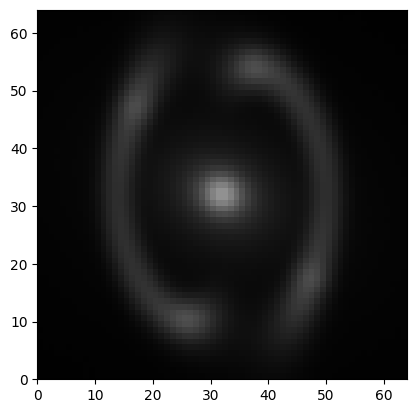

SL_sim_gal2/SL144.png


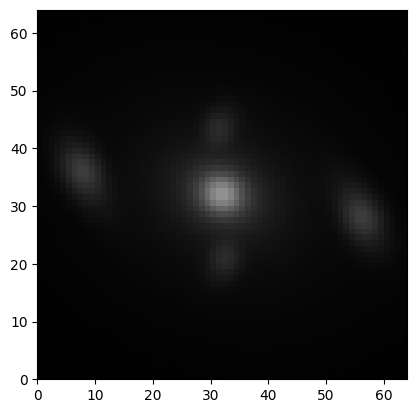

SL_sim_gal2/SL145.png


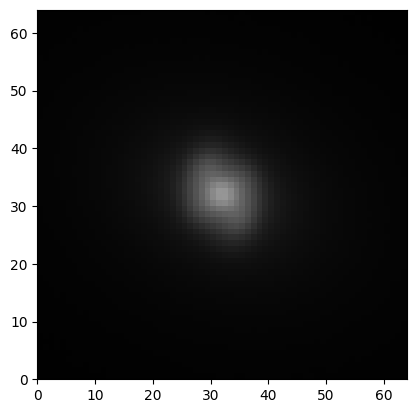

SL_sim_gal2/SL146.png


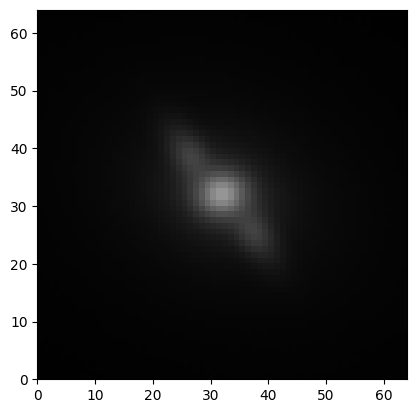

SL_sim_gal2/SL147.png


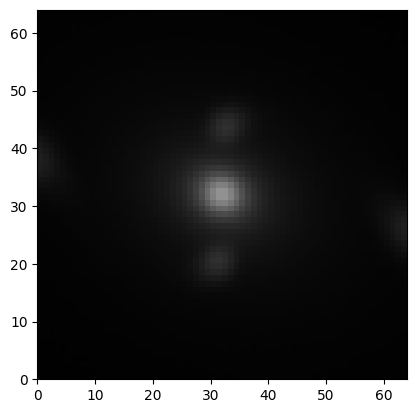

SL_sim_gal2/SL148.png


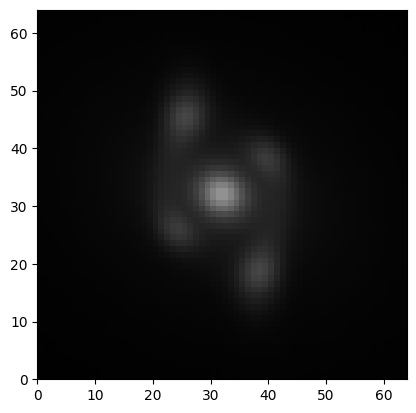

SL_sim_gal2/SL149.png


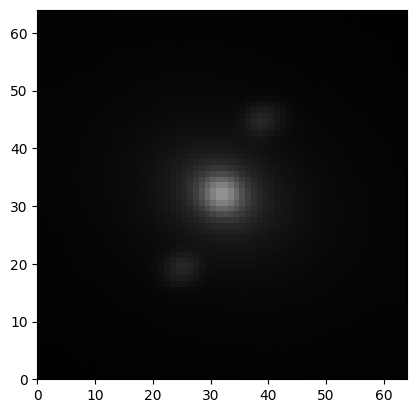

SL_sim_gal2/SL150.png


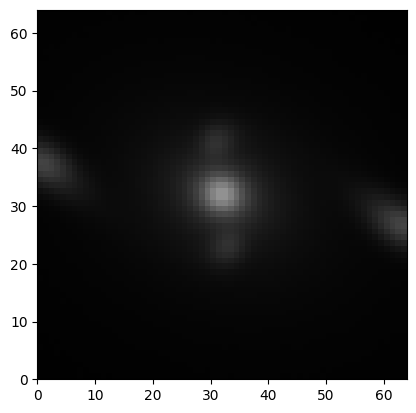

SL_sim_gal2/SL151.png


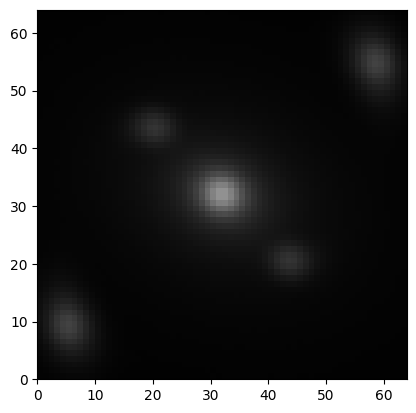

SL_sim_gal2/SL152.png


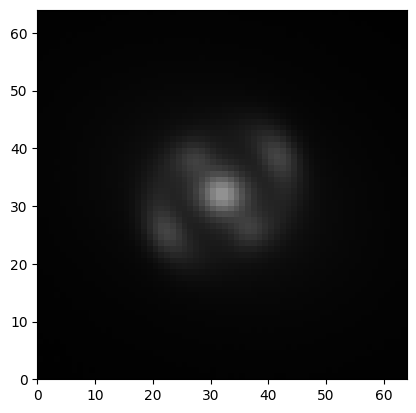

SL_sim_gal2/SL153.png


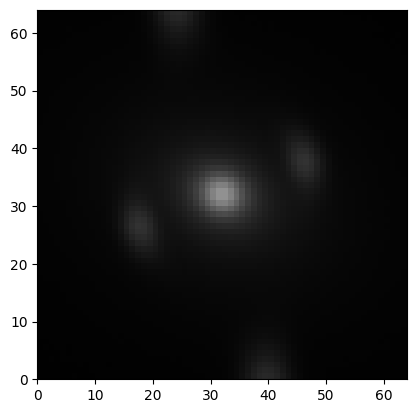

SL_sim_gal2/SL154.png


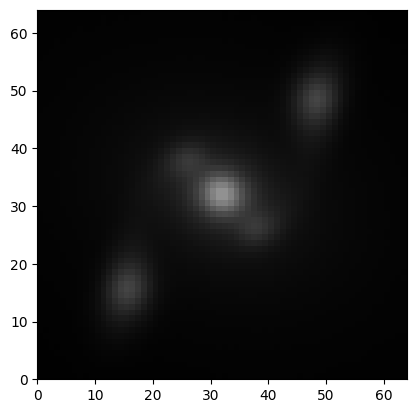

SL_sim_gal2/SL155.png


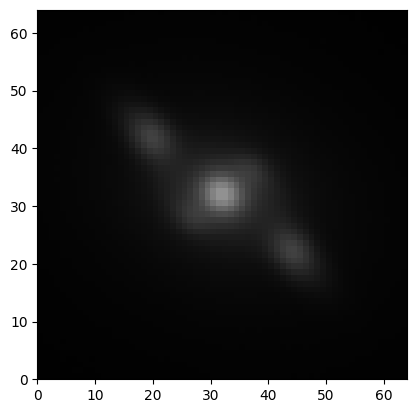

SL_sim_gal2/SL156.png


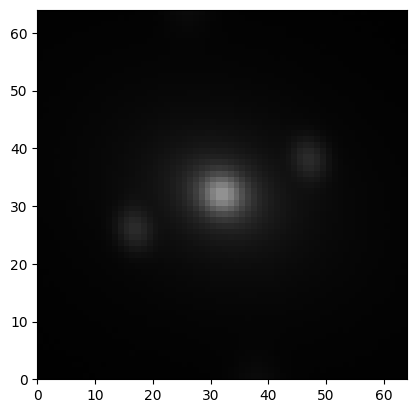

SL_sim_gal2/SL157.png


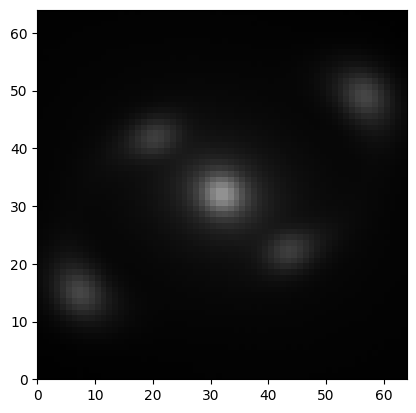

SL_sim_gal2/SL158.png


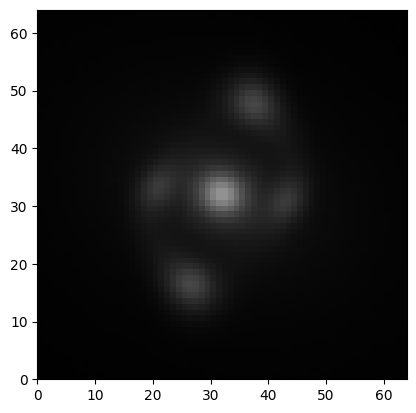

SL_sim_gal2/SL159.png


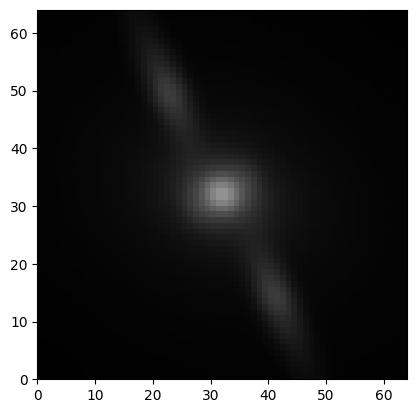

SL_sim_gal2/SL160.png


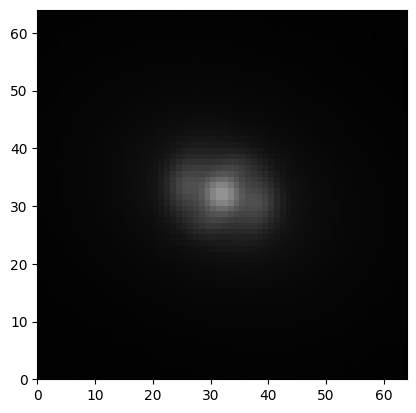

SL_sim_gal2/SL161.png


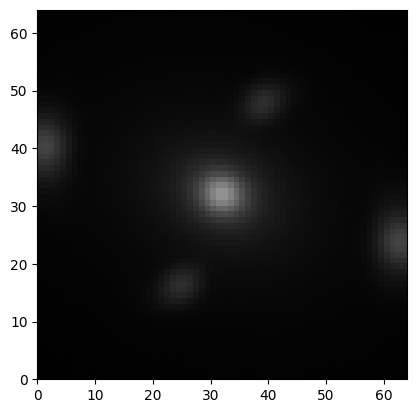

SL_sim_gal2/SL162.png


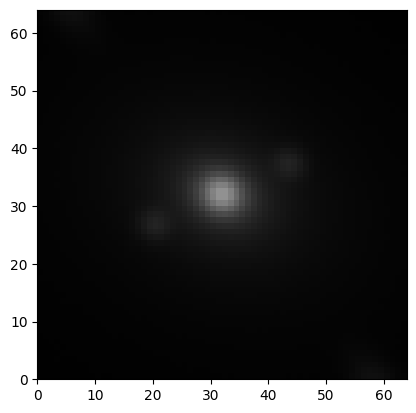

SL_sim_gal2/SL163.png


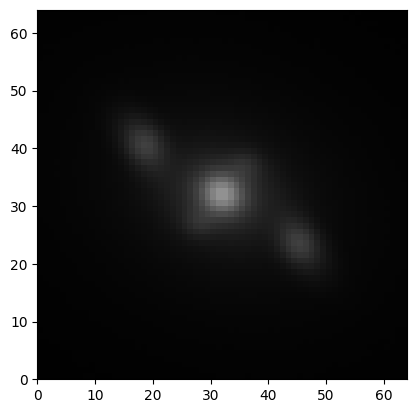

SL_sim_gal2/SL164.png


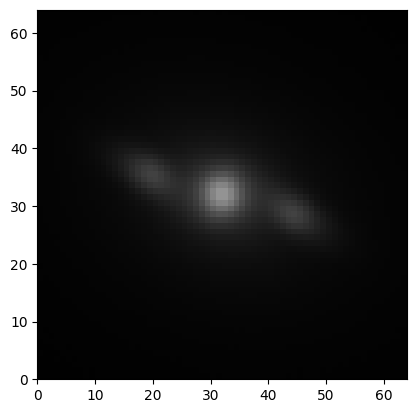

SL_sim_gal2/SL165.png


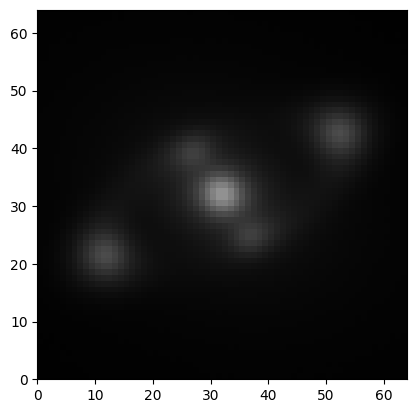

SL_sim_gal2/SL166.png


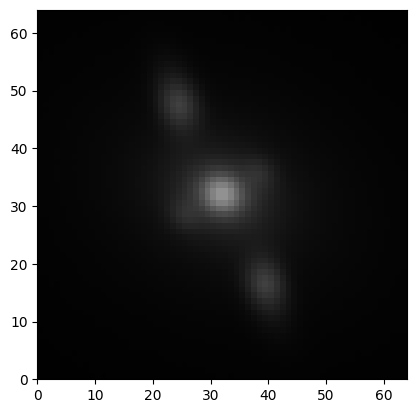

SL_sim_gal2/SL167.png


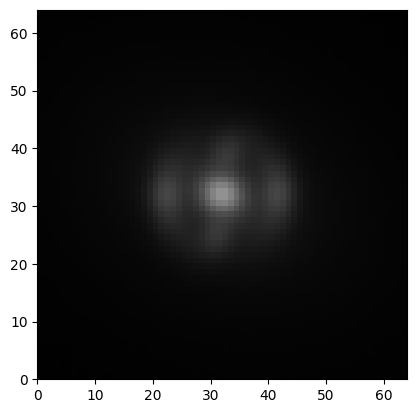

SL_sim_gal2/SL168.png


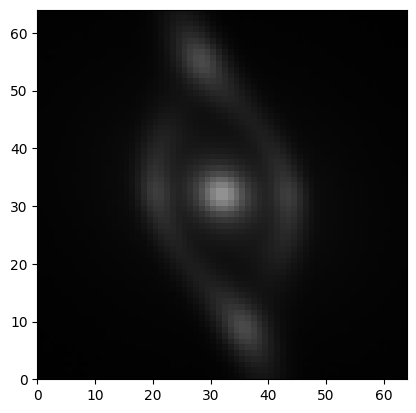

SL_sim_gal2/SL169.png


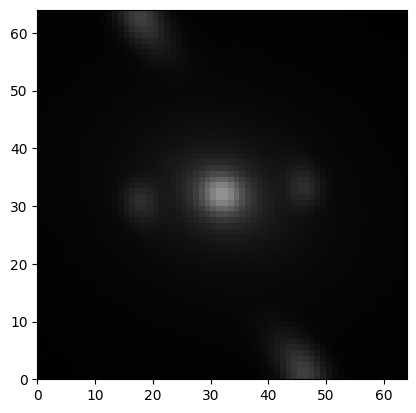

SL_sim_gal2/SL170.png


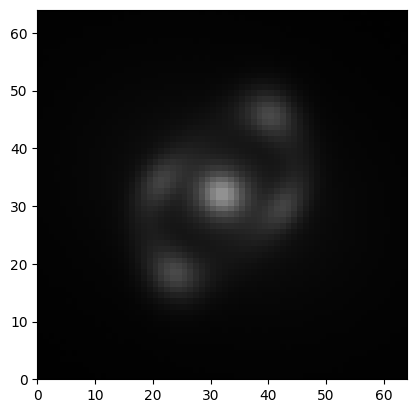

SL_sim_gal2/SL171.png


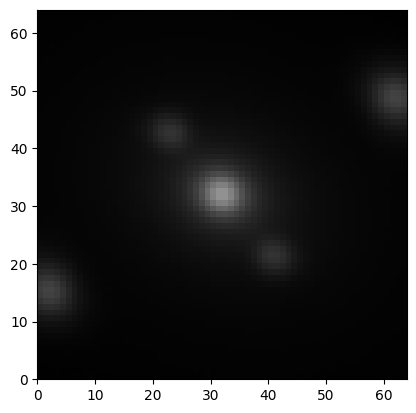

SL_sim_gal2/SL172.png


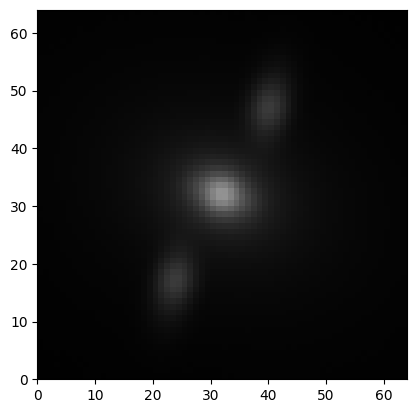

SL_sim_gal2/SL173.png


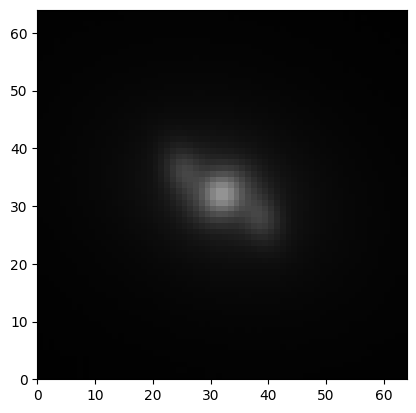

SL_sim_gal2/SL174.png


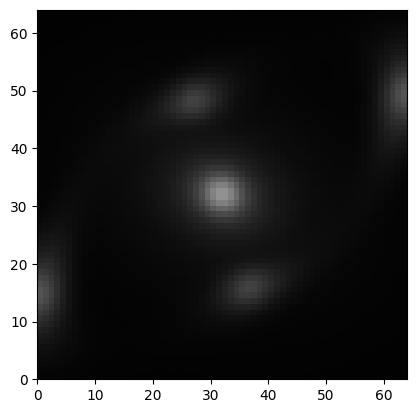

SL_sim_gal2/SL175.png


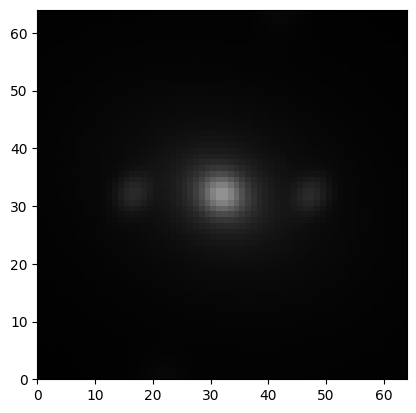

SL_sim_gal2/SL176.png


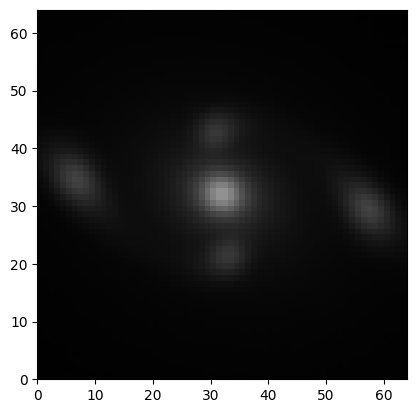

SL_sim_gal2/SL177.png


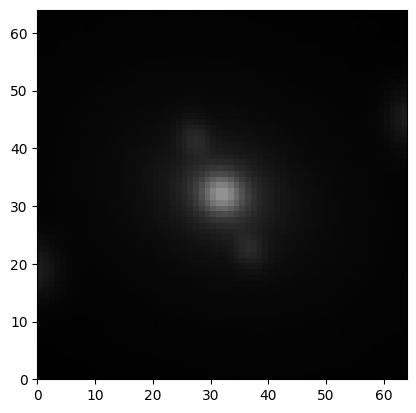

SL_sim_gal2/SL178.png


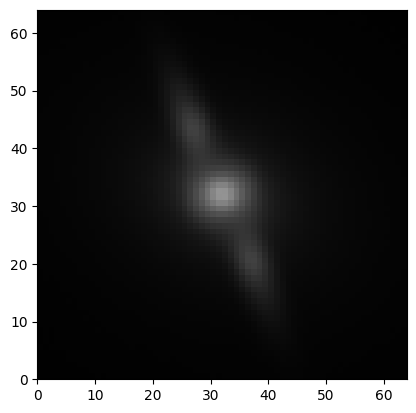

SL_sim_gal2/SL179.png


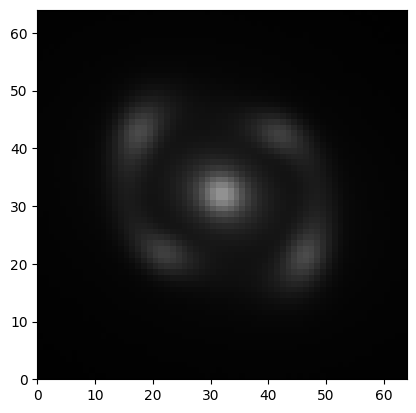

SL_sim_gal2/SL180.png


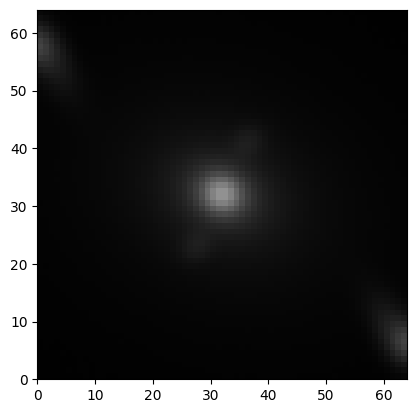

SL_sim_gal2/SL181.png


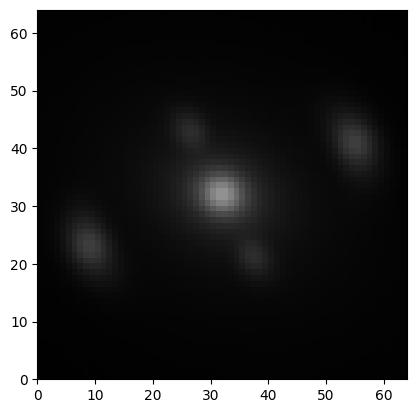

SL_sim_gal2/SL182.png


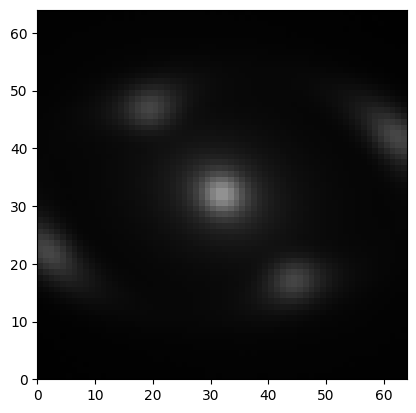

SL_sim_gal2/SL183.png


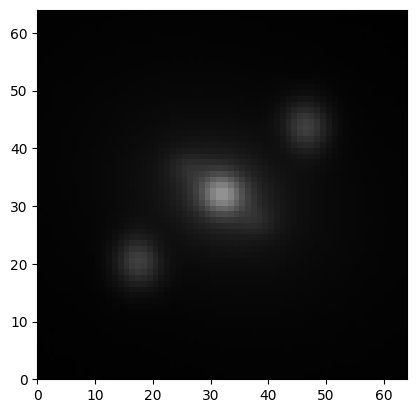

SL_sim_gal2/SL184.png


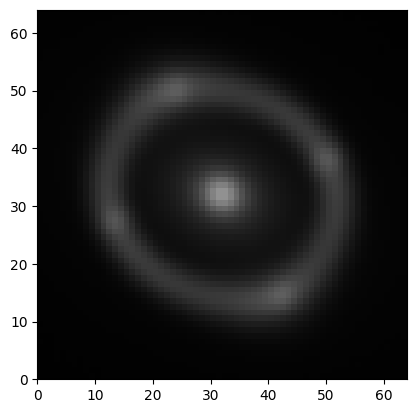

SL_sim_gal2/SL185.png


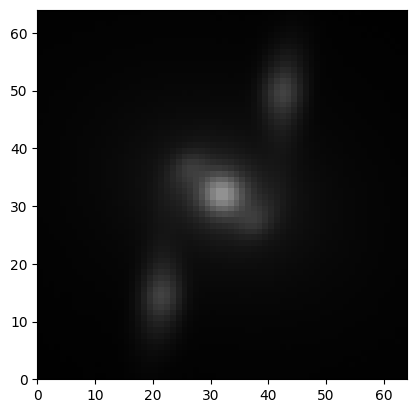

SL_sim_gal2/SL186.png


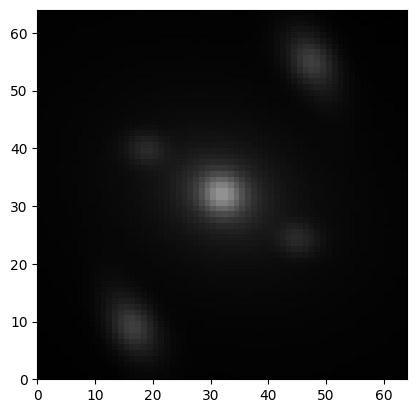

SL_sim_gal2/SL187.png


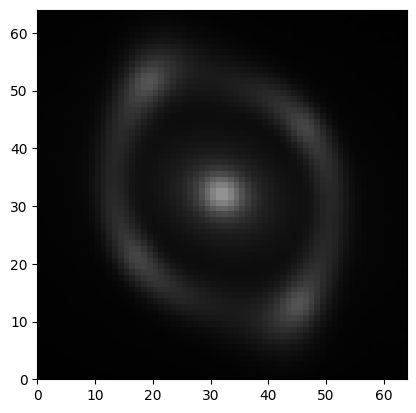

SL_sim_gal2/SL188.png


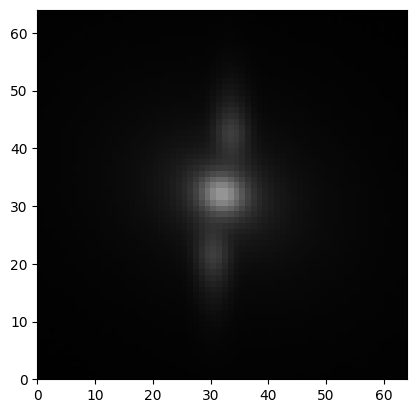

SL_sim_gal2/SL189.png


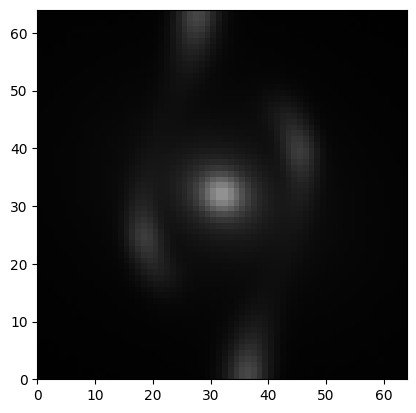

SL_sim_gal2/SL190.png


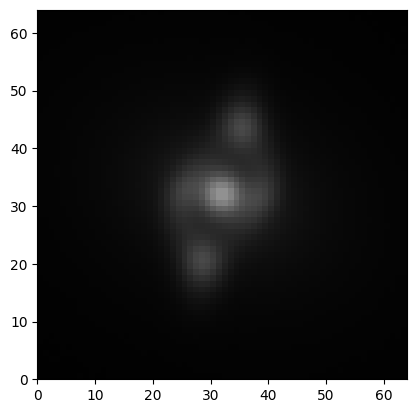

SL_sim_gal2/SL191.png


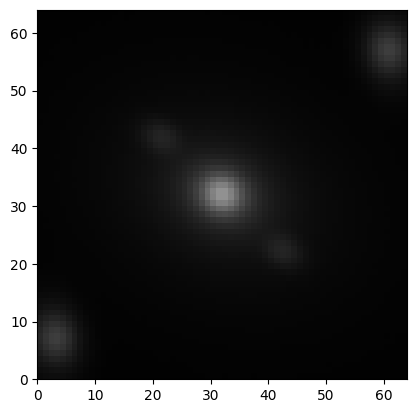

SL_sim_gal2/SL192.png


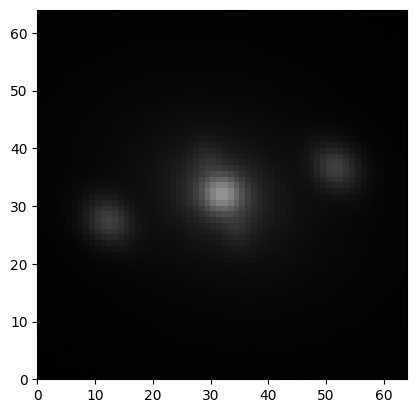

SL_sim_gal2/SL193.png


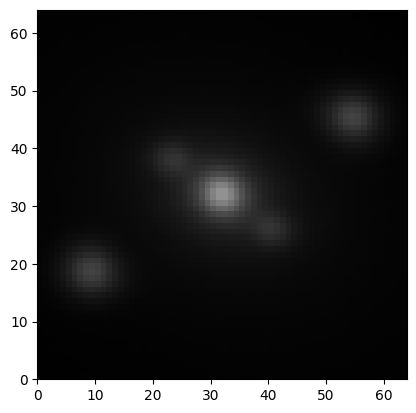

SL_sim_gal2/SL194.png


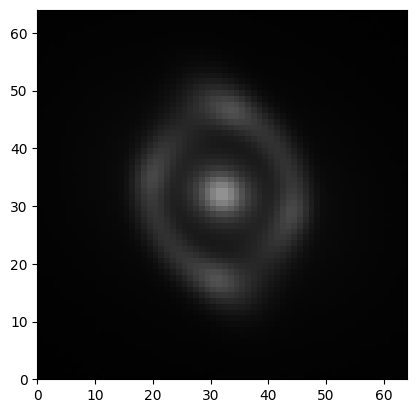

SL_sim_gal2/SL195.png


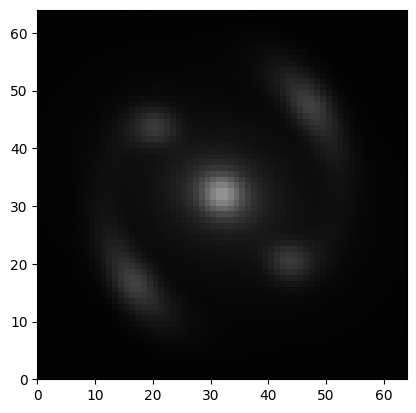

SL_sim_gal2/SL196.png


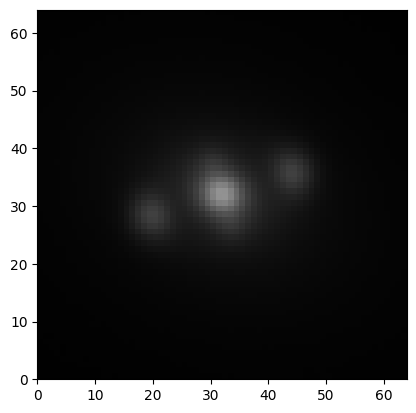

SL_sim_gal2/SL197.png


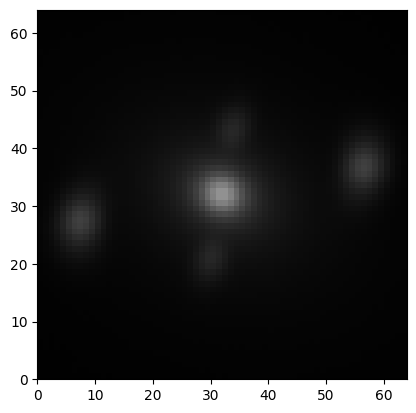

SL_sim_gal2/SL198.png


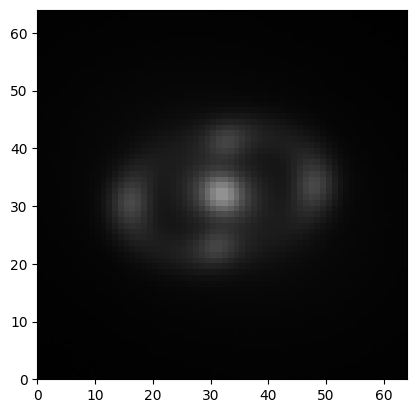

SL_sim_gal2/SL199.png


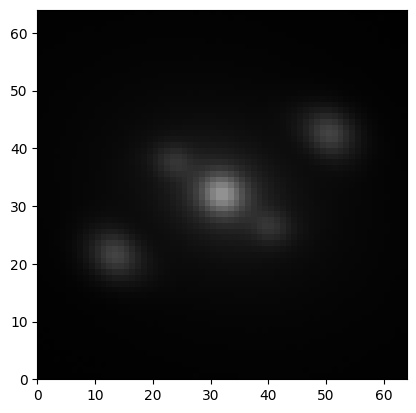

SL_sim_gal2/SL200.png


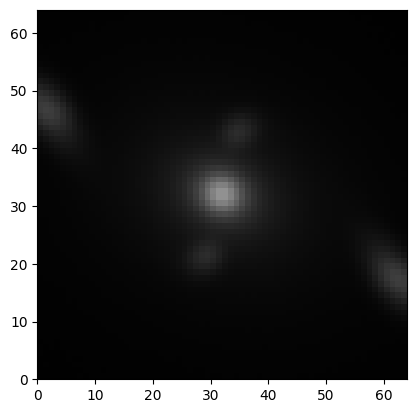

SL_sim_gal2/SL201.png


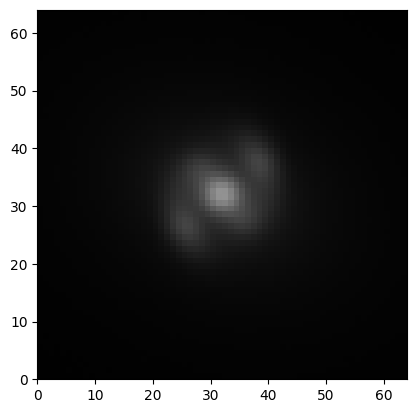

SL_sim_gal2/SL202.png


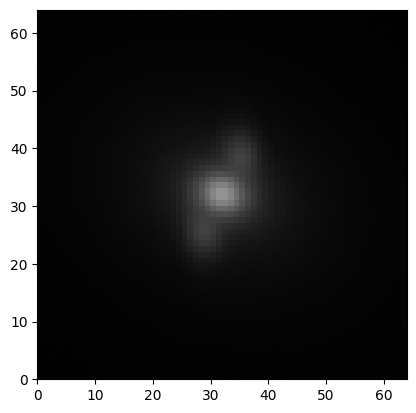

SL_sim_gal2/SL203.png


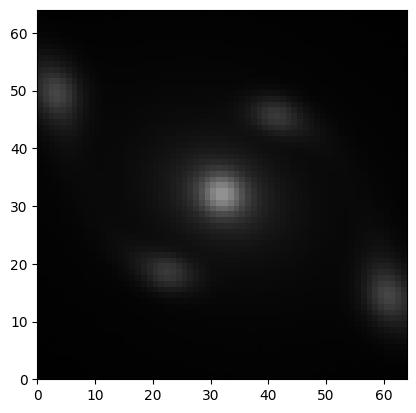

SL_sim_gal2/SL204.png


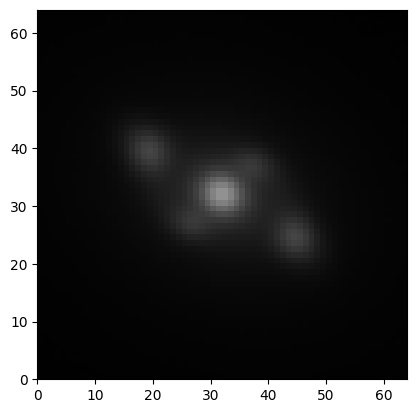

SL_sim_gal2/SL205.png


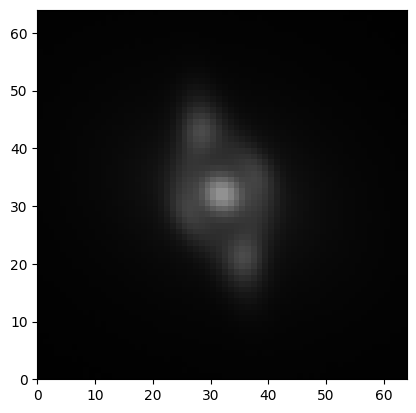

SL_sim_gal2/SL206.png


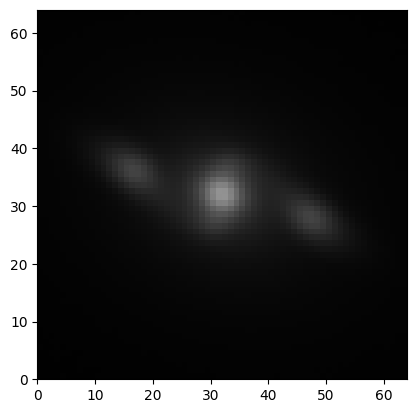

SL_sim_gal2/SL207.png


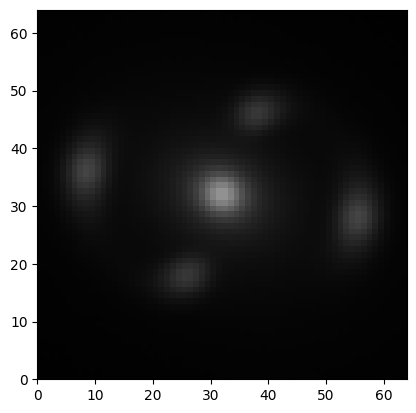

SL_sim_gal2/SL208.png


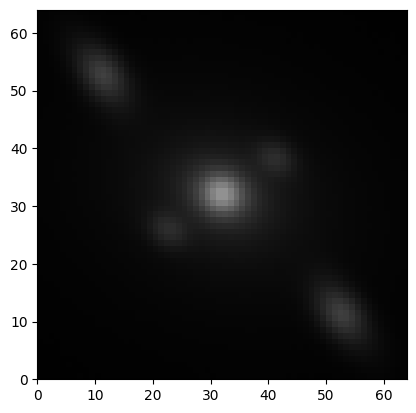

SL_sim_gal2/SL209.png


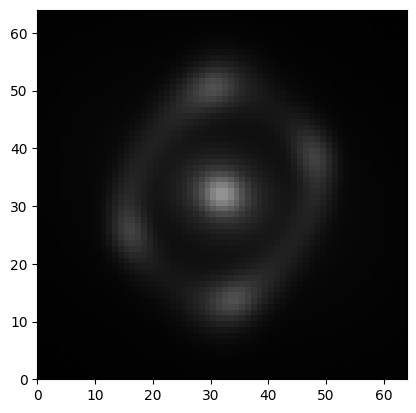

SL_sim_gal2/SL210.png


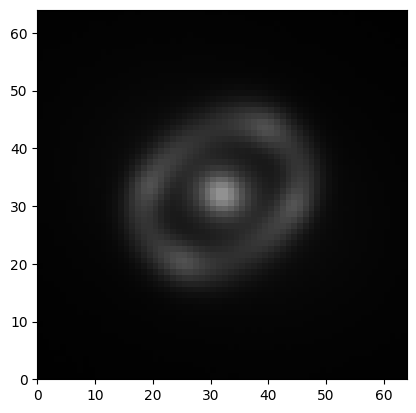

SL_sim_gal2/SL211.png


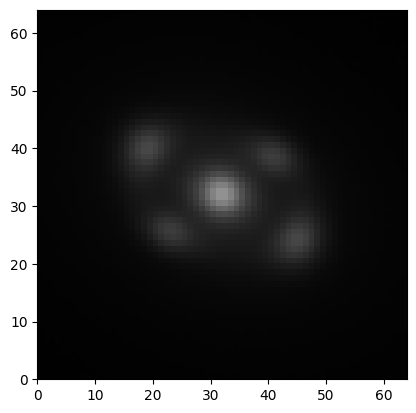

SL_sim_gal2/SL212.png


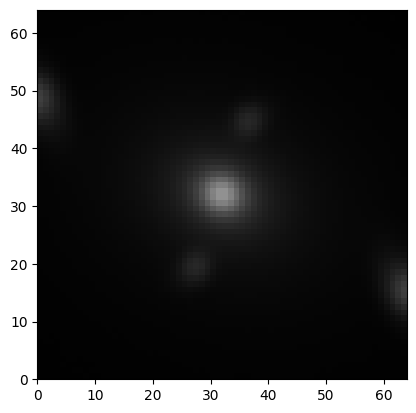

SL_sim_gal2/SL213.png


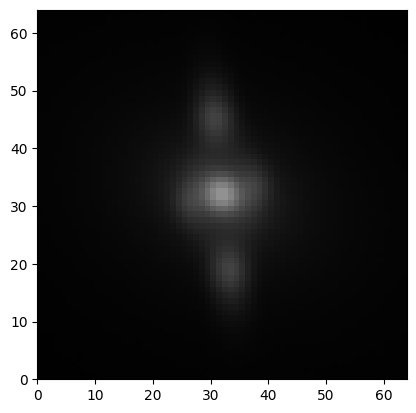

SL_sim_gal2/SL214.png


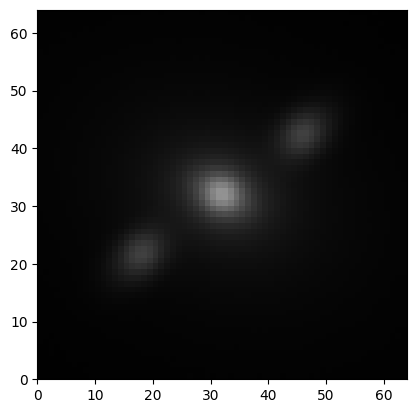

SL_sim_gal2/SL215.png


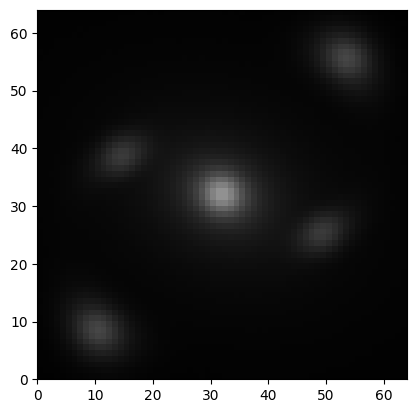

SL_sim_gal2/SL216.png


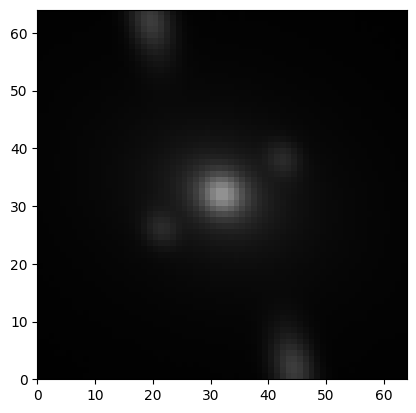

SL_sim_gal2/SL217.png


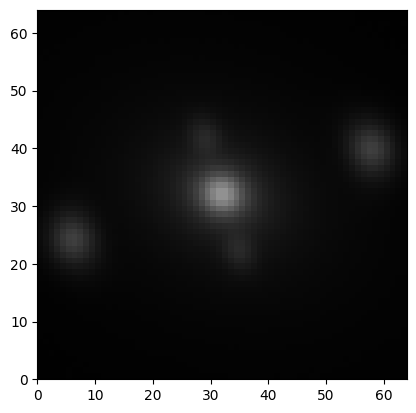

SL_sim_gal2/SL218.png


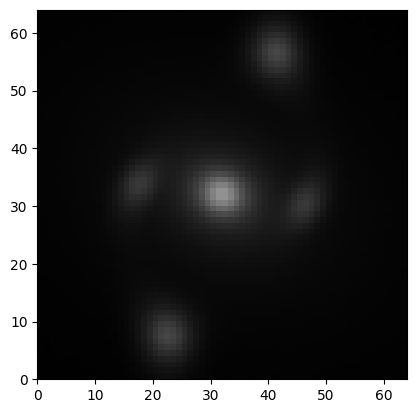

SL_sim_gal2/SL219.png


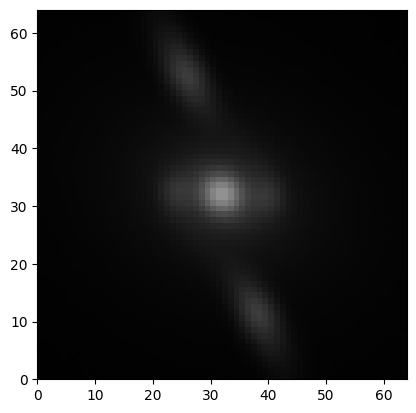

SL_sim_gal2/SL220.png


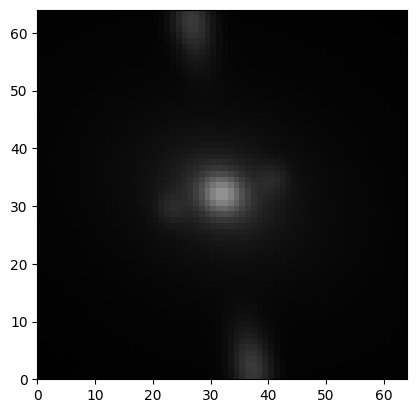

SL_sim_gal2/SL221.png


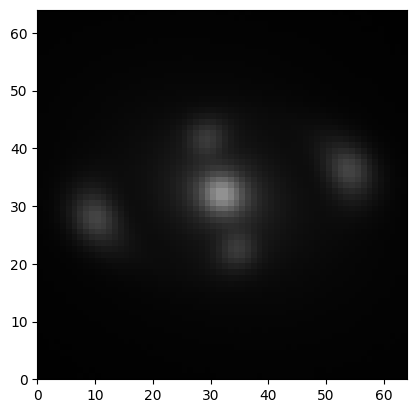

SL_sim_gal2/SL222.png


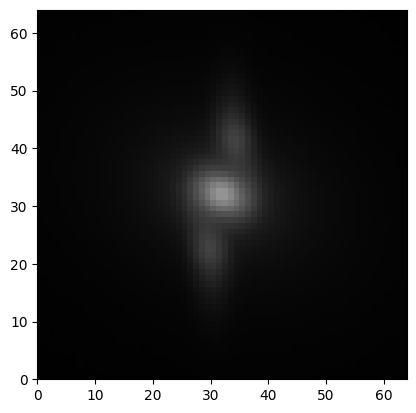

SL_sim_gal2/SL223.png


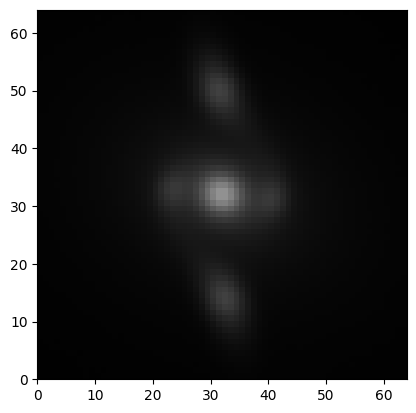

SL_sim_gal2/SL224.png


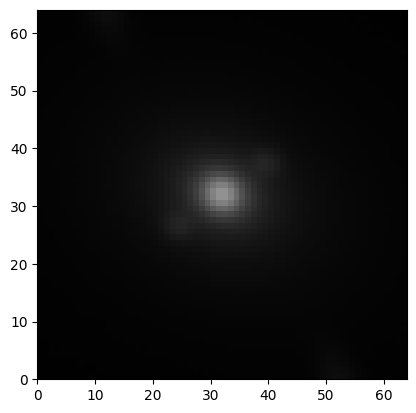

SL_sim_gal2/SL225.png


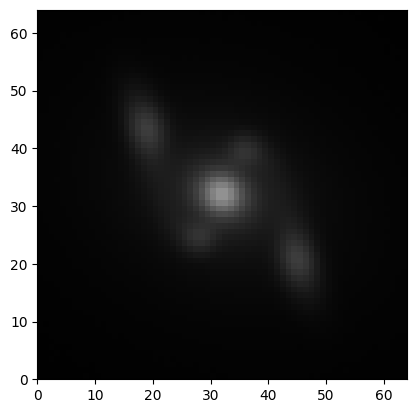

SL_sim_gal2/SL226.png


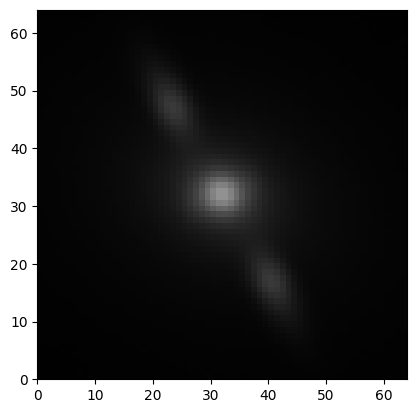

SL_sim_gal2/SL227.png


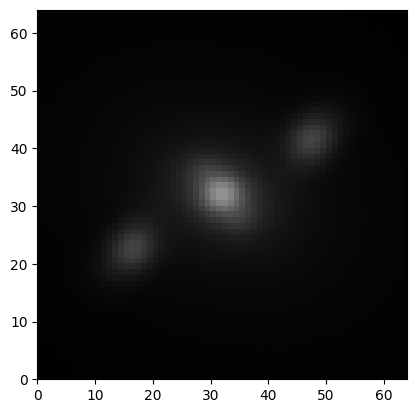

SL_sim_gal2/SL228.png


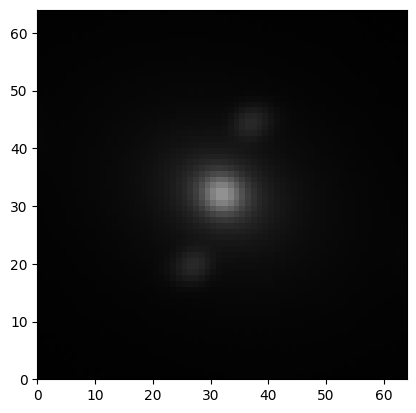

SL_sim_gal2/SL229.png


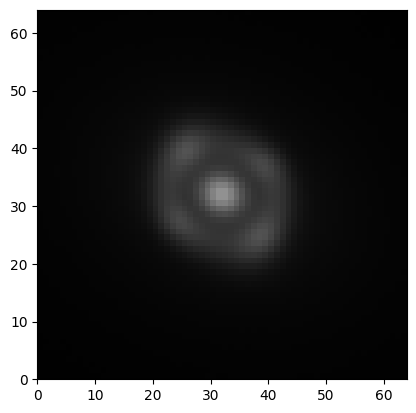

SL_sim_gal2/SL230.png


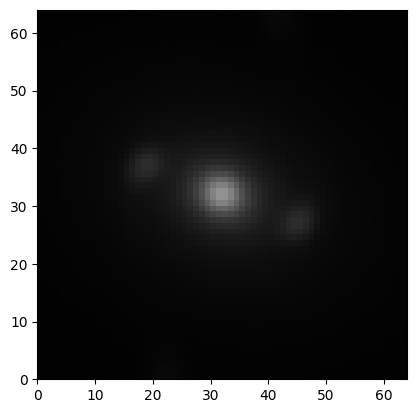

SL_sim_gal2/SL231.png


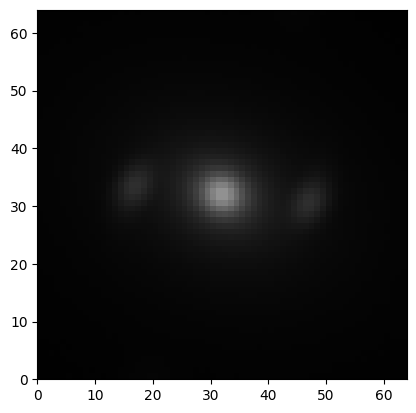

SL_sim_gal2/SL232.png


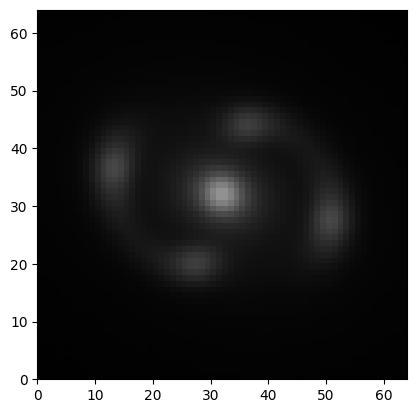

SL_sim_gal2/SL233.png


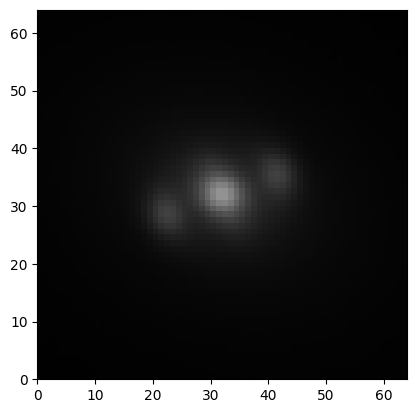

SL_sim_gal2/SL234.png


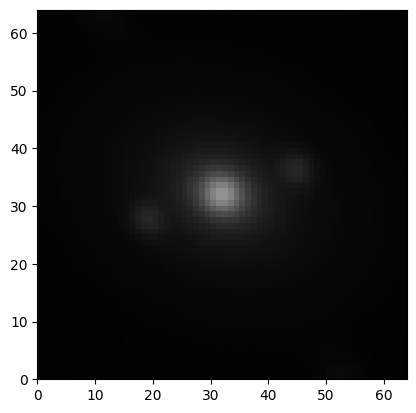

SL_sim_gal2/SL235.png


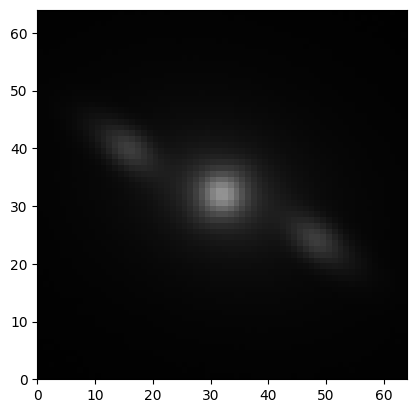

SL_sim_gal2/SL236.png


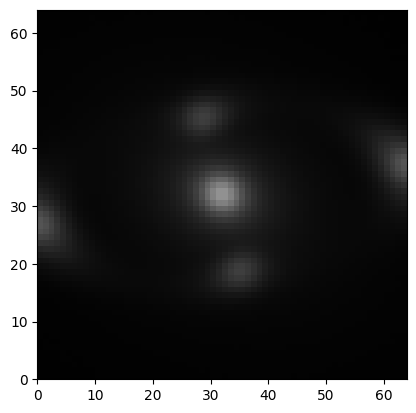

SL_sim_gal2/SL237.png


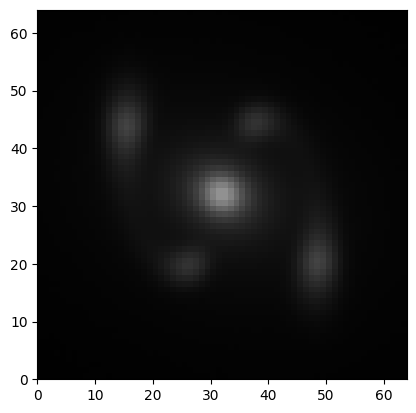

SL_sim_gal2/SL238.png


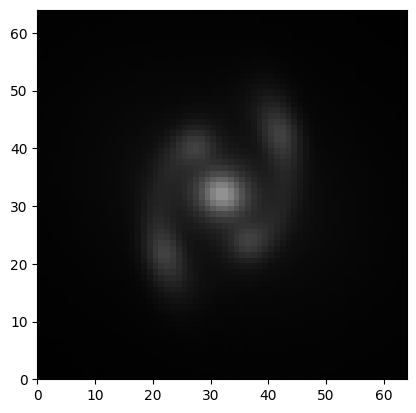

SL_sim_gal2/SL239.png


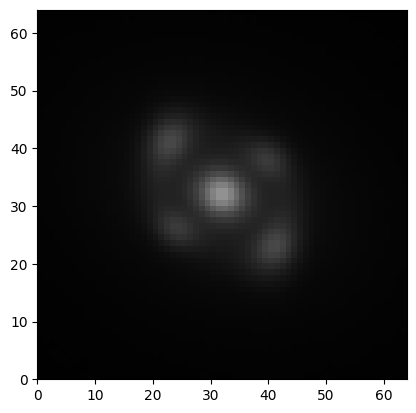

SL_sim_gal2/SL240.png


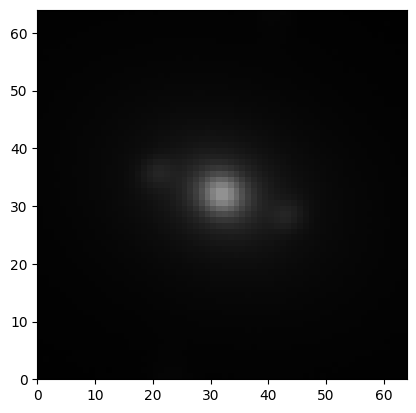

SL_sim_gal2/SL241.png


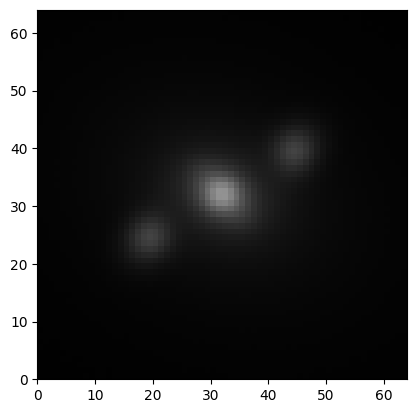

SL_sim_gal2/SL242.png


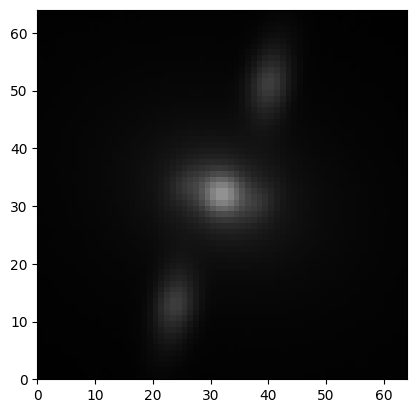

SL_sim_gal2/SL243.png


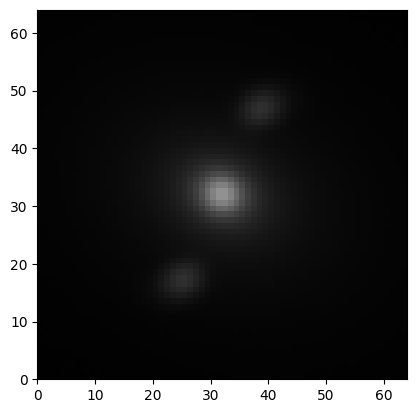

SL_sim_gal2/SL244.png


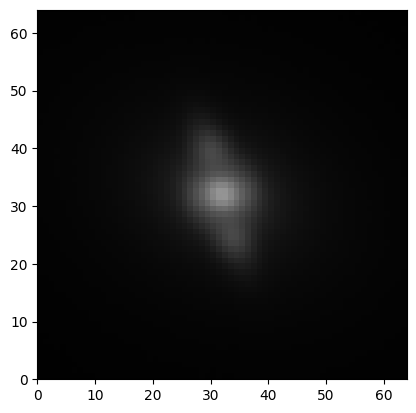

SL_sim_gal2/SL245.png


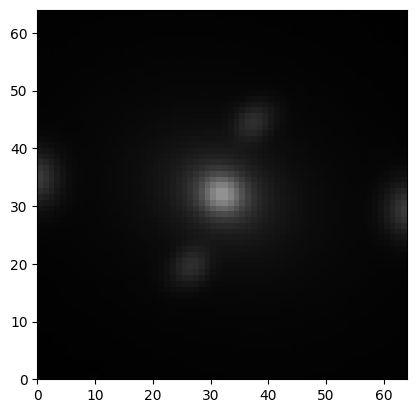

SL_sim_gal2/SL246.png


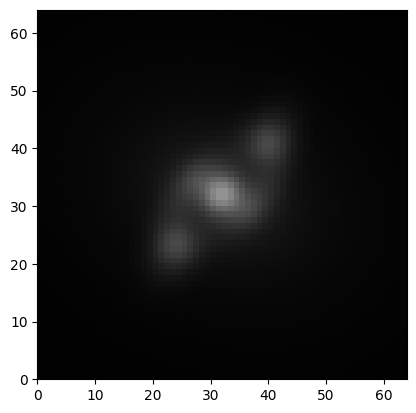

SL_sim_gal2/SL247.png


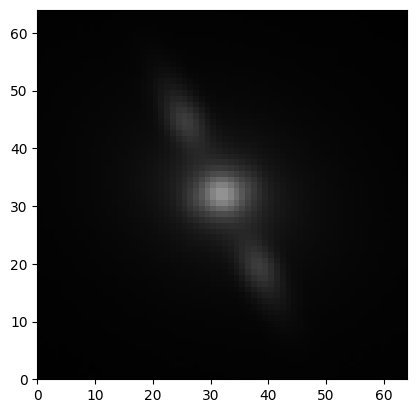

SL_sim_gal2/SL248.png


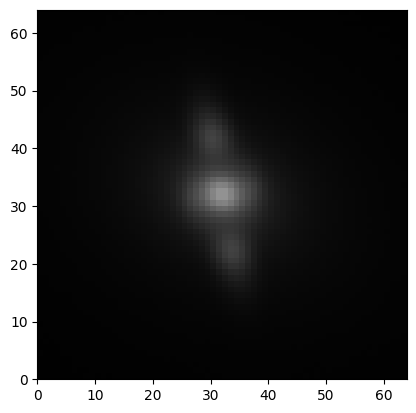

SL_sim_gal2/SL249.png


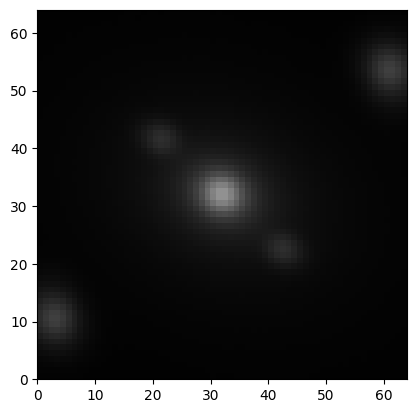

SL_sim_gal2/SL250.png


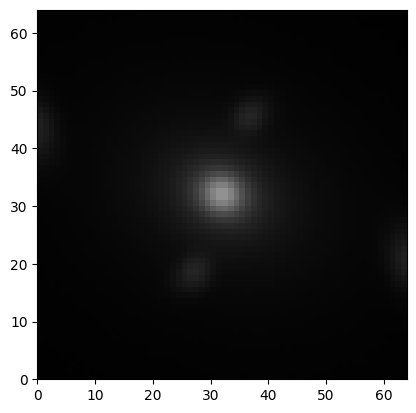

SL_sim_gal2/SL251.png


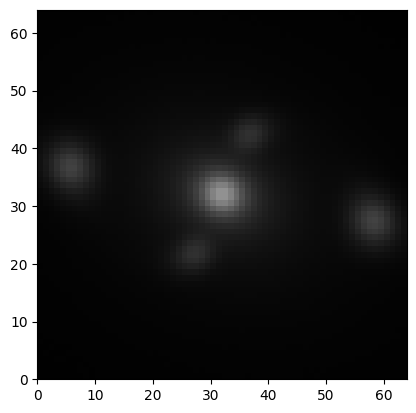

SL_sim_gal2/SL252.png


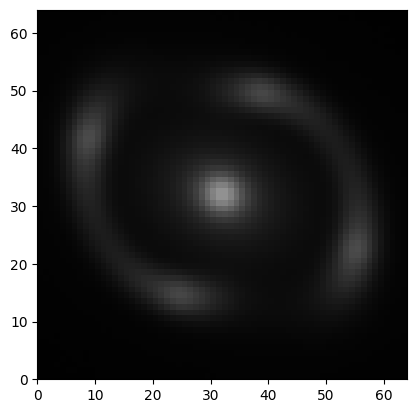

SL_sim_gal2/SL253.png


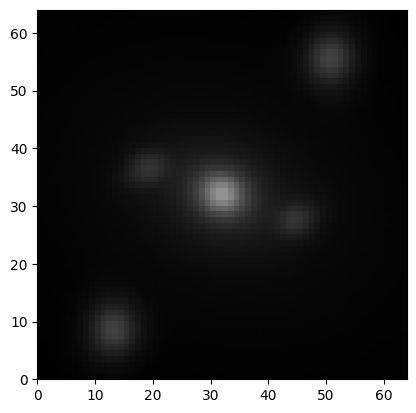

SL_sim_gal2/SL254.png


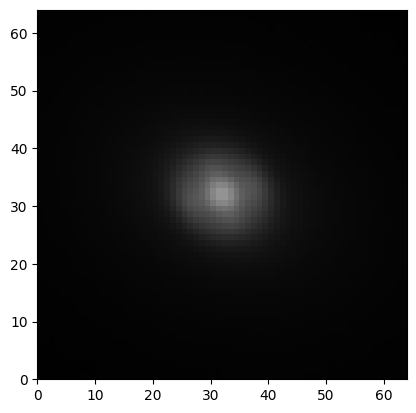

SL_sim_gal2/SL255.png


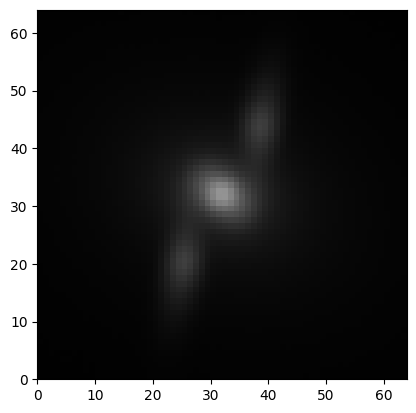

SL_sim_gal2/SL256.png


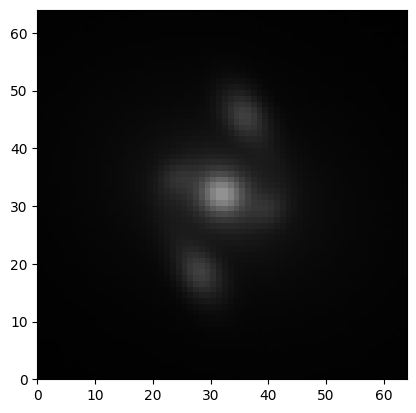

SL_sim_gal2/SL257.png


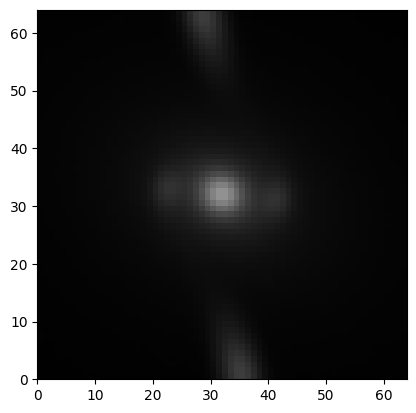

SL_sim_gal2/SL258.png


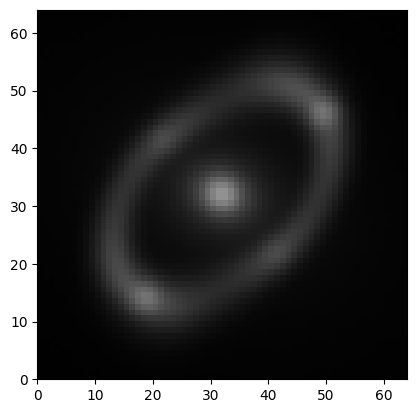

SL_sim_gal2/SL259.png


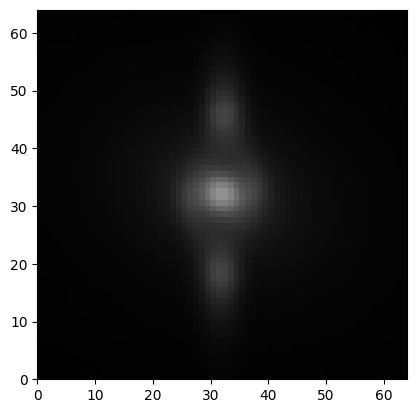

SL_sim_gal2/SL260.png


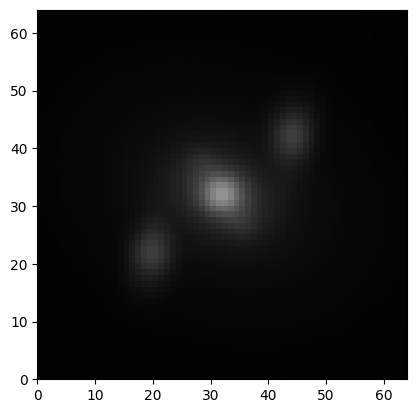

SL_sim_gal2/SL261.png


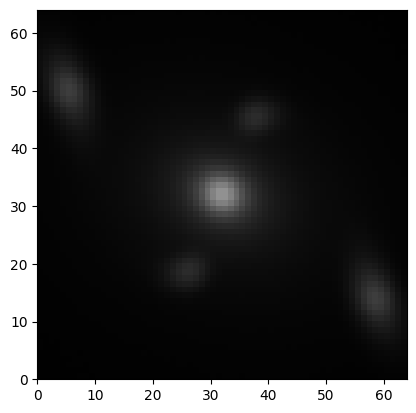

SL_sim_gal2/SL262.png


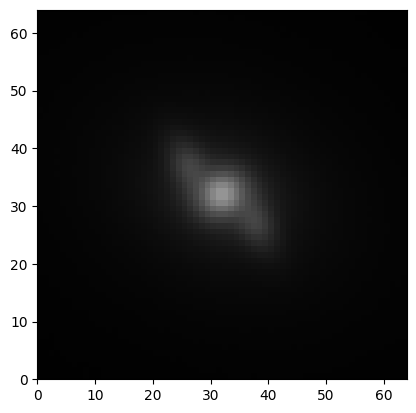

SL_sim_gal2/SL263.png


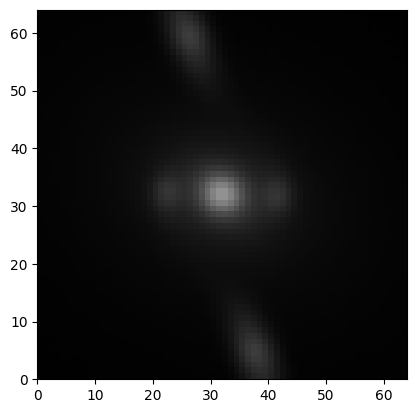

SL_sim_gal2/SL264.png


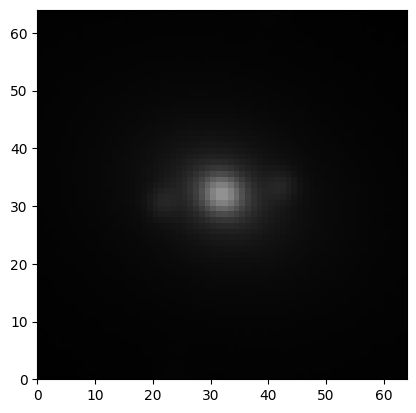

SL_sim_gal2/SL265.png


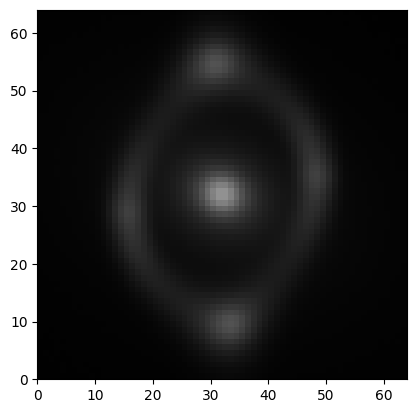

SL_sim_gal2/SL266.png


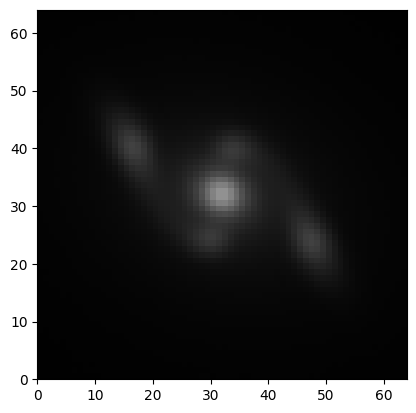

SL_sim_gal2/SL267.png


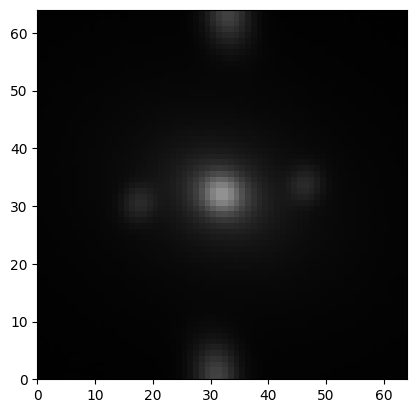

SL_sim_gal2/SL268.png


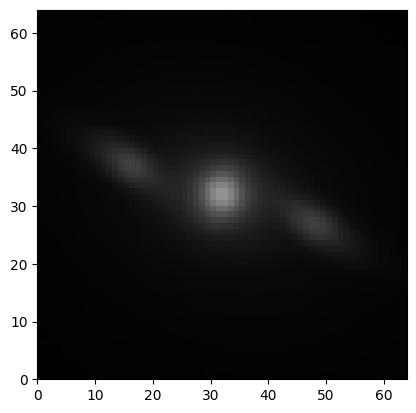

SL_sim_gal2/SL269.png


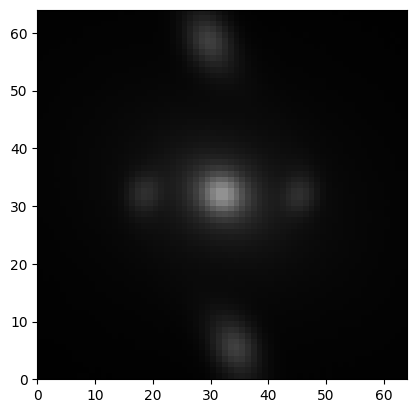

SL_sim_gal2/SL270.png


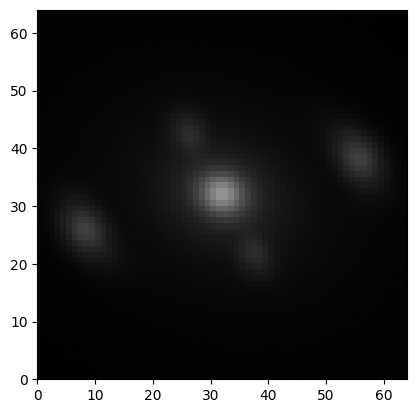

SL_sim_gal2/SL271.png


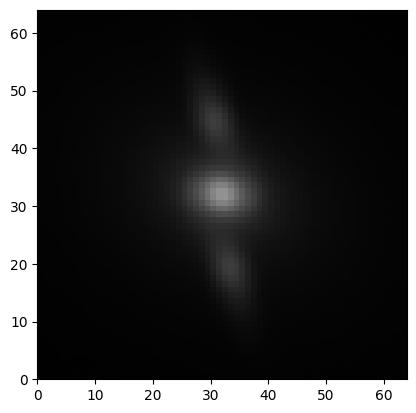

SL_sim_gal2/SL272.png


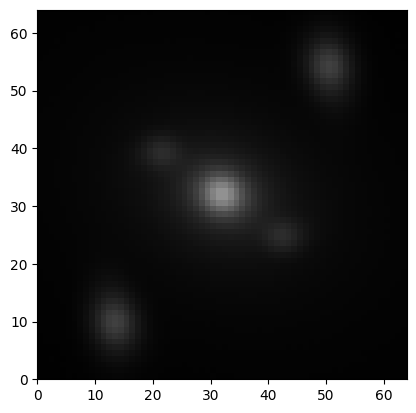

SL_sim_gal2/SL273.png


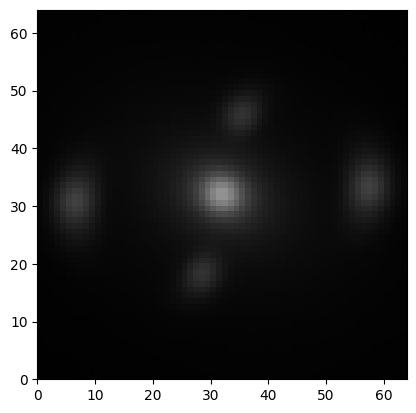

SL_sim_gal2/SL274.png


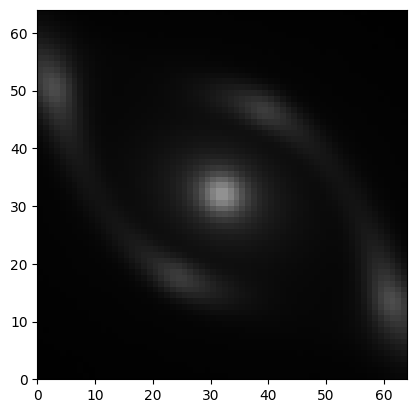

SL_sim_gal2/SL275.png


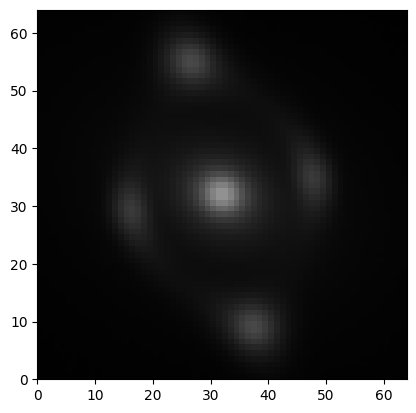

SL_sim_gal2/SL276.png


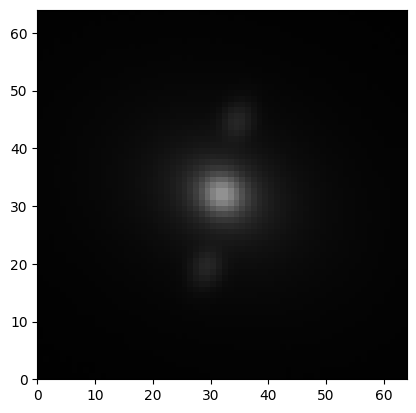

SL_sim_gal2/SL277.png


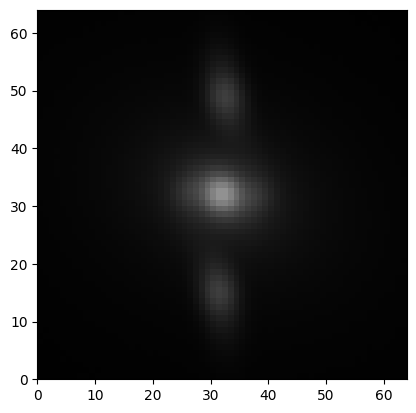

SL_sim_gal2/SL278.png


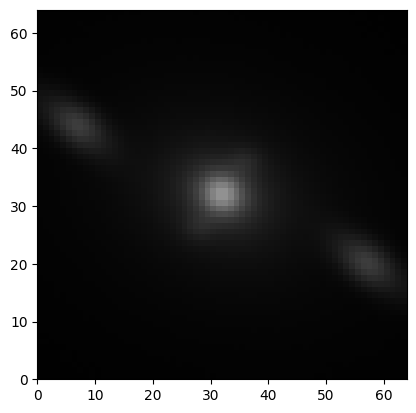

SL_sim_gal2/SL279.png


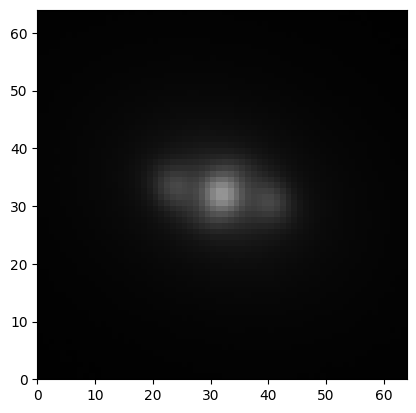

SL_sim_gal2/SL280.png


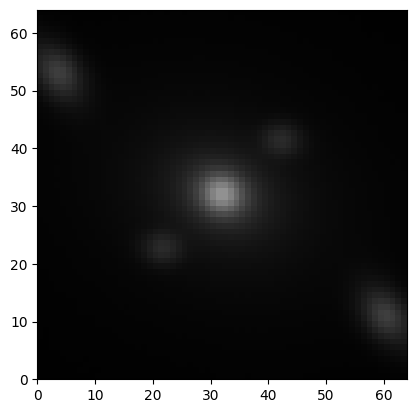

SL_sim_gal2/SL281.png


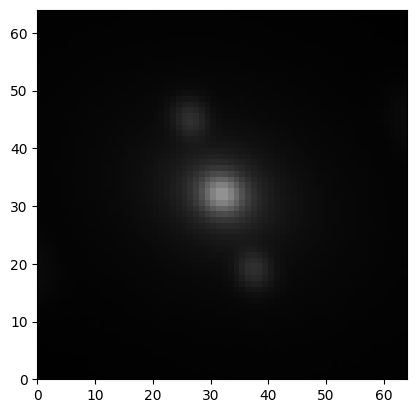

SL_sim_gal2/SL282.png


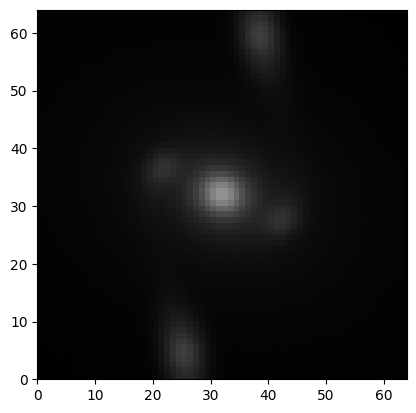

SL_sim_gal2/SL283.png


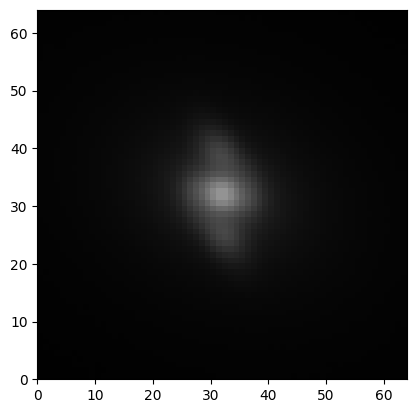

SL_sim_gal2/SL284.png


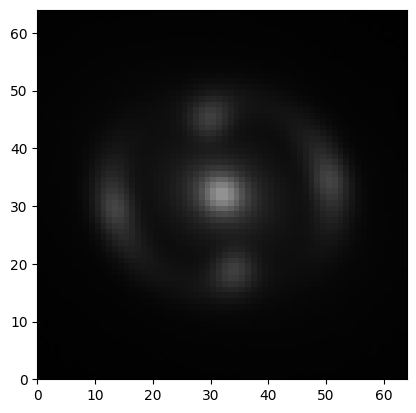

SL_sim_gal2/SL285.png


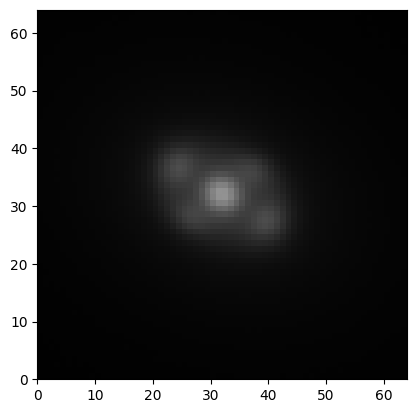

SL_sim_gal2/SL286.png


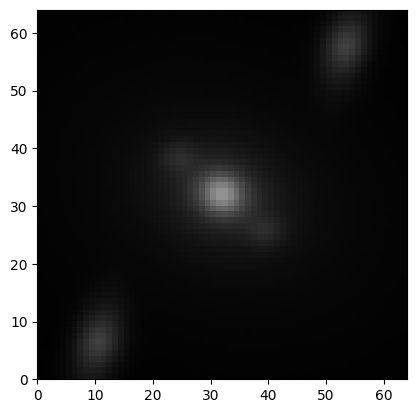

SL_sim_gal2/SL287.png


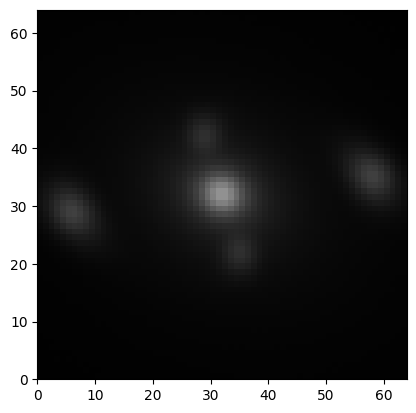

SL_sim_gal2/SL288.png


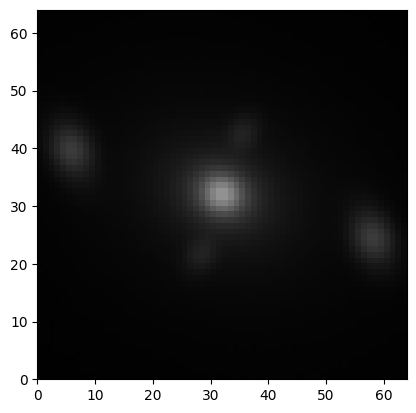

SL_sim_gal2/SL289.png


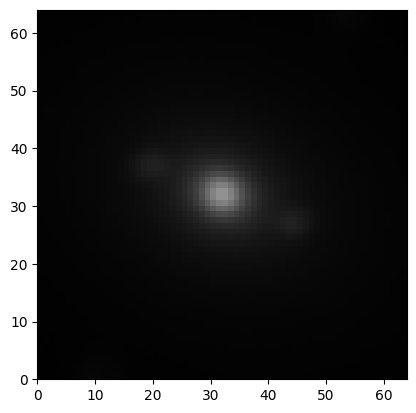

SL_sim_gal2/SL290.png


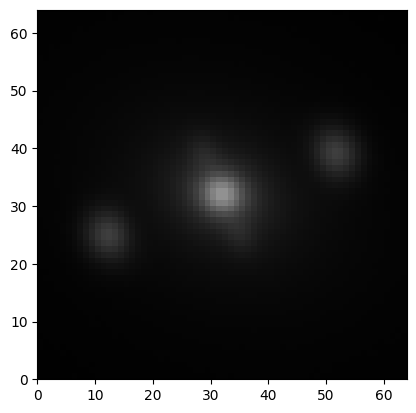

SL_sim_gal2/SL291.png


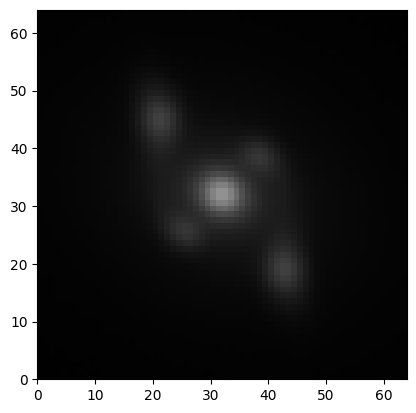

SL_sim_gal2/SL292.png


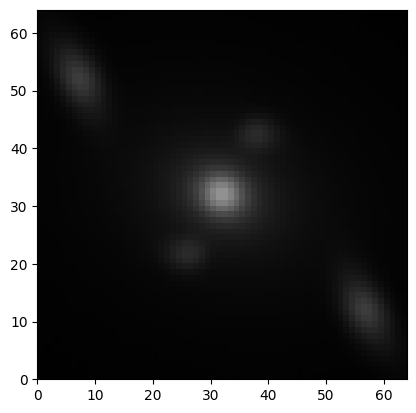

SL_sim_gal2/SL293.png


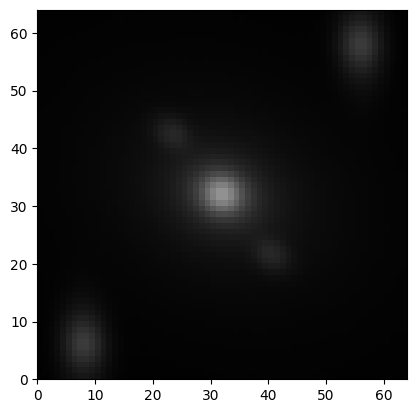

SL_sim_gal2/SL294.png


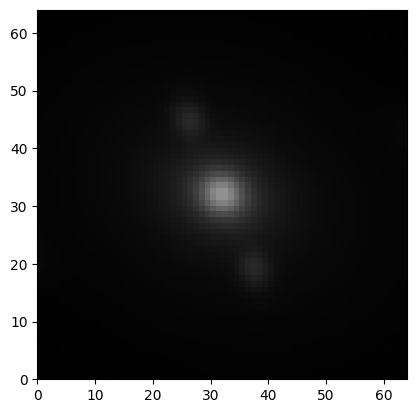

SL_sim_gal2/SL295.png


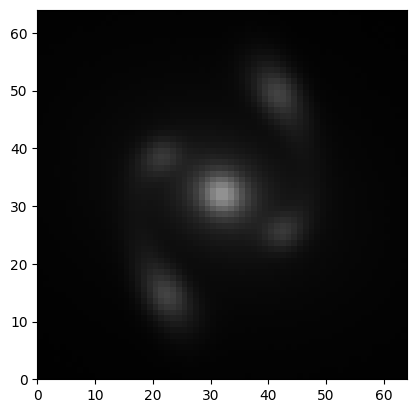

SL_sim_gal2/SL296.png


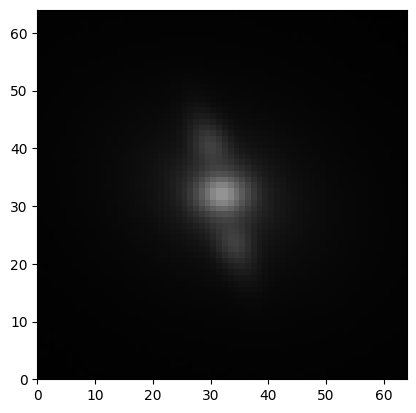

SL_sim_gal2/SL297.png


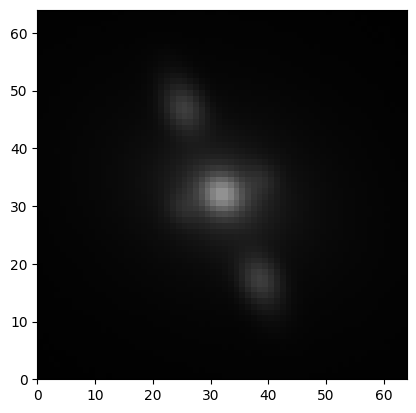

SL_sim_gal2/SL298.png


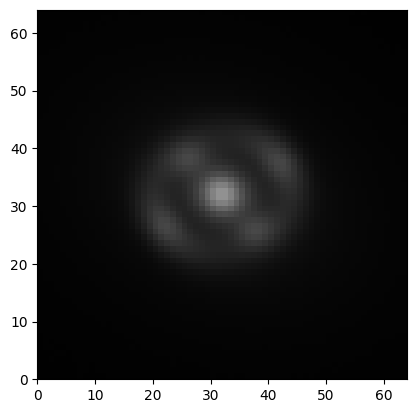

SL_sim_gal2/SL299.png


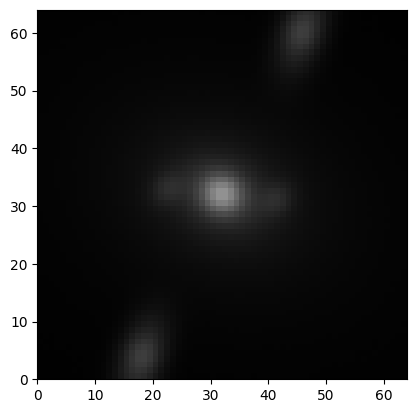

SL_sim_gal2/SL300.png


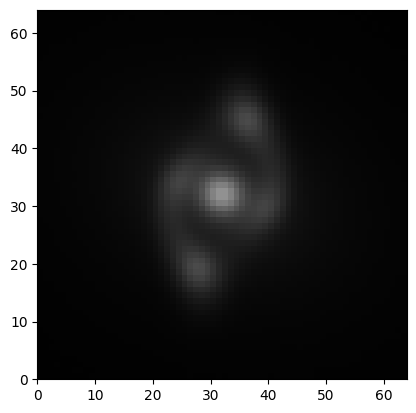

SL_sim_gal2/SL301.png


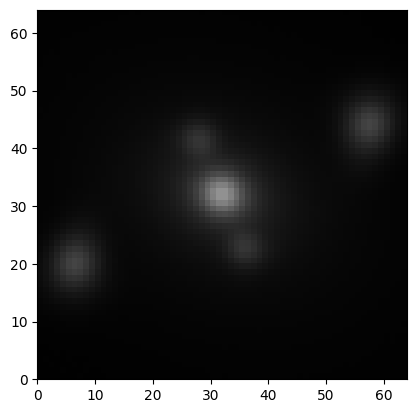

SL_sim_gal2/SL302.png


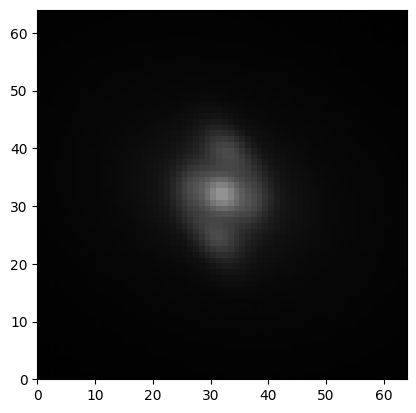

SL_sim_gal2/SL303.png


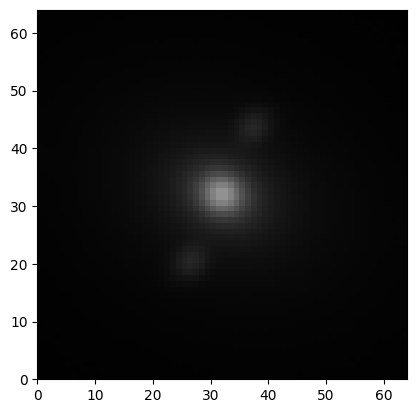

SL_sim_gal2/SL304.png


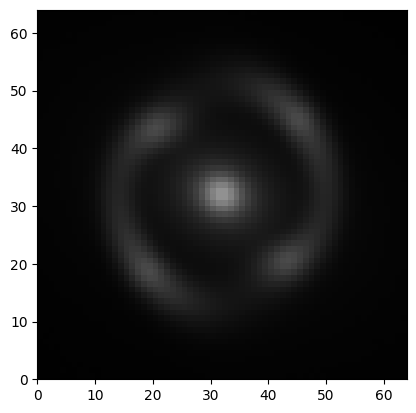

SL_sim_gal2/SL305.png


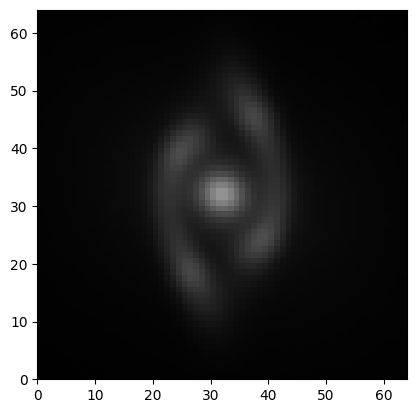

SL_sim_gal2/SL306.png


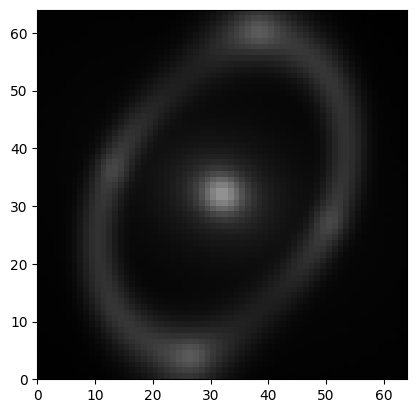

SL_sim_gal2/SL307.png


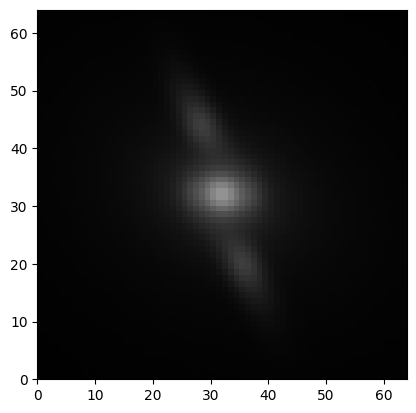

SL_sim_gal2/SL308.png


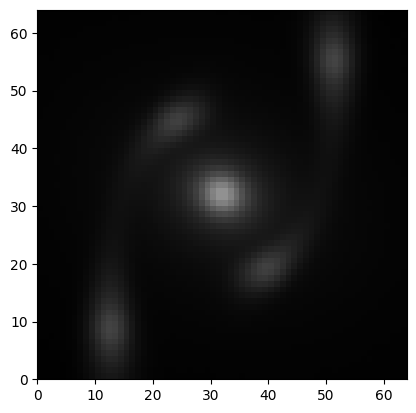

SL_sim_gal2/SL309.png


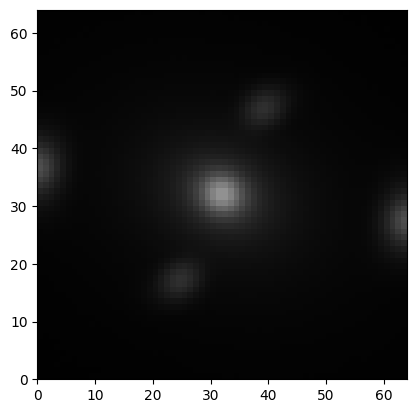

SL_sim_gal2/SL310.png


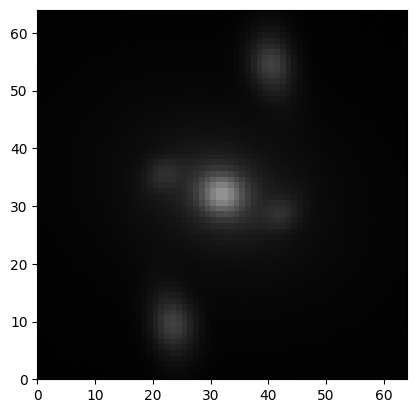

SL_sim_gal2/SL311.png


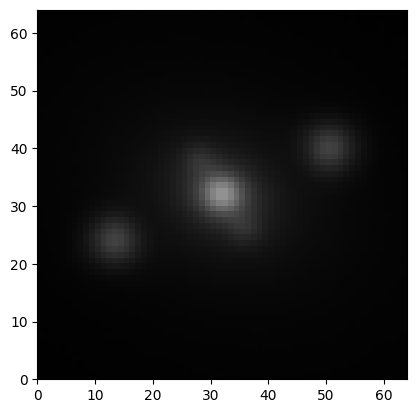

SL_sim_gal2/SL312.png


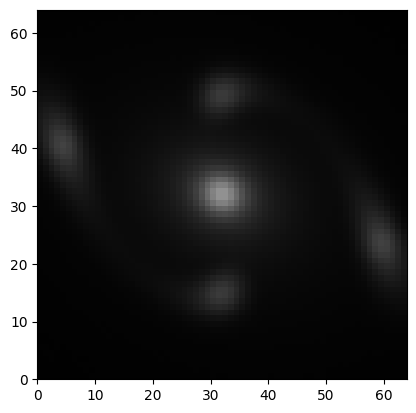

SL_sim_gal2/SL313.png


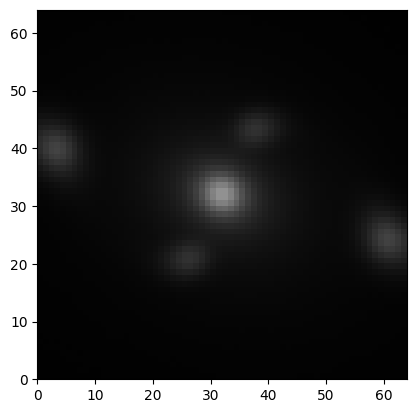

SL_sim_gal2/SL314.png


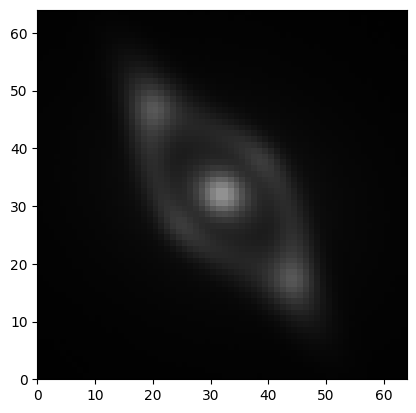

SL_sim_gal2/SL315.png


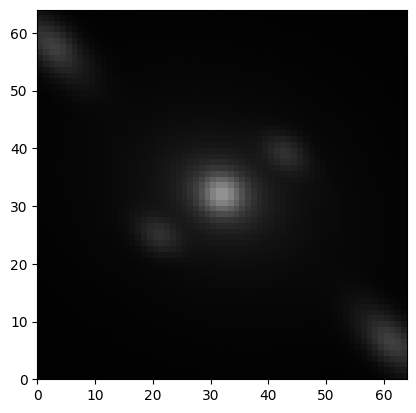

SL_sim_gal2/SL316.png


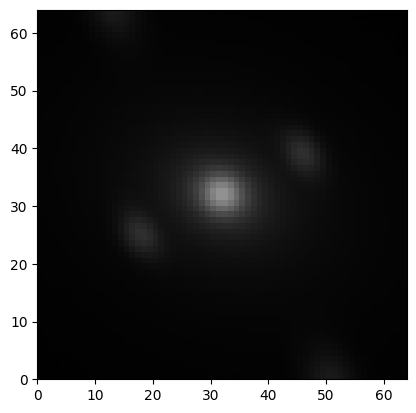

SL_sim_gal2/SL317.png


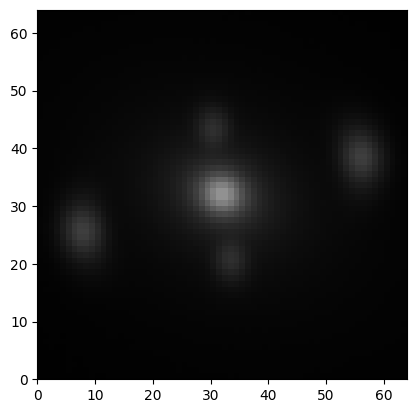

SL_sim_gal2/SL318.png


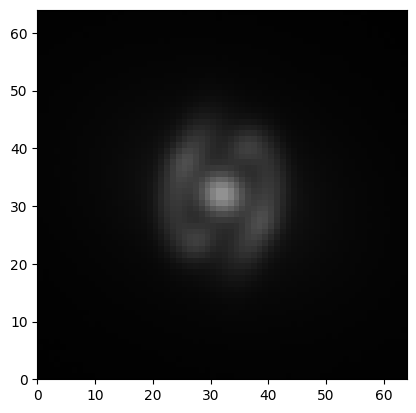

SL_sim_gal2/SL319.png


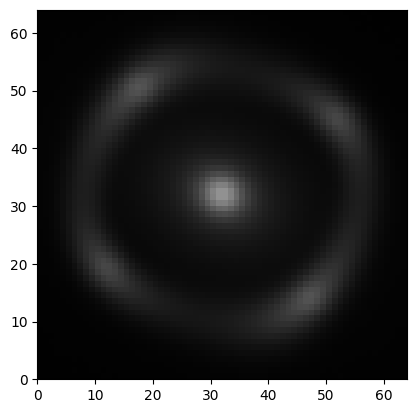

SL_sim_gal2/SL320.png


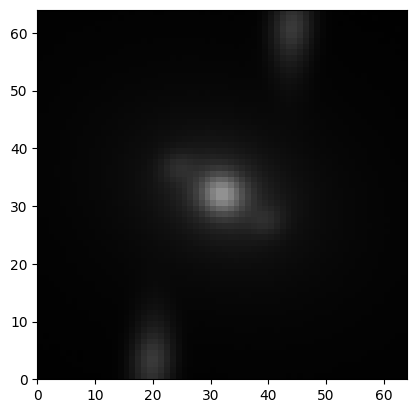

SL_sim_gal2/SL321.png


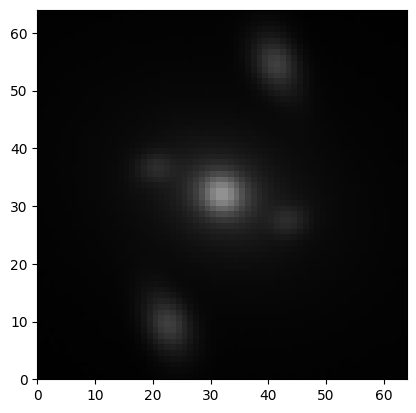

SL_sim_gal2/SL322.png


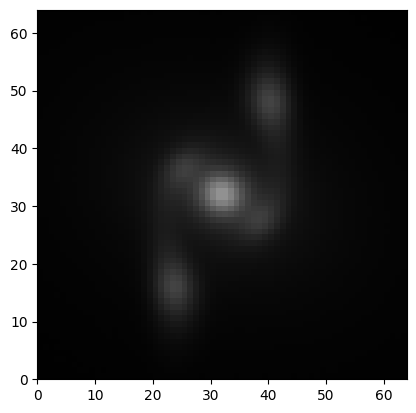

SL_sim_gal2/SL323.png


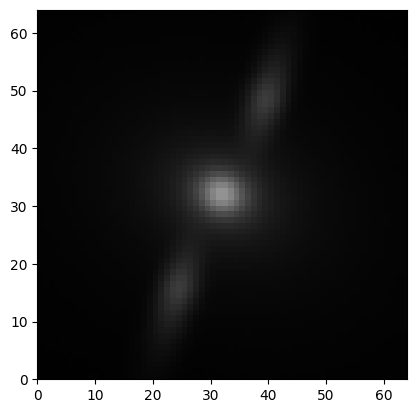

SL_sim_gal2/SL324.png


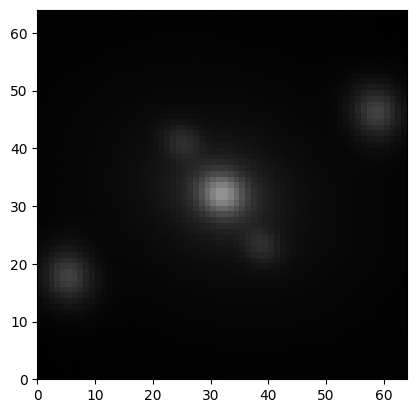

SL_sim_gal2/SL325.png


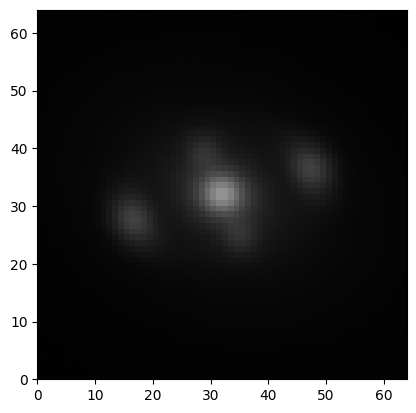

SL_sim_gal2/SL326.png


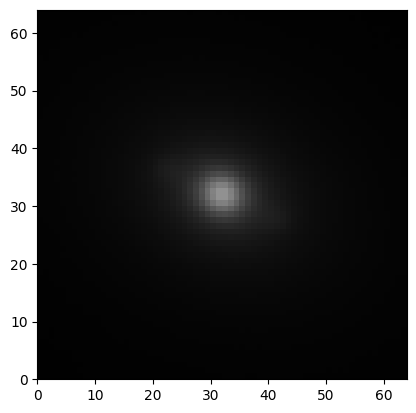

SL_sim_gal2/SL327.png


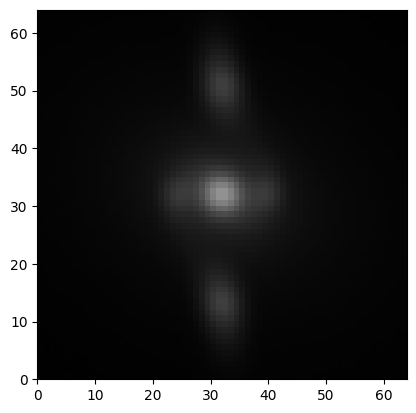

SL_sim_gal2/SL328.png


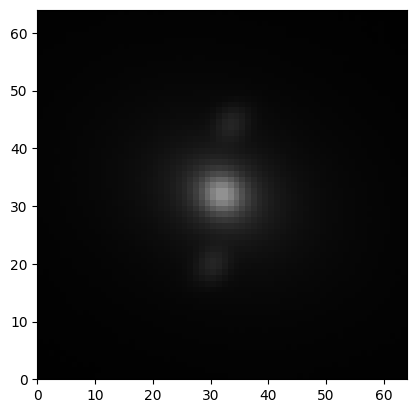

SL_sim_gal2/SL329.png


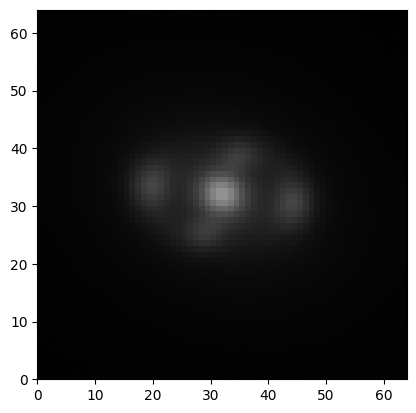

SL_sim_gal2/SL330.png


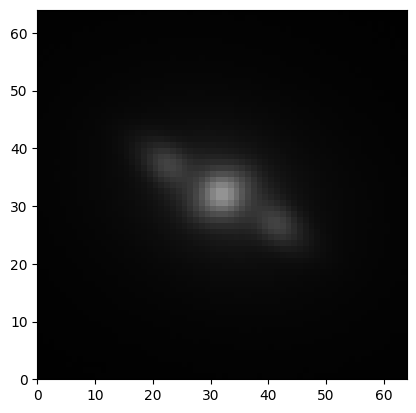

SL_sim_gal2/SL331.png


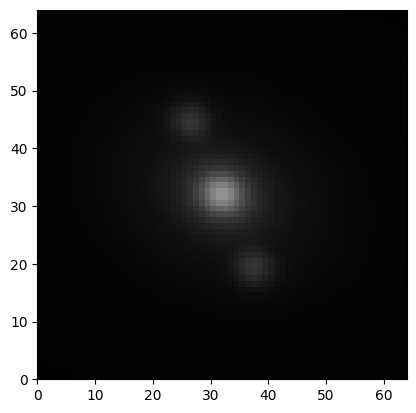

SL_sim_gal2/SL332.png


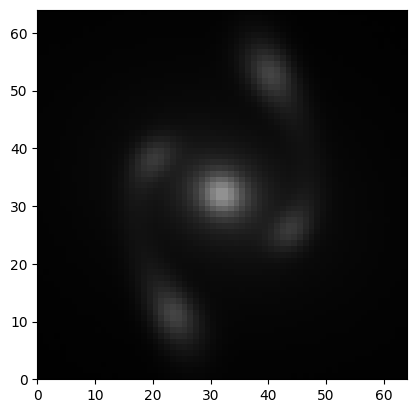

SL_sim_gal2/SL333.png


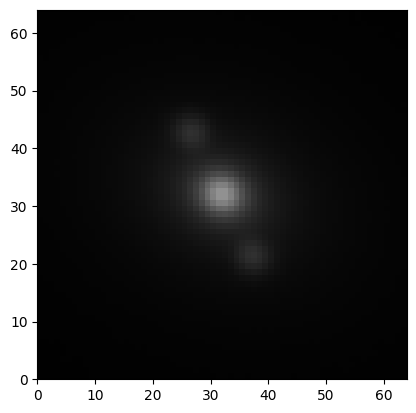

SL_sim_gal2/SL334.png


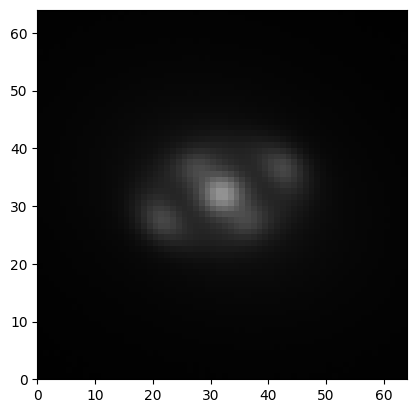

SL_sim_gal2/SL335.png


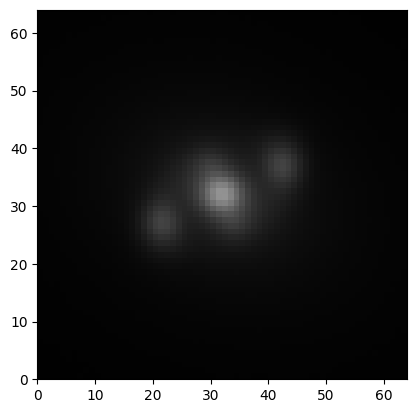

SL_sim_gal2/SL336.png


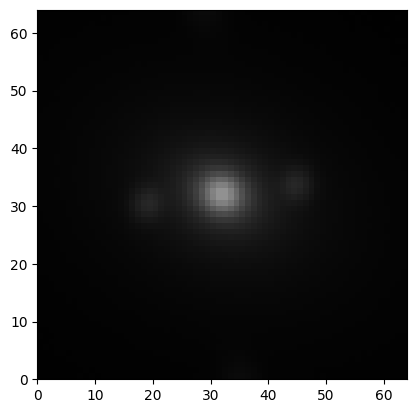

SL_sim_gal2/SL337.png


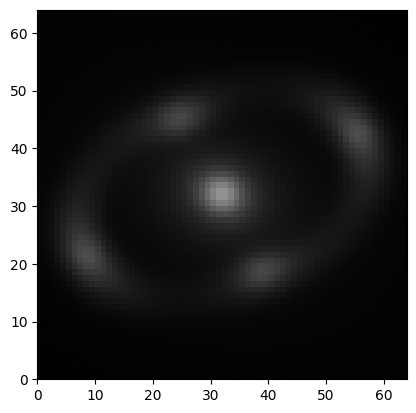

SL_sim_gal2/SL338.png


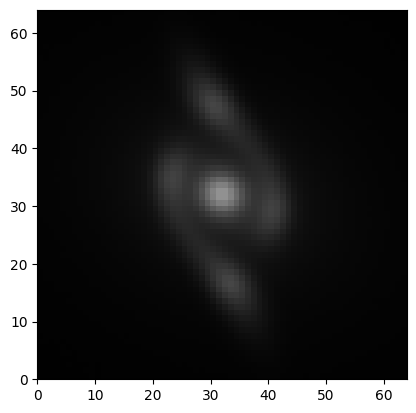

SL_sim_gal2/SL339.png


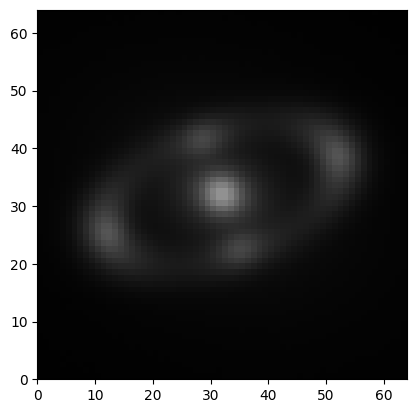

SL_sim_gal2/SL340.png


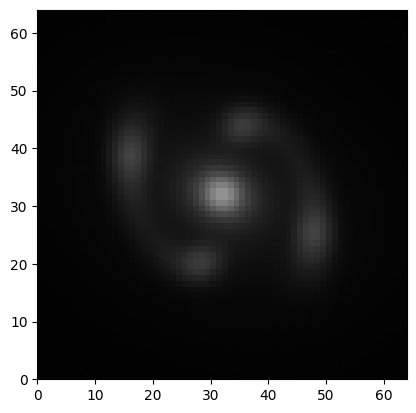

SL_sim_gal2/SL341.png


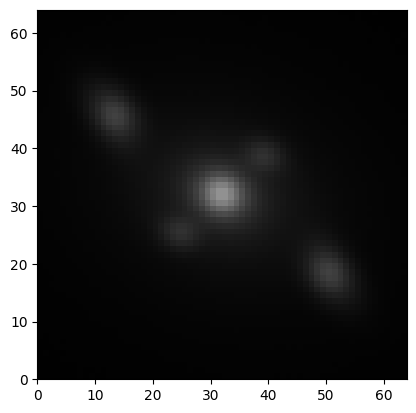

SL_sim_gal2/SL342.png


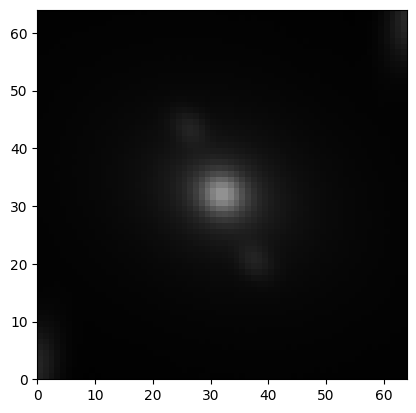

SL_sim_gal2/SL343.png


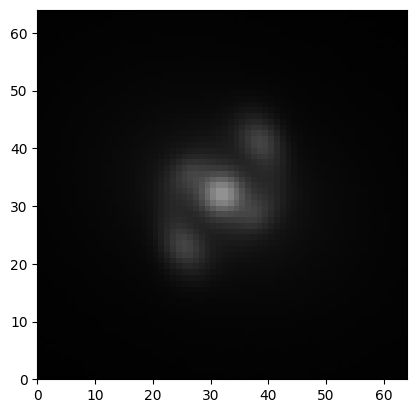

SL_sim_gal2/SL344.png


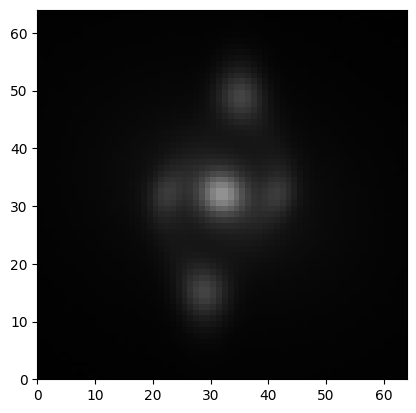

SL_sim_gal2/SL345.png


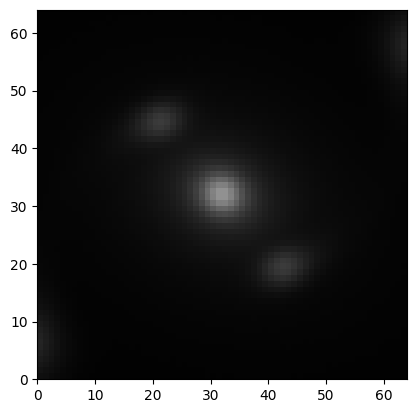

SL_sim_gal2/SL346.png


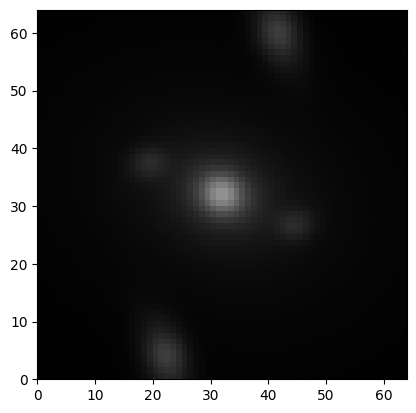

SL_sim_gal2/SL347.png


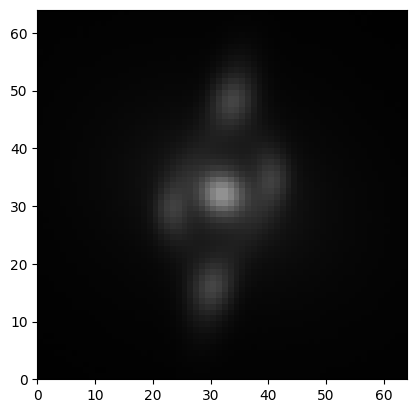

SL_sim_gal2/SL348.png


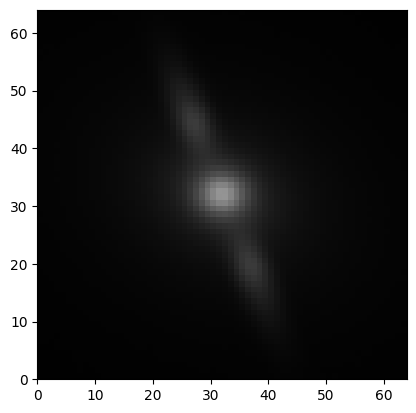

SL_sim_gal2/SL349.png


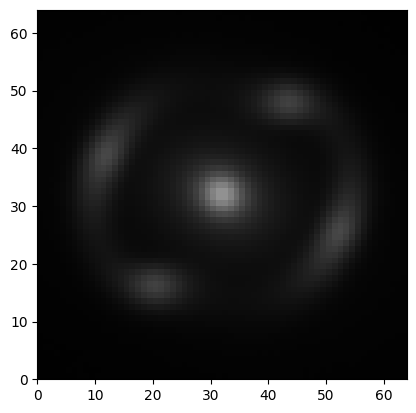

SL_sim_gal2/SL350.png


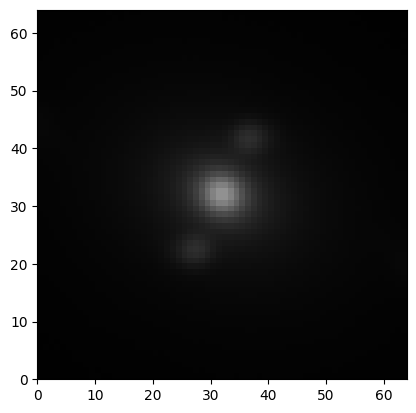

SL_sim_gal2/SL351.png


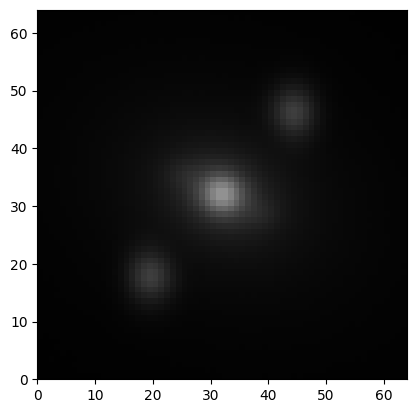

SL_sim_gal2/SL352.png


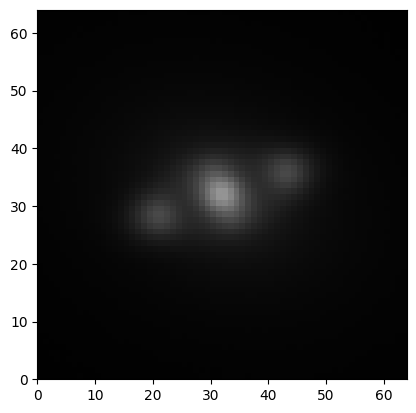

SL_sim_gal2/SL353.png


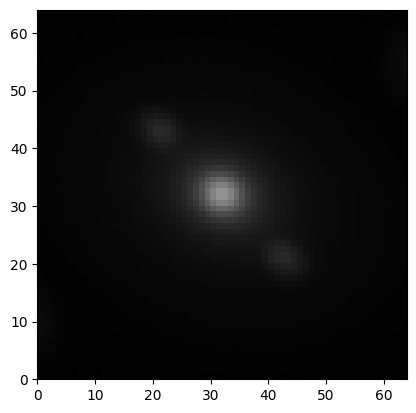

SL_sim_gal2/SL354.png


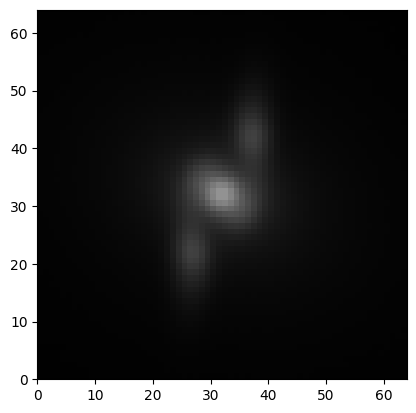

SL_sim_gal2/SL355.png


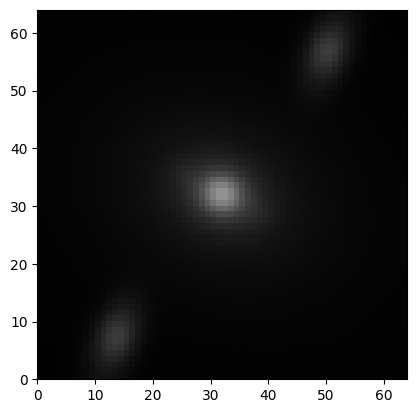

SL_sim_gal2/SL356.png


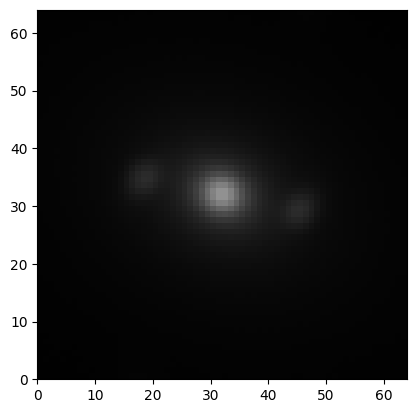

SL_sim_gal2/SL357.png


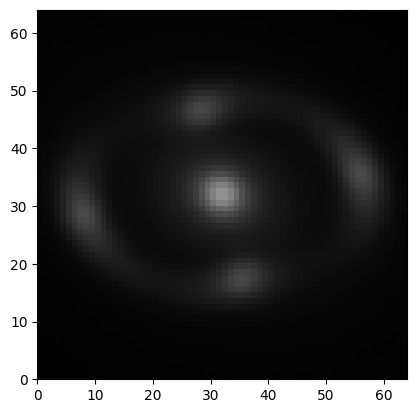

SL_sim_gal2/SL358.png


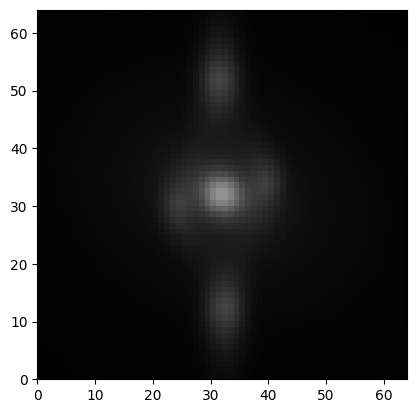

SL_sim_gal2/SL359.png


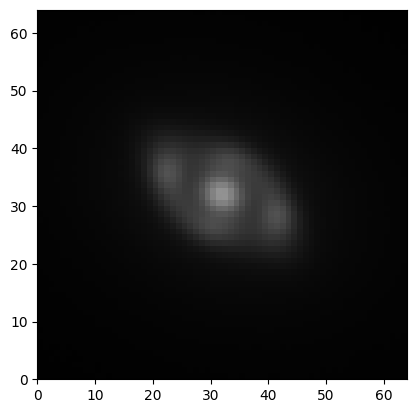

SL_sim_gal2/SL360.png


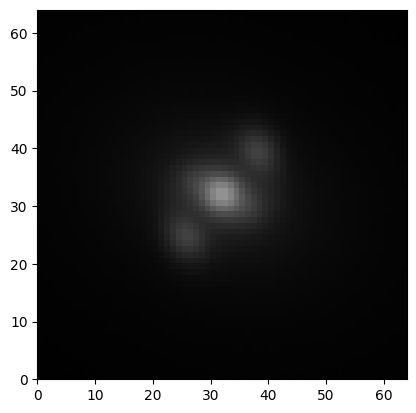

SL_sim_gal2/SL361.png


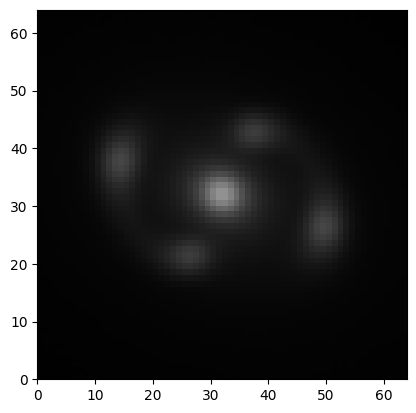

SL_sim_gal2/SL362.png


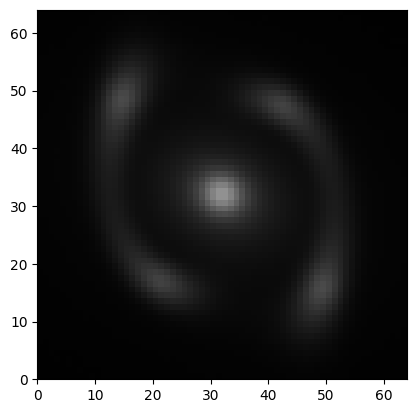

SL_sim_gal2/SL363.png


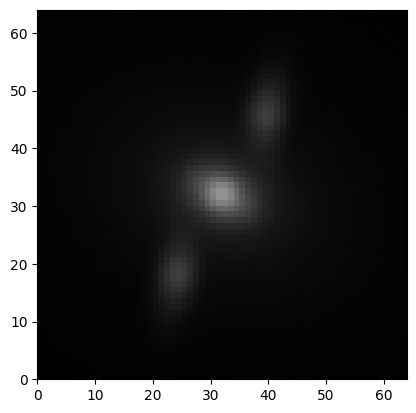

SL_sim_gal2/SL364.png


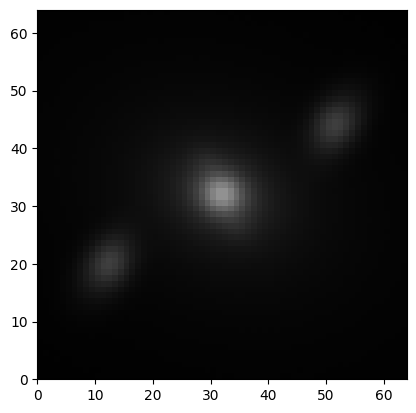

SL_sim_gal2/SL365.png


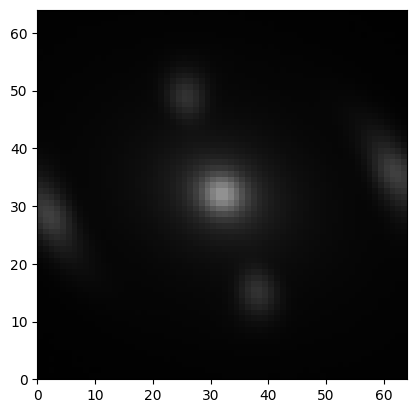

SL_sim_gal2/SL366.png


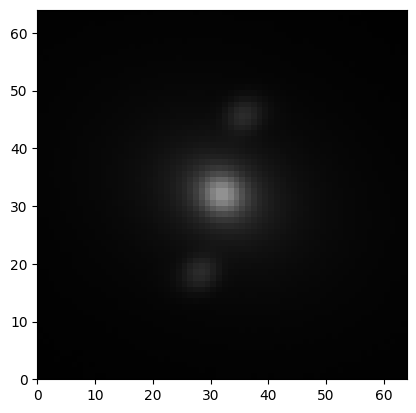

SL_sim_gal2/SL367.png


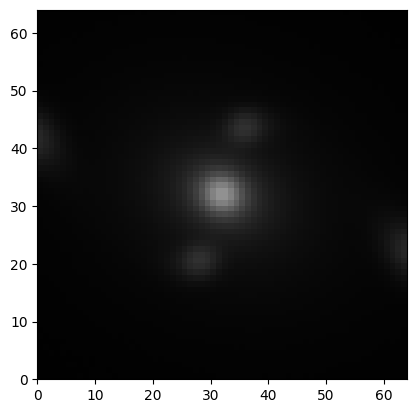

SL_sim_gal2/SL368.png


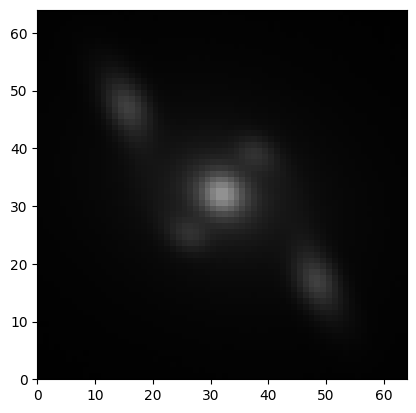

SL_sim_gal2/SL369.png


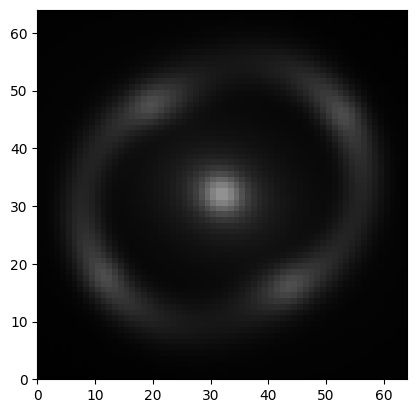

SL_sim_gal2/SL370.png


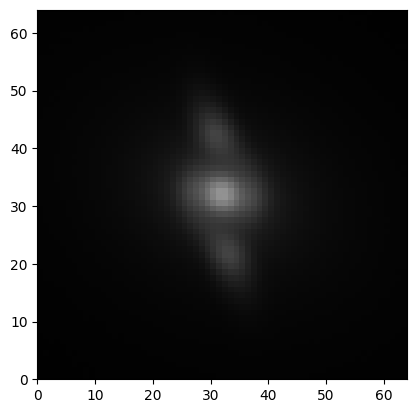

SL_sim_gal2/SL371.png


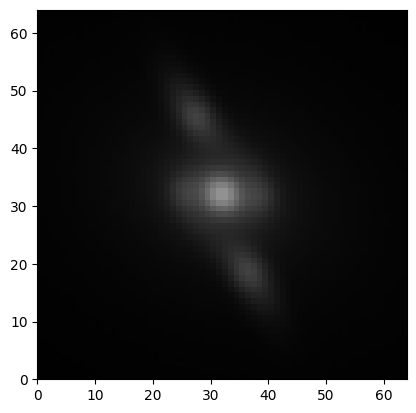

SL_sim_gal2/SL372.png


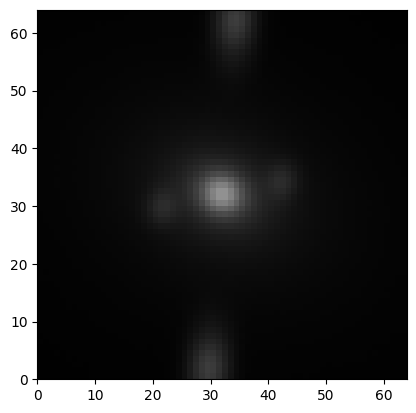

SL_sim_gal2/SL373.png


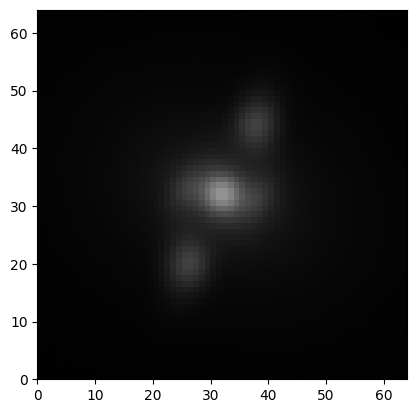

SL_sim_gal2/SL374.png


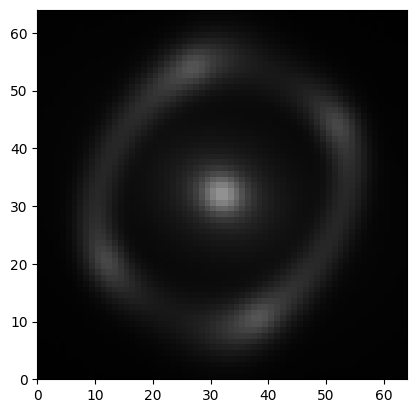

SL_sim_gal2/SL375.png


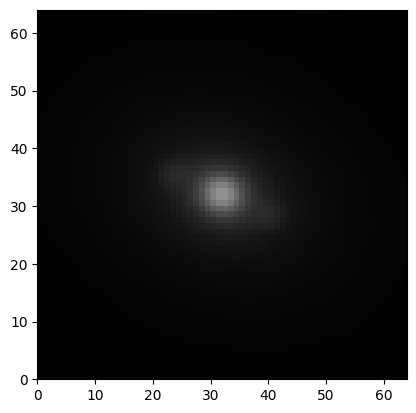

SL_sim_gal2/SL376.png


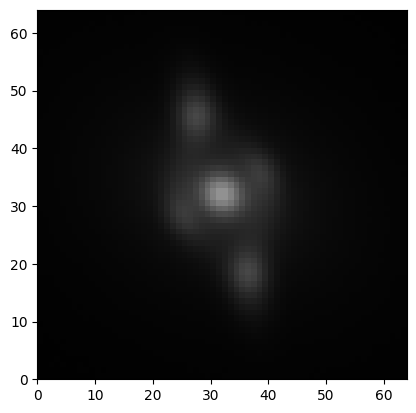

SL_sim_gal2/SL377.png


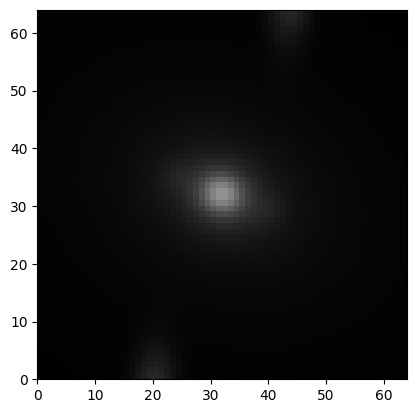

SL_sim_gal2/SL378.png


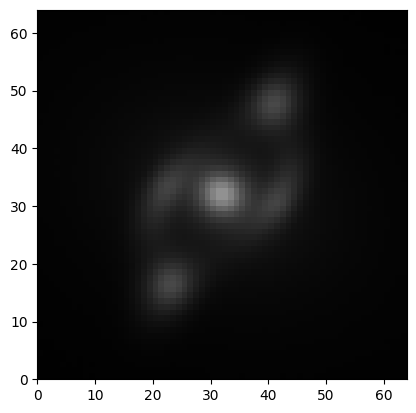

SL_sim_gal2/SL379.png


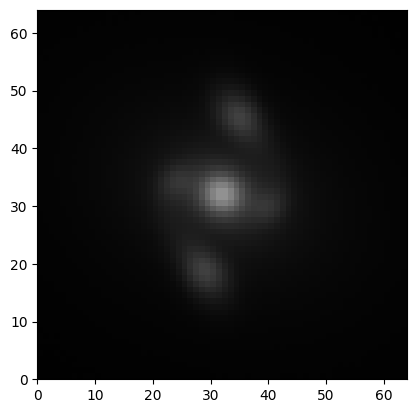

SL_sim_gal2/SL380.png


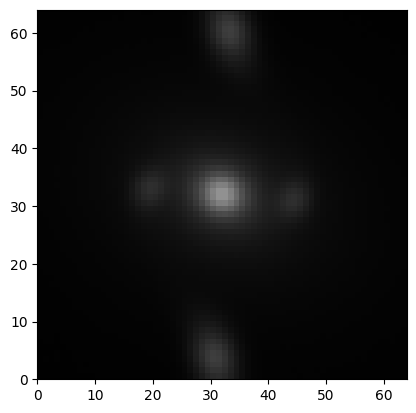

SL_sim_gal2/SL381.png


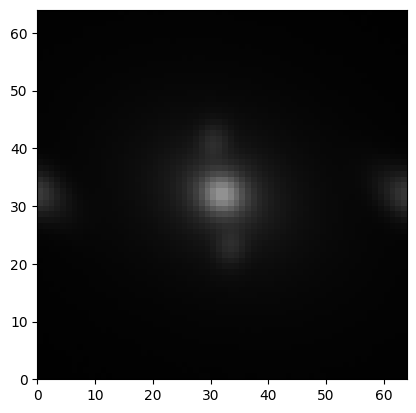

SL_sim_gal2/SL382.png


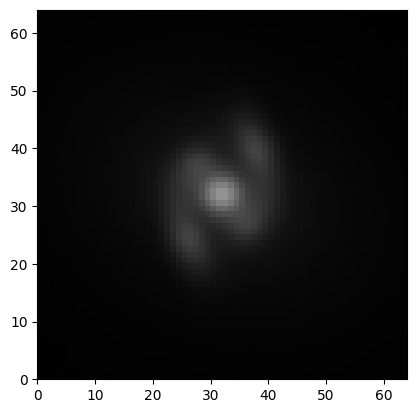

SL_sim_gal2/SL383.png


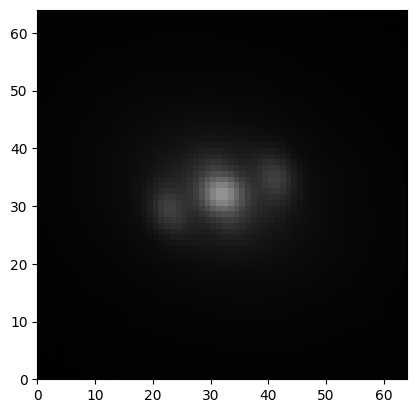

SL_sim_gal2/SL384.png


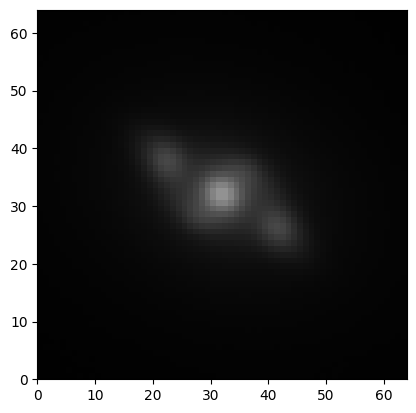

SL_sim_gal2/SL385.png


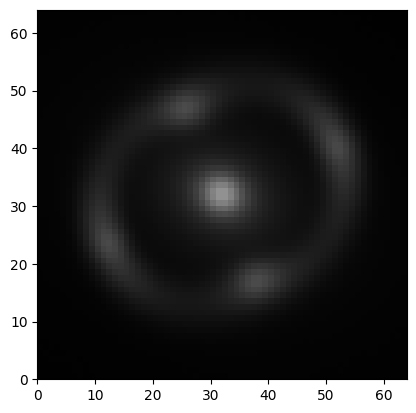

SL_sim_gal2/SL386.png


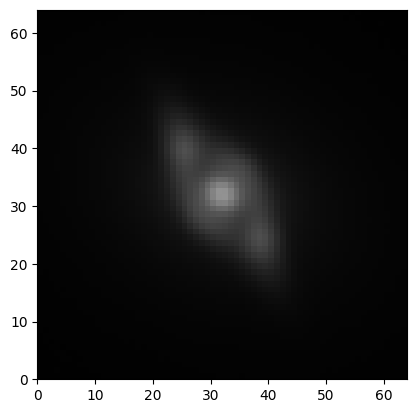

SL_sim_gal2/SL387.png


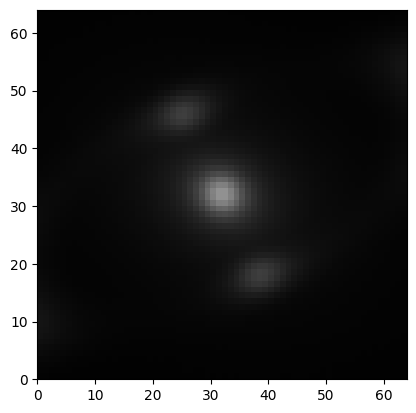

SL_sim_gal2/SL388.png


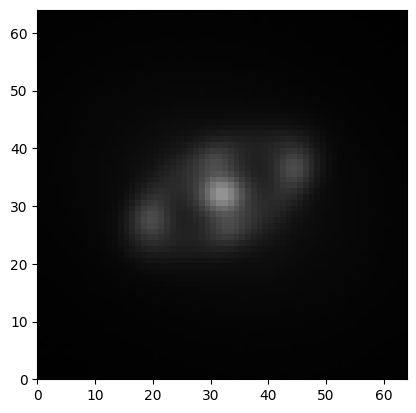

SL_sim_gal2/SL389.png


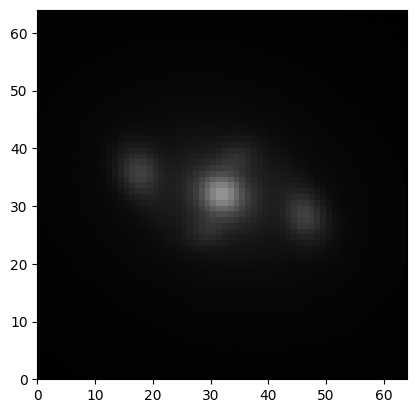

SL_sim_gal2/SL390.png


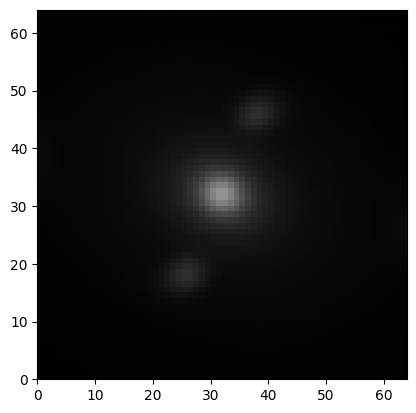

SL_sim_gal2/SL391.png


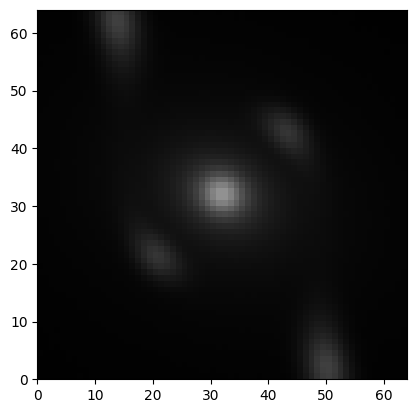

SL_sim_gal2/SL392.png


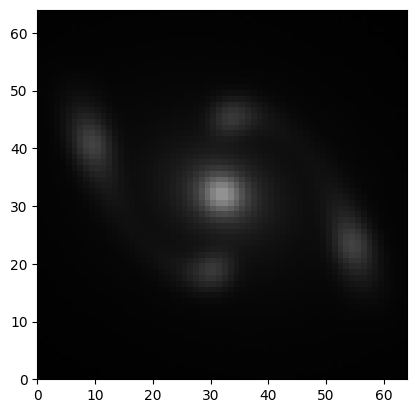

SL_sim_gal2/SL393.png


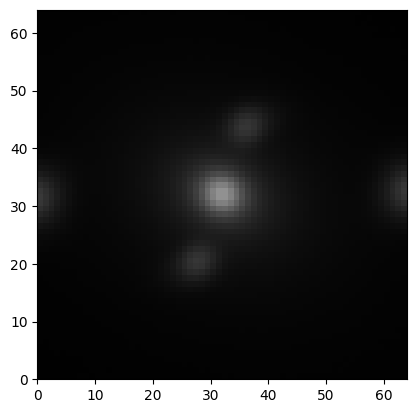

SL_sim_gal2/SL394.png


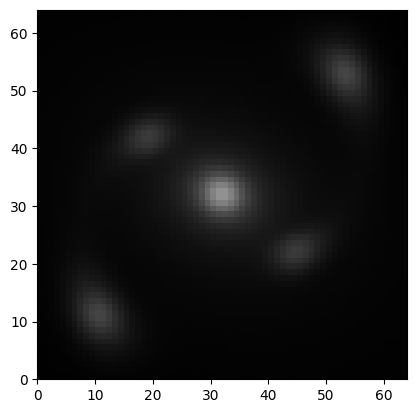

SL_sim_gal2/SL395.png


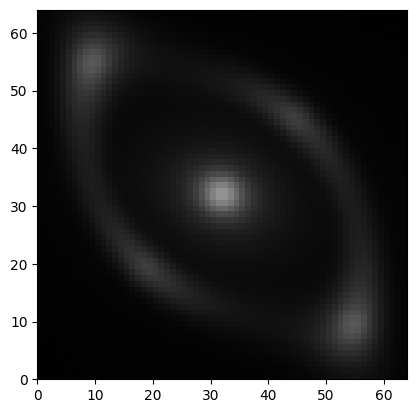

SL_sim_gal2/SL396.png


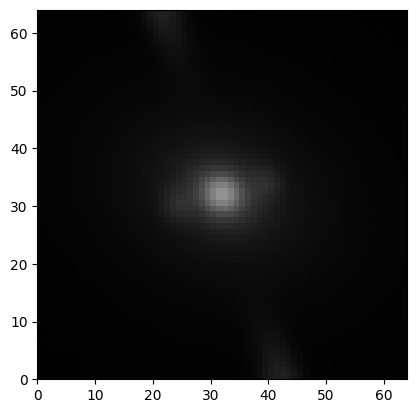

SL_sim_gal2/SL397.png


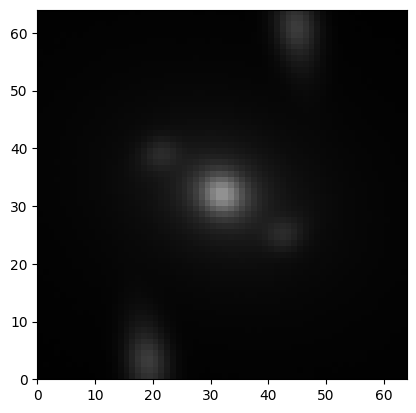

SL_sim_gal2/SL398.png


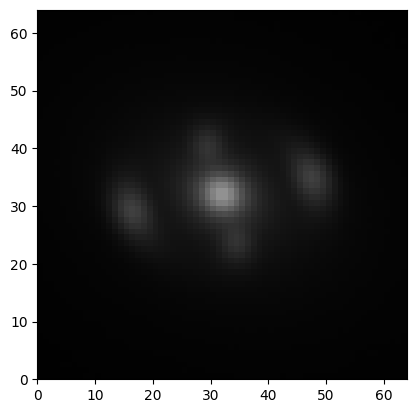

SL_sim_gal2/SL399.png


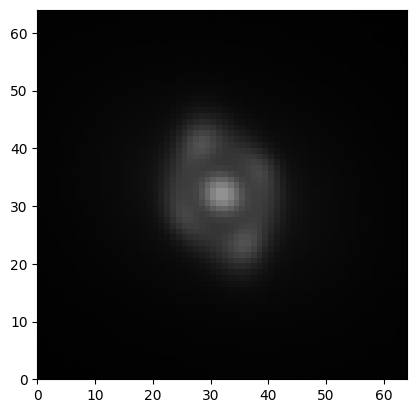

In [35]:
image_size = 66
import os

for i in range(400):
    #define parameters
    #I made them slightly less complicated
    theta_E = round(np.random.uniform(1,5),1) #2
    e1 = round(np.random.uniform(-0.5,0.5),1) #0.4
    e2 = round(np.random.uniform(-0.5,0.5),1) #-0.1
    center_x = 0
    center_y = 0
    gamma1 = round(np.random.uniform(-0.5,0.5),1)
    gamma2 = round(np.random.uniform(-0.5,0.5),1)
    ra_0=round(np.random.uniform(-50,50),1)
    dec_0=round(np.random.uniform(-50,50),1)

    def simulate_SL(theta_E=2, e1=0.4, e2=-0.1, center_x=0, center_y=0, gamma1=0.03, gamma2=0.01, ra_0=0, dec_0 = 0):
        kwargs_lens = [
        {'theta_E': theta_E, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y},  # SIE model
        {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': ra_0, 'dec_0': 0}  # SHEAR model
        ]

        image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)

        # add noise
        image_r += sim_r.noise_for_model(model=image_r)

        # and plot it
        #for now we just use the r image
    img = np.zeros((image_r.shape[0], image_r.shape[1]), dtype=float)
    img[:,:] = plot_util.sqrt(image_r, scale_min=0, scale_max=10000)

        return(img)

    img = simulate_SL(theta_E=theta_E, e1=e1, e2=e2, gamma1 = gamma1, gamma2 = gamma2)
    plt.clf()
    plt.imshow(img, aspect='equal', origin='lower',cmap='gray', extent=[0, image_size, 0, image_size])
    
    filename = f'SL{i}.png'
    save_path = f'SL_sim_gal2/{filename}'
    print(save_path)
    plt.savefig(save_path)
    plt.show()
    
    png_image = Image.open(save_path)
    # Convert the PNG image to a NumPy array
    data = np.array(png_image)

# Create a FITS header
    header = fits.Header()
    header['COMMENT'] = 'Converted from PNG to FITS'

# Create a FITS HDU (Header/Data Unit)
    hdu = fits.PrimaryHDU(data, header=header)

# Specify the path for saving the FITS file
    filename = f'SL{i}.fits'
    fits_path = f'SL_sim_gal2/{filename}'

# Write the FITS file
    hdu.writeto(fits_path, overwrite=True)

    if os.path.exists(save_path):
        # Delete the file
        os.remove(save_path)


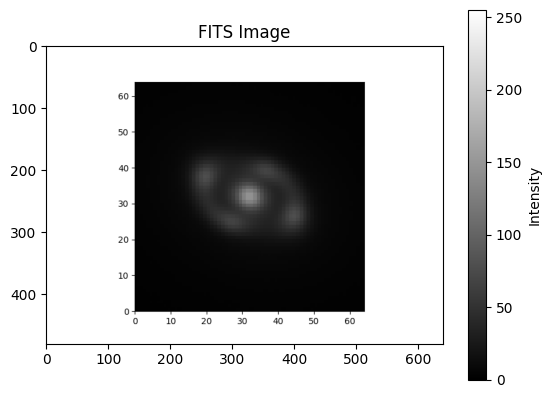

(480, 640, 4)


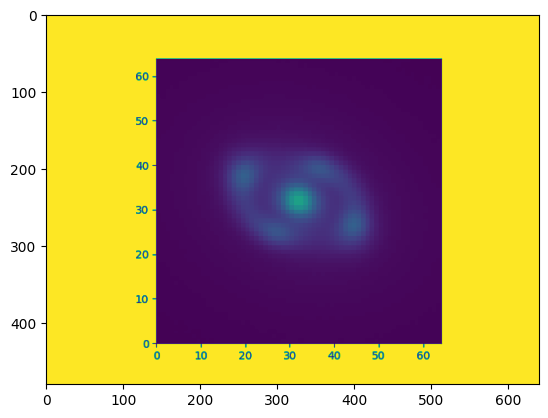

In [46]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Specify the path to your FITS file
fits_file_path = "SL_sim_gal2/SL0.fits"

# Open the FITS file
hdul = fits.open(fits_file_path)

# Assuming the data is in the primary HDU (extension 0)
data = hdul[0].data

# Close the FITS file
hdul.close()

# Plot the image using matplotlib
plt.imshow(data, cmap='gray')  # Use 'cmap' to specify the color map
plt.title("FITS Image")
plt.colorbar(label="Intensity")
plt.show()
    
print(np.shape(np.array(data)))
    
d = np.array(data)[:,:,2]
plt.imshow(d)

ModuleNotFoundError: No module named 'lenstronomy.Plots.output_plots'